In [1]:
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import matplotlib.colors as colors
import mpl_scatter_density
import pandas as pd # Pandas
# import uproot
import pickle
import logging
import pprint

import os # read directories etc.
from scipy.optimize import curve_fit
from scipy.stats import chisquare, goodness_of_fit, skew, skewtest

import pylandau  # Landau Gaussian convolution

from LoadBatch import *
from SensorClasses import *

verbose = False


### All the steps of the analysis put together and logically sequenced

In [2]:
### set logs level
logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] -\t %(message)s')

## Generic bins options, Batches import
the Batch objects are created by "logbook reader", it reads the .csv containing all the information about the batches (temperature, runs, angles, sensors etc.). Next I put all of the Batches into a dictionary for easier access

In [7]:
PIXEL_SIZE = 0.0185 #mm

### choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
large_bins = (np.arange(0, 900,1),
              np.arange(0, 600,1))

bins1 = (np.arange(450, 700, 1),
        np.arange(100, 500, 1))

bins2 = (np.arange(350, 700, 1),
              np.arange(150, 500, 1))

bins3 = (np.arange(300, 800, 1),
              np.arange(0, 450, 1))

### Load the dictionary of sensor names and runs
dict_of_batches = read_pickle("dict_of_batches.pickle")

logging.info(f"dictionary of the batches: \n{dict_of_batches}")

### presentation path
pres_path = '/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/Presentations/2024-03-07 for Nikhef Atlas weekly'

## Plot a single batch 
and a single oscilloscope

In [10]:
### show all information about the batch
this_batch = 205
S = 'S1'
print(dict_of_batches[this_batch].__dict__,'\n')

### show all informations about each sensor
temp_dict = {}
for ch, sensor in dict_of_batches[this_batch].S[S].channels.items():
#     print(f"{S}, {ch}:", sensor.__dict__)
    temp_dict[(S,ch)] = sensor.__dict__
temp_df = pd.DataFrame(temp_dict)

display(temp_df)

{'batch_number': 205, 'angle': 13.0, 'runs': [9742, 9743, 9744, 9745], 'tempA': -28.1, 'tempB': -28.3, 'S': {'S1': <SensorClasses.Oscilloscope object at 0x7fd0485c5300>, 'S2': <SensorClasses.Oscilloscope object at 0x7fd0485c55a0>}} 



S1                                                      
                     Ch1               Ch2               Ch3               Ch4
name                 MCP  IMEv3-W12-C2-2-2  IMEv3-W12-C2-2-2  IMEv3-W12-C3-1-4
board           no_board            CERN-1            CERN-1          no_board
dut_position         5.0               1.0               1.0                 1
fluence                0                 0                 0                 0
transimpedance        -1             10700             10700                -1
voltage             2500              -125              -125              -125

In [11]:
dict_of_batches[401].S['S1'].get_sensor('ch1').transimpedance

-1

### 2D Tracks

Batch:  205
S1
MCP: 2500 V, angle: 13.0° temperature:-28.10°C


[WARNING] -	 More than one minimum found at: [32.769127, 60.01436]
[WARNING] -	 More than one minimum found at: [32.769127, 60.01436]
[WARNING] -	 No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/marcello/.local/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/marcello/.local/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
[WARNING] -	 No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 2400x2400 with 2 Axes>,
 array([<ScatterDensityAxesSubplot:title={'center':'DUT: IMEv3-W12-C3-1-4'}, xlabel='$\\Delta t$ [ps] (DUT 3 - MCP)', ylabel='PulseHeight [mV]'>],
       dtype=object))

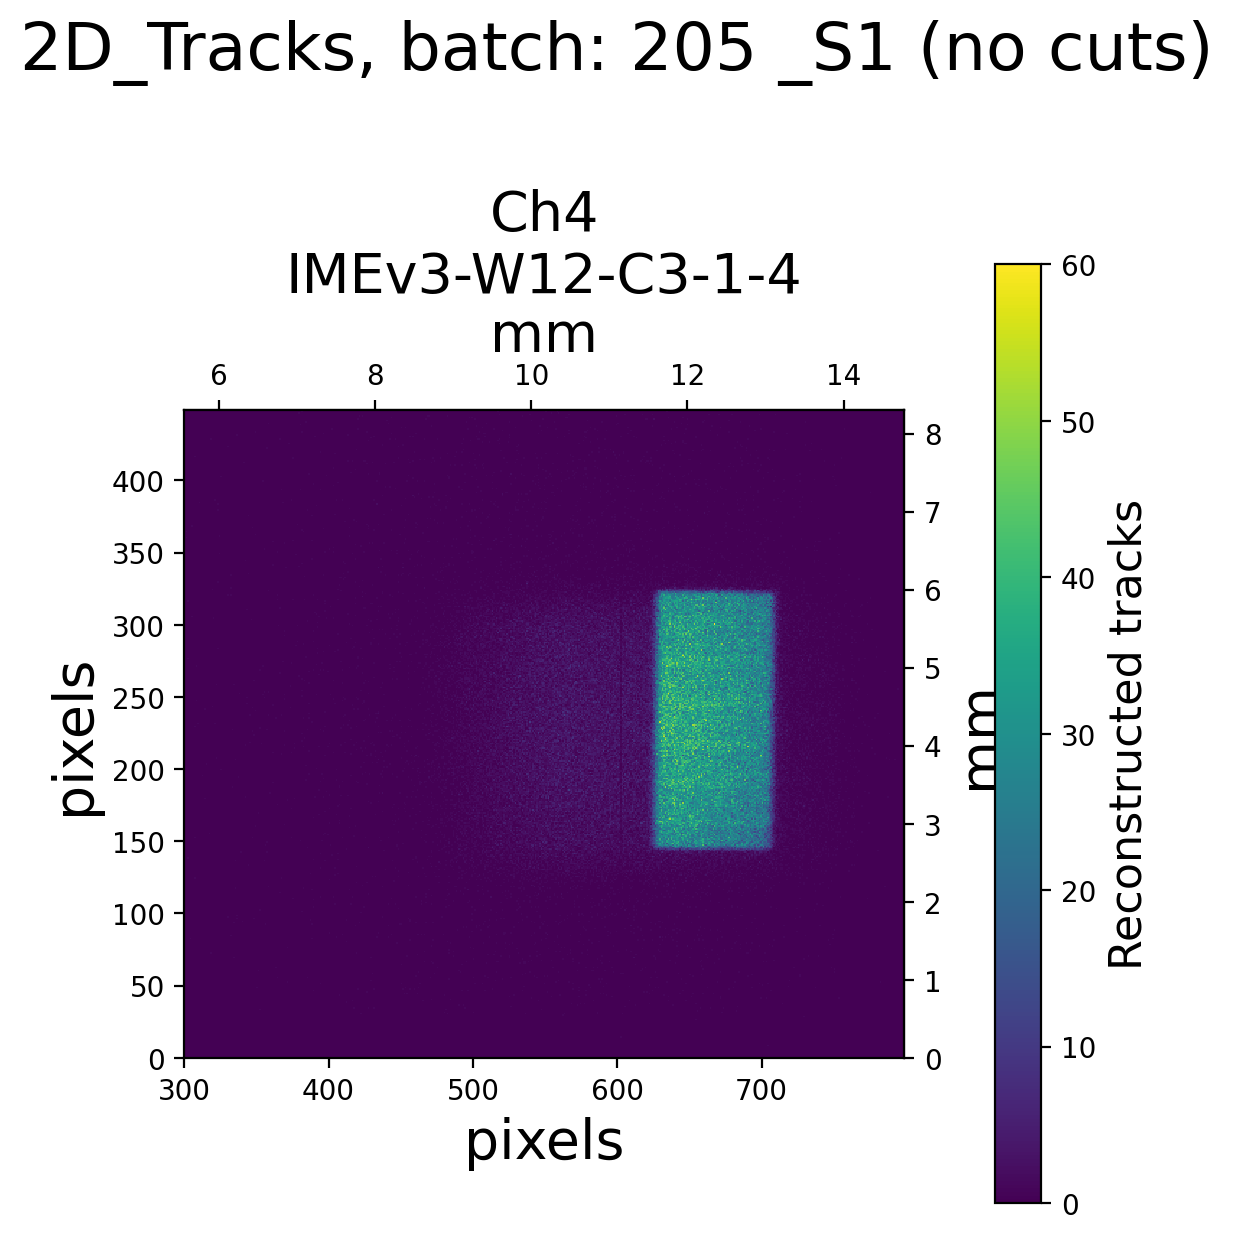

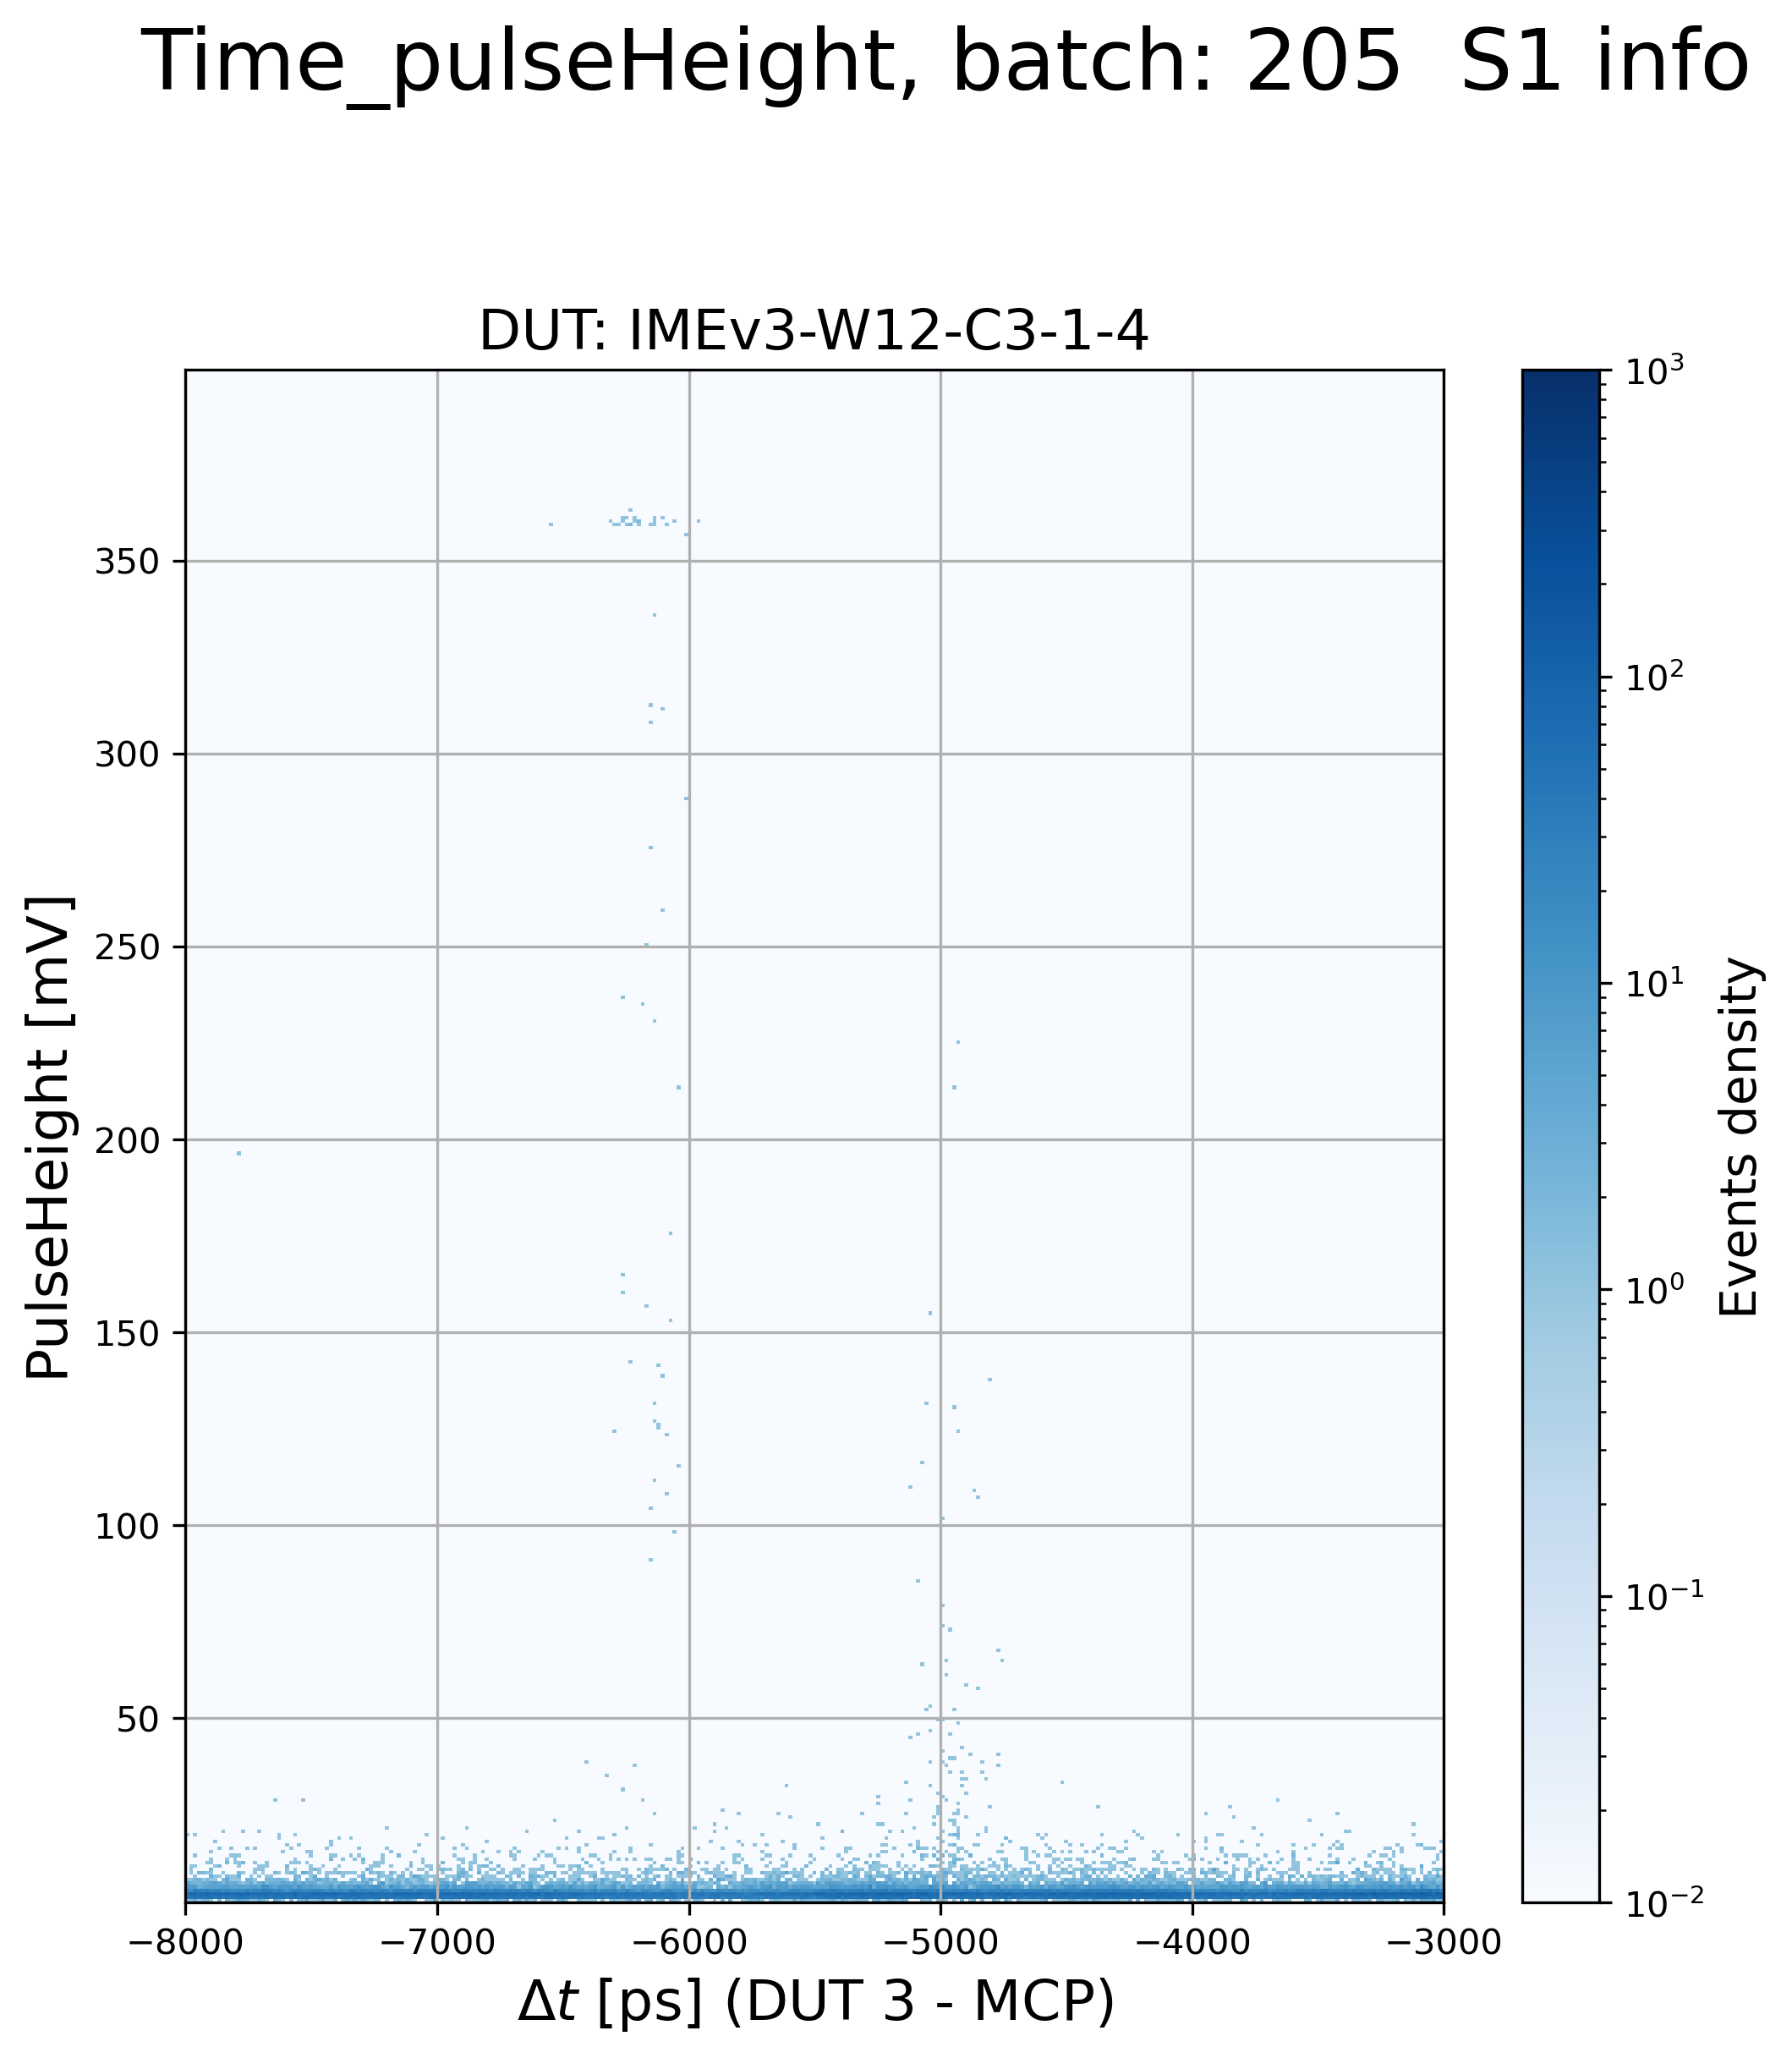

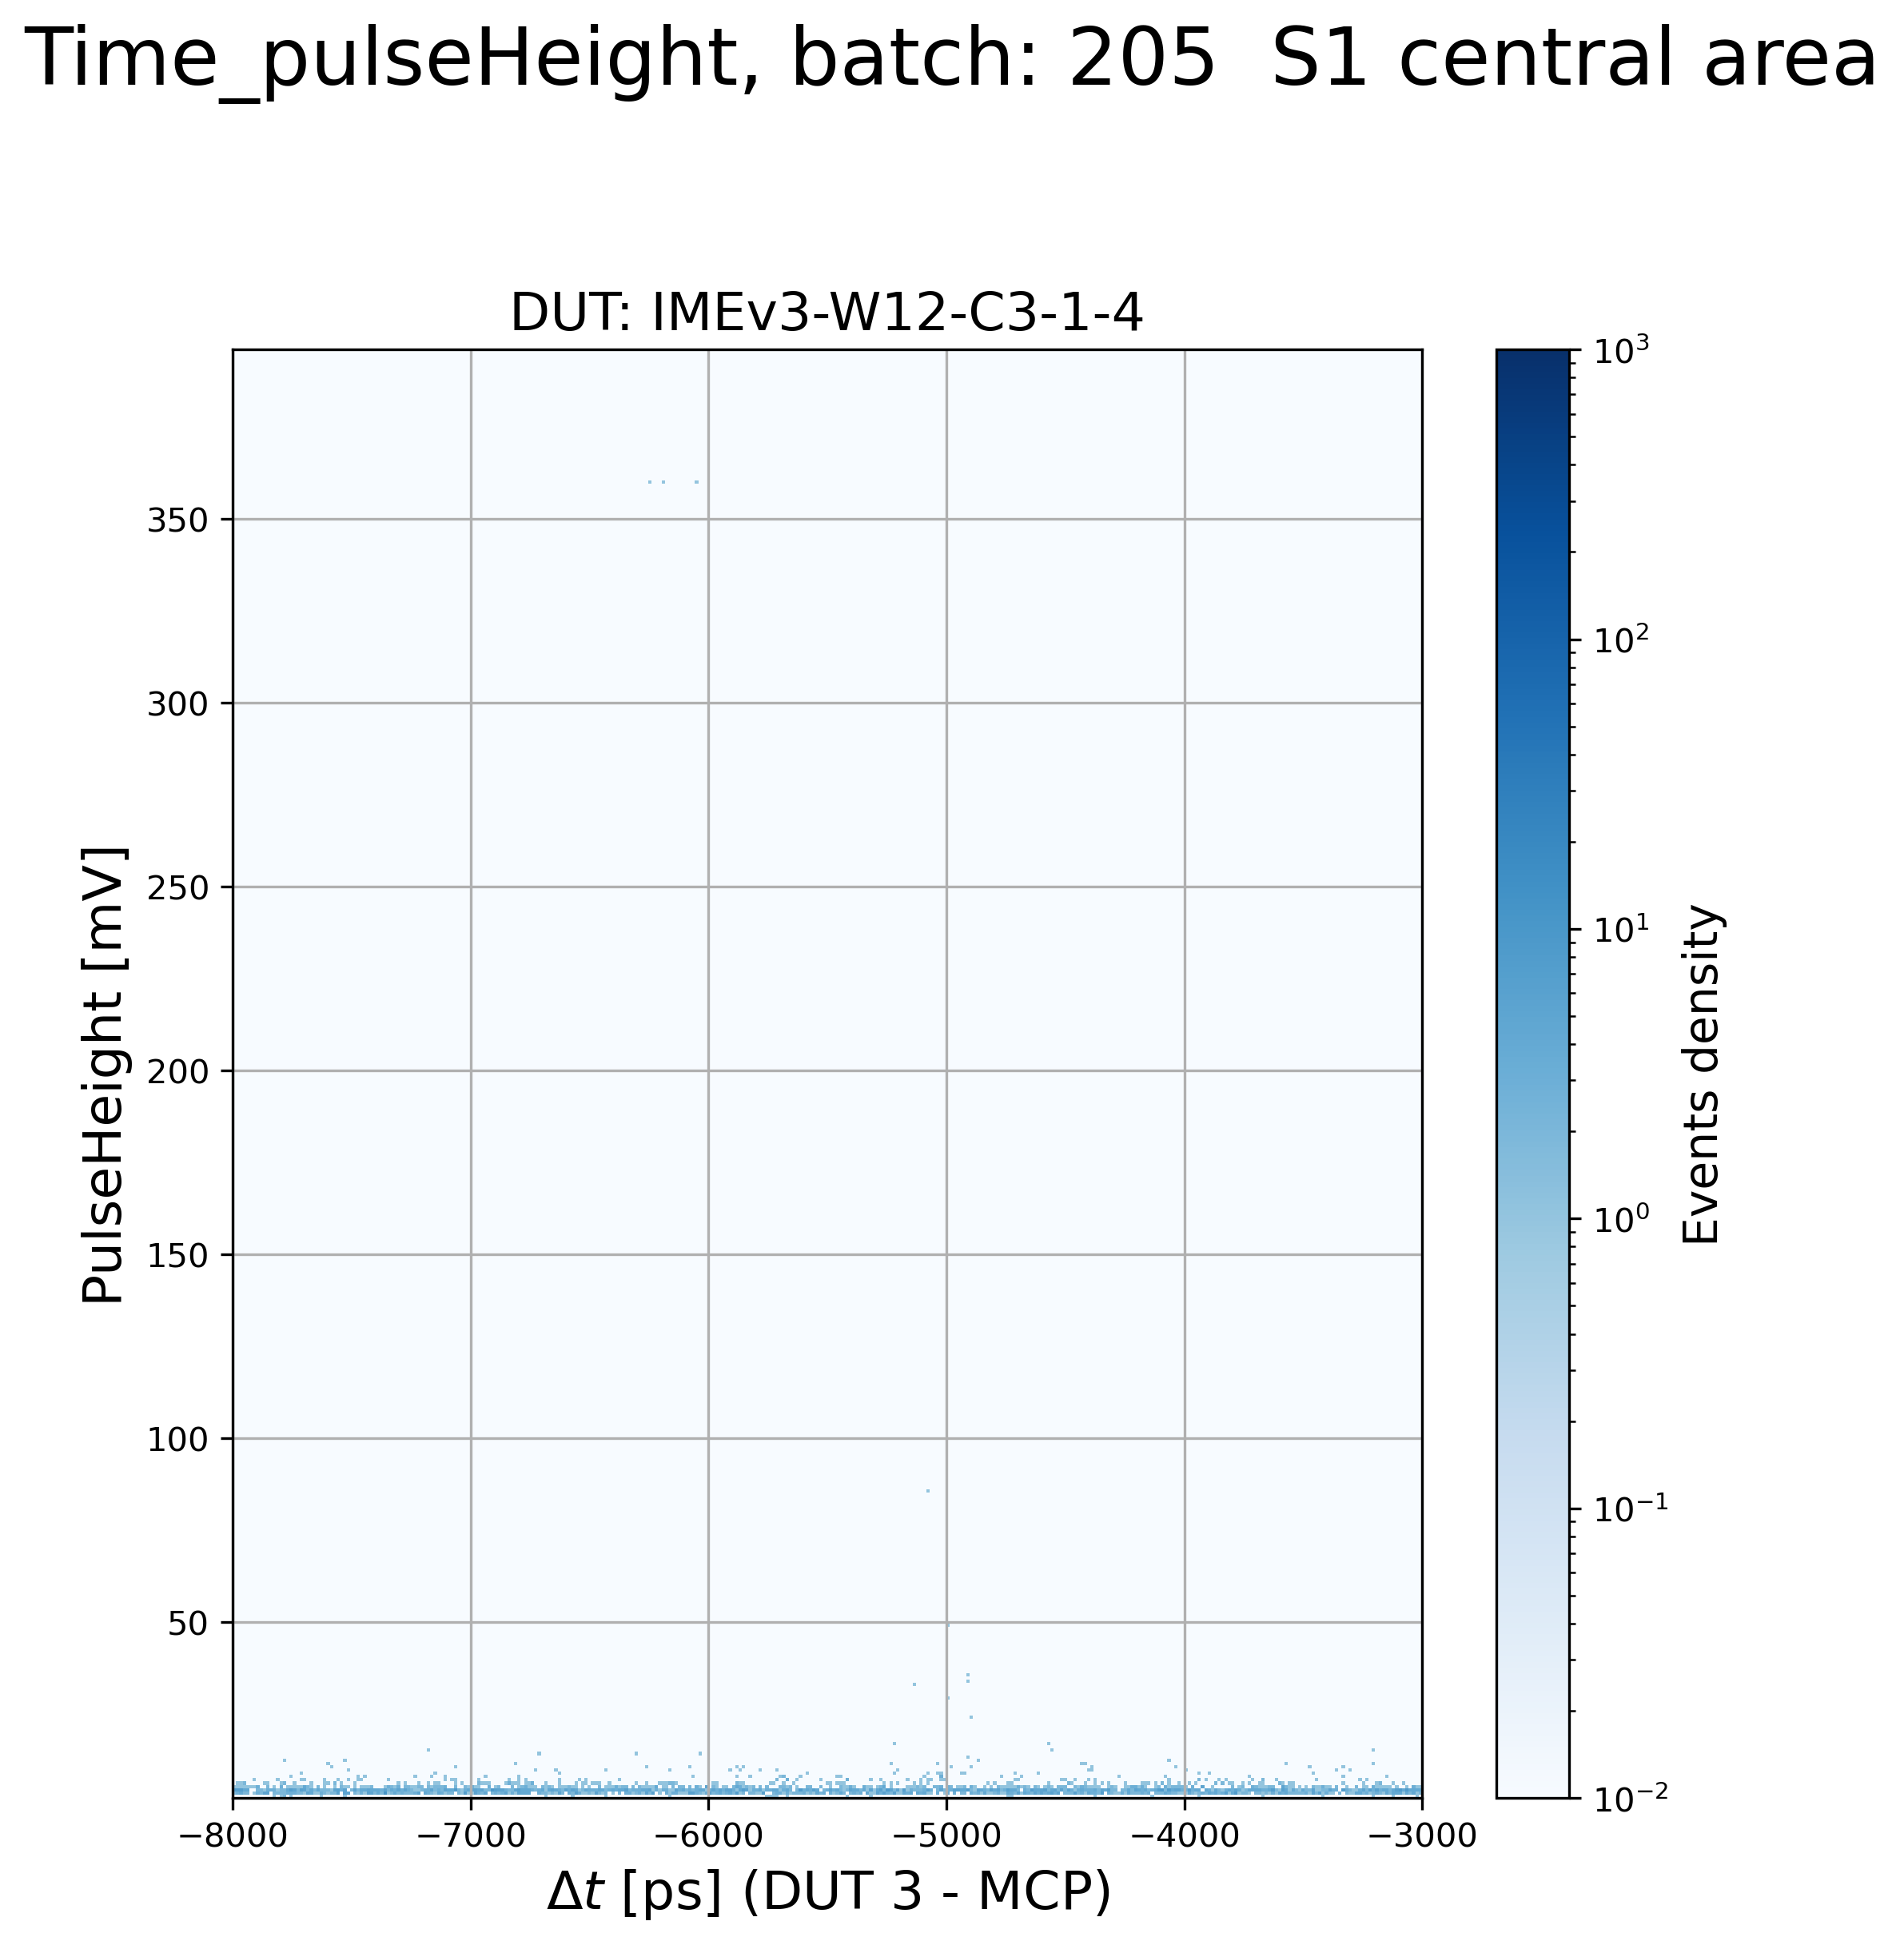

In [14]:
SAVE = False

threshold_charge = 4 #fC
DUTs = [3]

print("Batch: ", this_batch)
print(S)
df = load_batch(this_batch,S)
print(f'MCP: {dict_of_batches[this_batch].S[S].channels["Ch1"].voltage} V, angle: {dict_of_batches[this_batch].angle}°', 'temperature:%.2f°C'%dict_of_batches[this_batch].tempA)

these_bins = bins3
time_bins = 5000

time_cuts = [time_mask(df, i, bins=time_bins, plot=False, sigmas=3)[0] for i in [1,2,3]]
geo_cuts = [geometry_mask(df, DUT_number=dut, bins=bins1, bins_find_min='rice')[0] for dut in [1,2,3]]
central_sensor_area_cuts = [geometry_mask(df, DUT_number=dut, bins=bins1, bins_find_min='rice', only_select='center', use='pulseheight')[0] for dut in [1,2,3]]

# print(dict_of_batches[this_batch].S[S].channels['Ch3'].__dict__)

plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=these_bins,
     n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S} (no cuts)', savefig_path=pres_path, fmt='png')

### delta time vs pulseHeight no info
plot(df, "Time_pulseHeight", dict_of_batches[this_batch], S, bins=time_bins, info=False, extra_info=False,
     n_DUT=DUTs, savefig=SAVE, savefig_details=f' {S} info', savefig_path=pres_path, fmt='png')

plot(df, "Time_pulseHeight", dict_of_batches[this_batch], S, bins=time_bins, info=False, extra_info=False, mask=central_sensor_area_cuts,
     n_DUT=DUTs, savefig=SAVE, savefig_details=f' {S} central area', savefig_path=pres_path, fmt='png')

# plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=True, only_select='XY', mask=time_cut,
#     bins=these_bins, n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S} threshold_charge:{threshold_charge}fC')

# plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=False,
#     bins=these_bins, n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S} threshold_charge:{threshold_charge}fC')

# plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=True, only_select='extended', zoom_to_sensor=True,
#     bins=these_bins, n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S} threshold_charge:{threshold_charge}fC ')


### Apply a pulseHeight cut
to select only the sensor area

(<Figure size 2000x1200 with 1 Axes>,
 <AxesSubplot:xlabel='PulseHeight [mV]', ylabel='Events (log)'>)

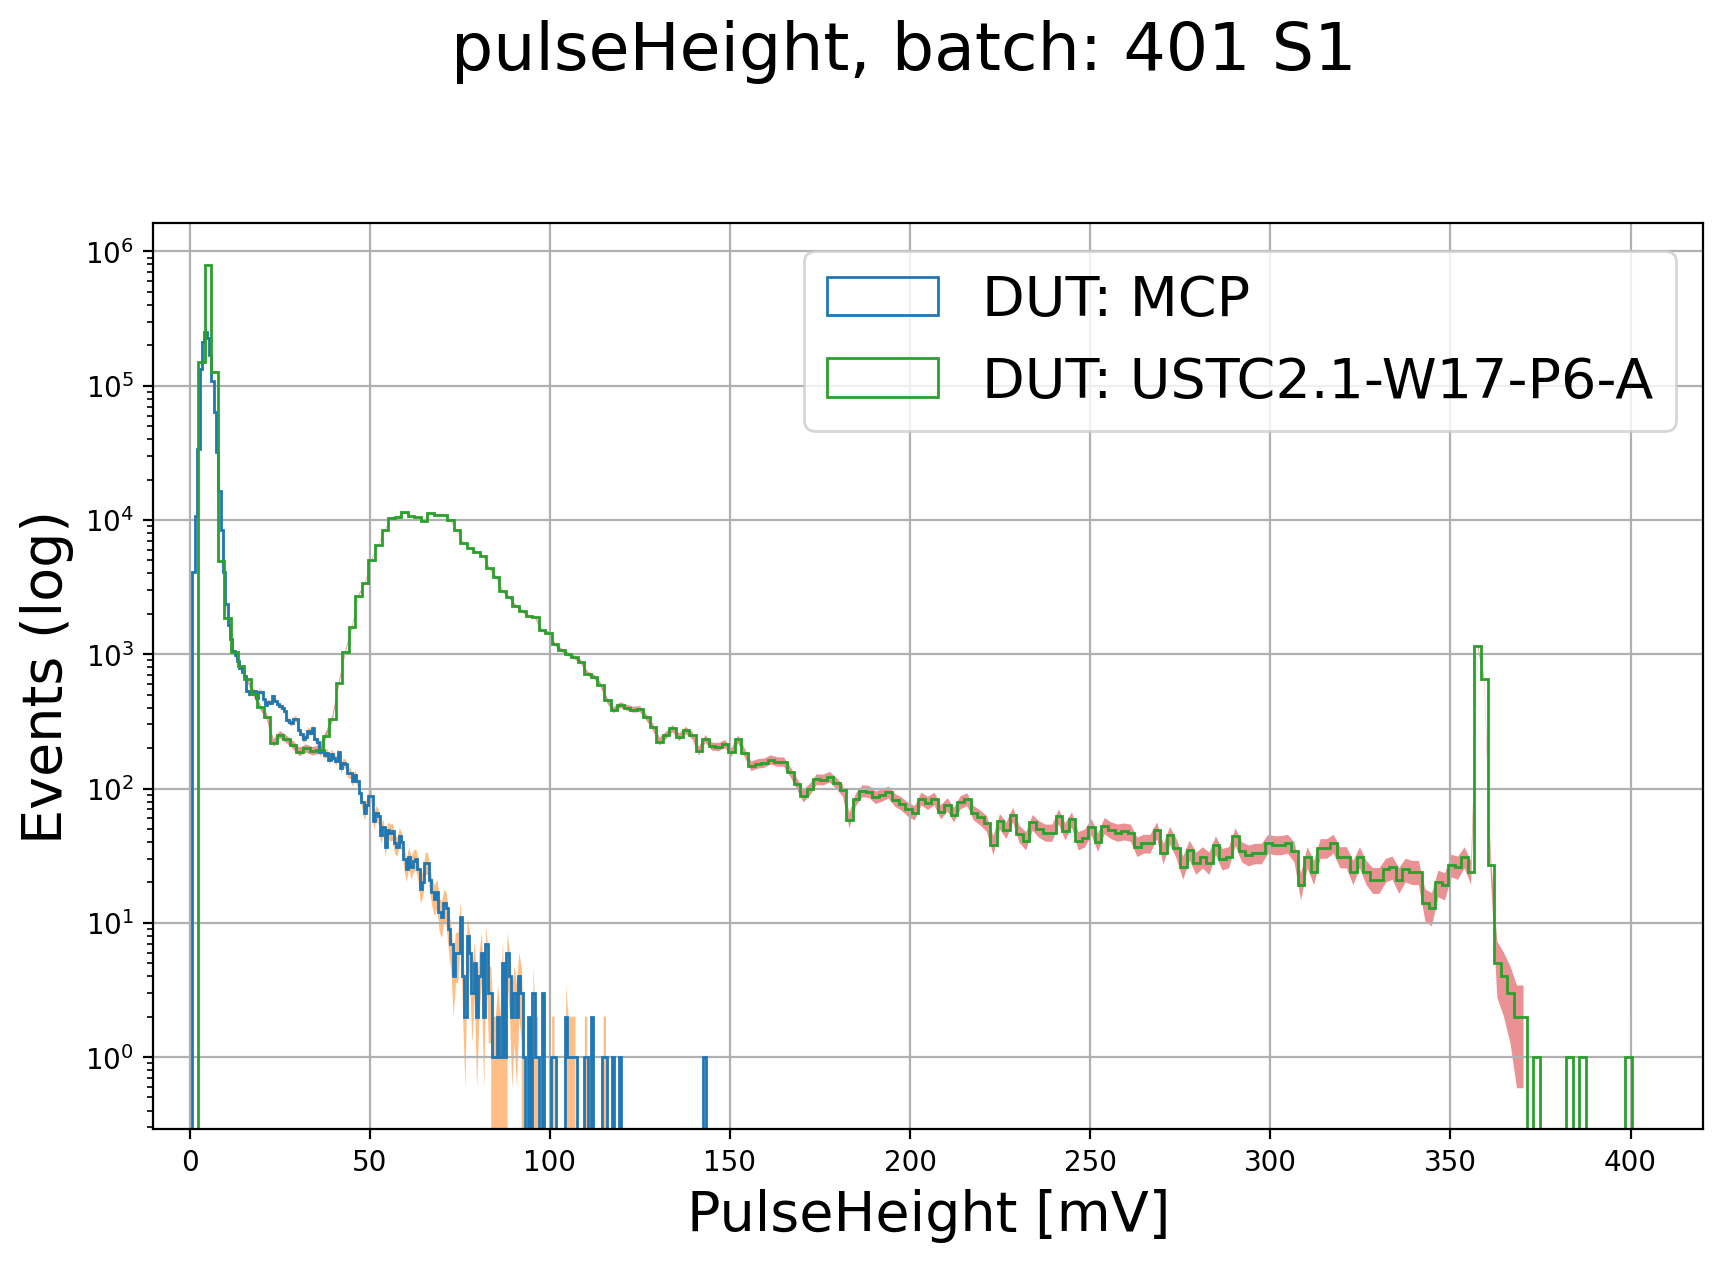

In [7]:
plot(df, "pulseHeight", dict_of_batches[this_batch], S, n_DUT=[0,1],
    savefig=SAVE, savefig_details=f'{S}', savefig_path=pres_path, fmt='png')

In [8]:
### Calculate the mins in the pulseHeight cut
mins = [find_min_btw_peaks(df[f"pulseHeight_{i}"], bins='rice', plot=False) for i in [1,2,3]]
mins.insert(0,None)     ### insert None as the 'peak' of the MCP

DUT_3


''

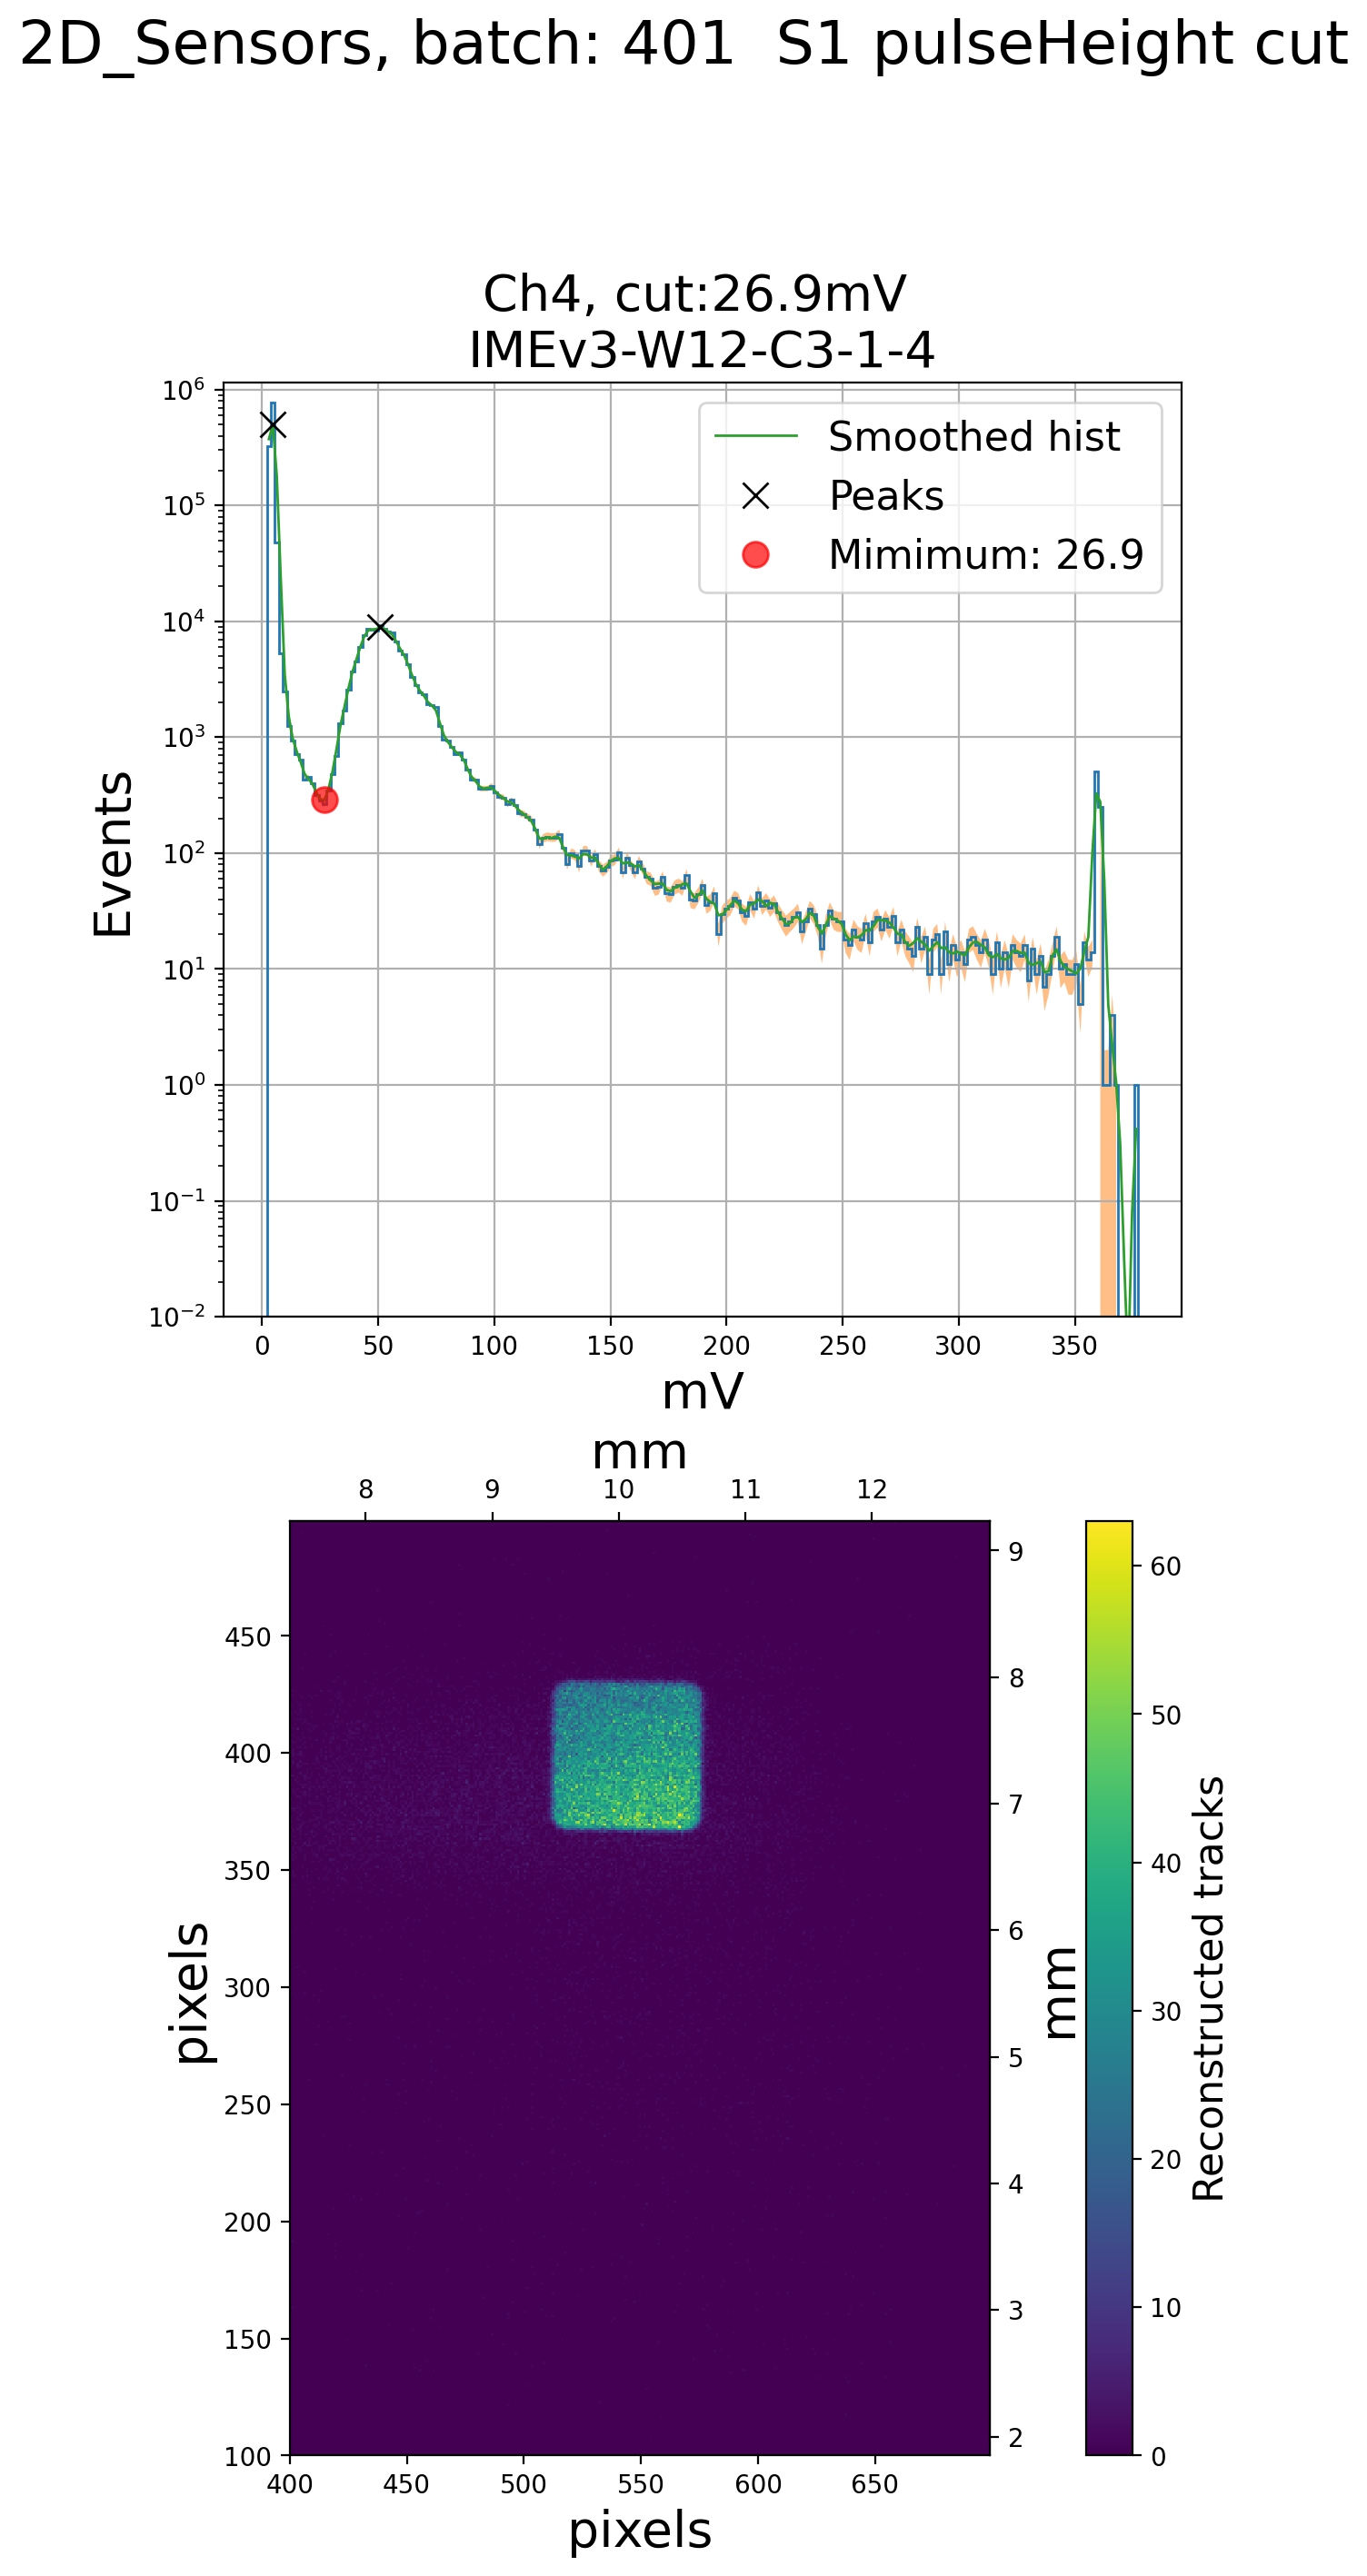

In [9]:

plot(df, "2D_Sensors", dict_of_batches[this_batch], S, bins=bins1,
     n_DUT=DUTs, savefig=SAVE, savefig_details=f' {S} pulseHeight cut', savefig_path=pres_path, fmt='png')
;

In [10]:
### not actually useful

# noise_cuts = [df[f"pulseHeight_{dut}"]<mins[dut] for dut in DUTs]
# plot(df, "2D_Tracks", dict_of_batches[this_batch], S, bins=bins1, mask=noise_cuts,
#      n_DUT=DUTs, savefig=SAVE, savefig_details=f' {S} (< pulseHeight min)', savefig_path=pres_path, fmt='png')

### Use the Tracks with a pulseHeight cut to define the 'edges' of the sensor

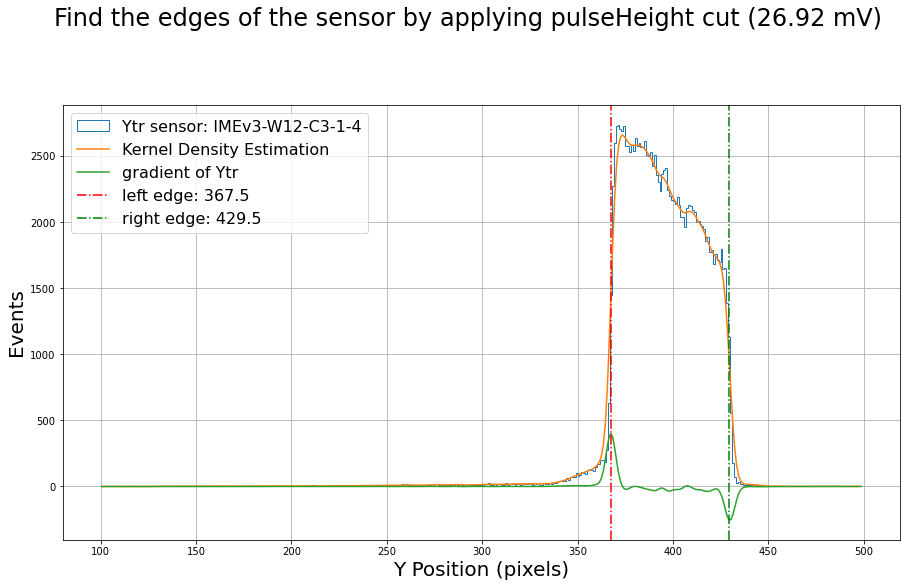

In [11]:
### I need to put all of this into the find_edges() so that they are the same
dut = 3
# axis, XY_bins = 'X', 0
axis, XY_bins = 'Y', 1

Tracks_cut = df[f'{axis}tr_{dut-1}'].loc[df[f'pulseHeight_{dut}']>mins[dut]]

fig, ax = plt.subplots(figsize=(15,8))
hist, my_bins, _ = ax.hist(Tracks_cut, bins=bins1[XY_bins], histtype='step', label=f"{axis}tr sensor: {dict_of_batches[this_batch].S[S].get_sensor(f'Ch{dut+1}').name}")

kde = gaussian_kde(Tracks_cut)
density_factor = sum(hist)*np.diff(my_bins)
bins_centers = (my_bins[1:]+my_bins[:-1])/2
values = time_limited_kde_evaluate(kde, bins_centers)*density_factor

ax.plot(bins_centers, values, label="Kernel Density Estimation")
ax.plot(bins_centers, np.gradient(values), label=f'gradient of {axis}tr')

left_edge = bins_centers[np.argmax(np.gradient(values))]
right_edge = bins_centers[np.argmin(np.gradient(values))]

ax.axvline(left_edge, color='r', linestyle='-.', label=f'left edge: {left_edge}')
ax.axvline(right_edge, color='g', linestyle='-.', label=f'right edge: {right_edge}')
fig.suptitle("Find the edges of the sensor by applying pulseHeight cut (%.2f mV)"%mins[dut], fontsize=24, y=1.05)

ax.set_xlabel(f"{axis} Position (pixels)", fontsize=20)
ax.set_ylabel("Events", fontsize=20)
ax.grid('--')
ax.legend(fontsize=16, loc='best')

# fig.savefig(os.path.join(pres_path,f"locating_edges_{axis}tr_batch_{this_batch}_{S}_DUT{dut}.svg"),bbox_inches='tight')

## Geometry cut
I can now use the previous result as a definition for the geometry cut shown over all the tracks

In [12]:
geo_cuts = [geometry_mask(df, DUT_number=dut, bins=bins1, bins_find_min='rice', only_select='normal', use='pulseheight')[0] for dut in [1,2,3]]
geo_infos = [geometry_mask(df, DUT_number=dut, bins=bins1, bins_find_min='rice', only_select='normal', use='pulseheight')[1] for dut in [1,2,3]]

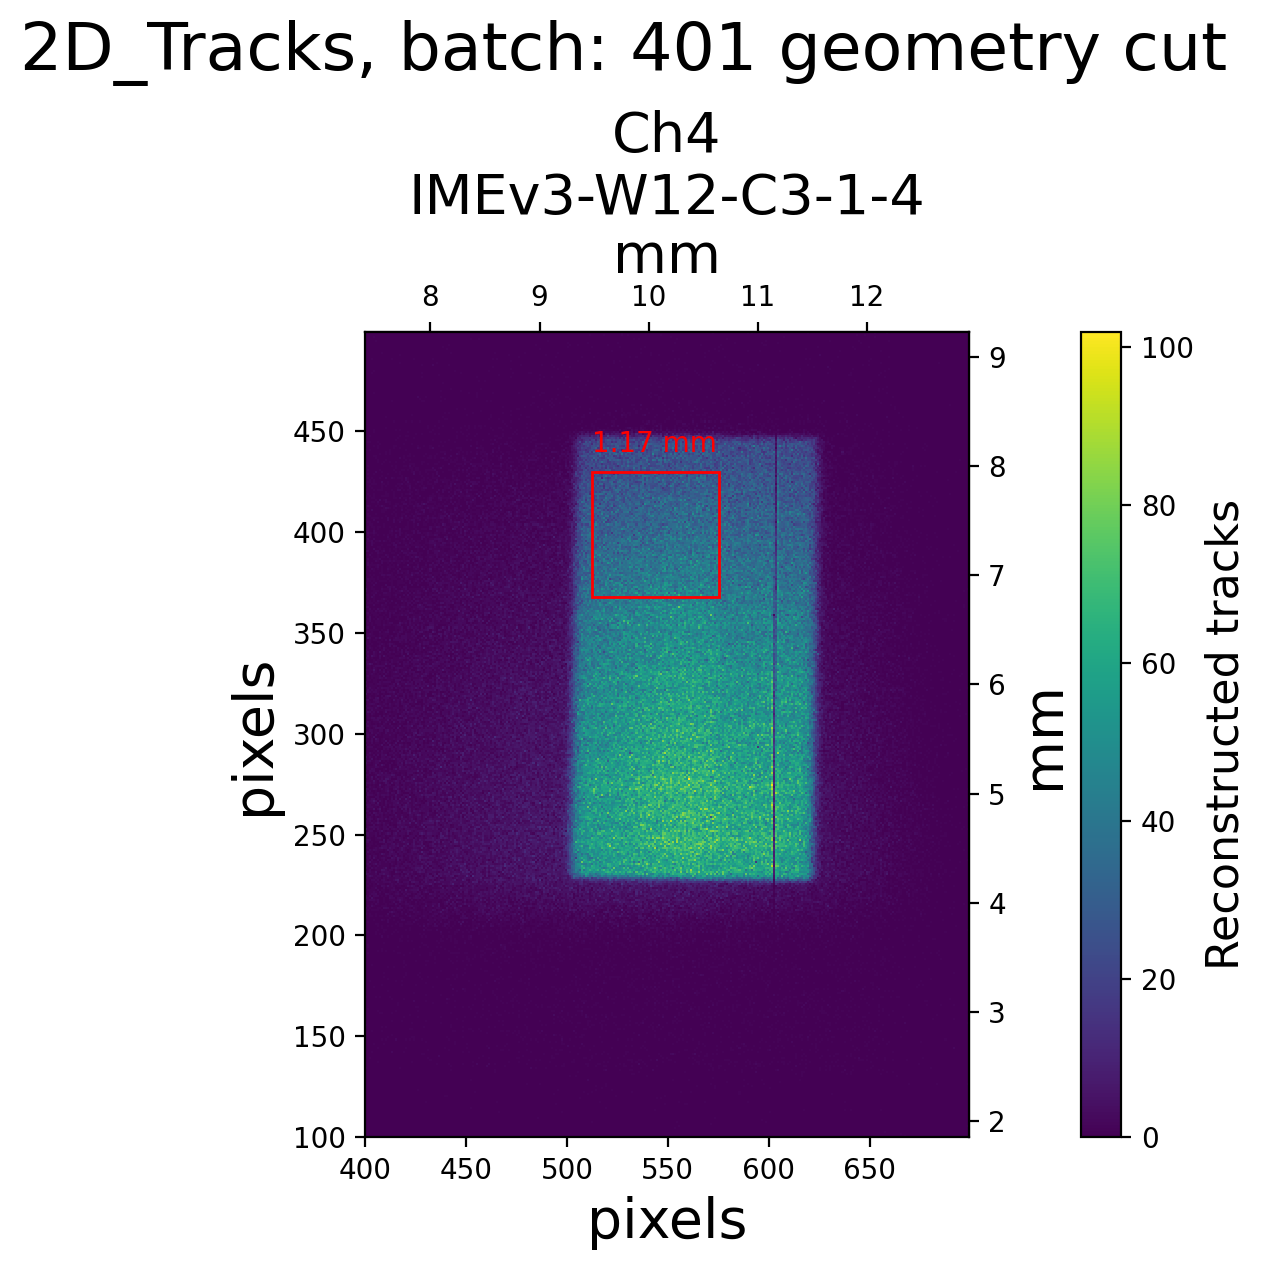

In [13]:
# plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=bins1, mask=geo_cuts,
#      n_DUT=DUTs, savefig=SAVE, savefig_details='geometry cut', savefig_path=pres_path, fmt='png')

fig, axes = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=bins1,
     n_DUT=DUTs, savefig=SAVE, savefig_details='geometry cut', savefig_path=pres_path, fmt='png')

for i,dut in enumerate(DUTs):
    axes[i].add_patch(rectangle_from_geometry_cut(**geo_infos[dut-1]))
    sensor_size = (geo_infos[dut-1]['right_edge']-geo_infos[dut-1]['left_edge'])*PIXEL_SIZE
    axes[i].text(x=geo_infos[dut-1]['left_edge'], y=geo_infos[dut-1]['top_edge']+10, s='%.2f mm'%sensor_size, color='r')
    
fig.savefig(os.path.join(pres_path,f"2D_Tracks_401_{S} highlight geometry cut.png"), bbox_inches='tight')

### Geometry cut AND pulseHeight cut


(<Figure size 1200x1200 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Ch4\nIMEv3-W12-C3-1-4'}, xlabel='pixels', ylabel='pixels'>],
       dtype=object))

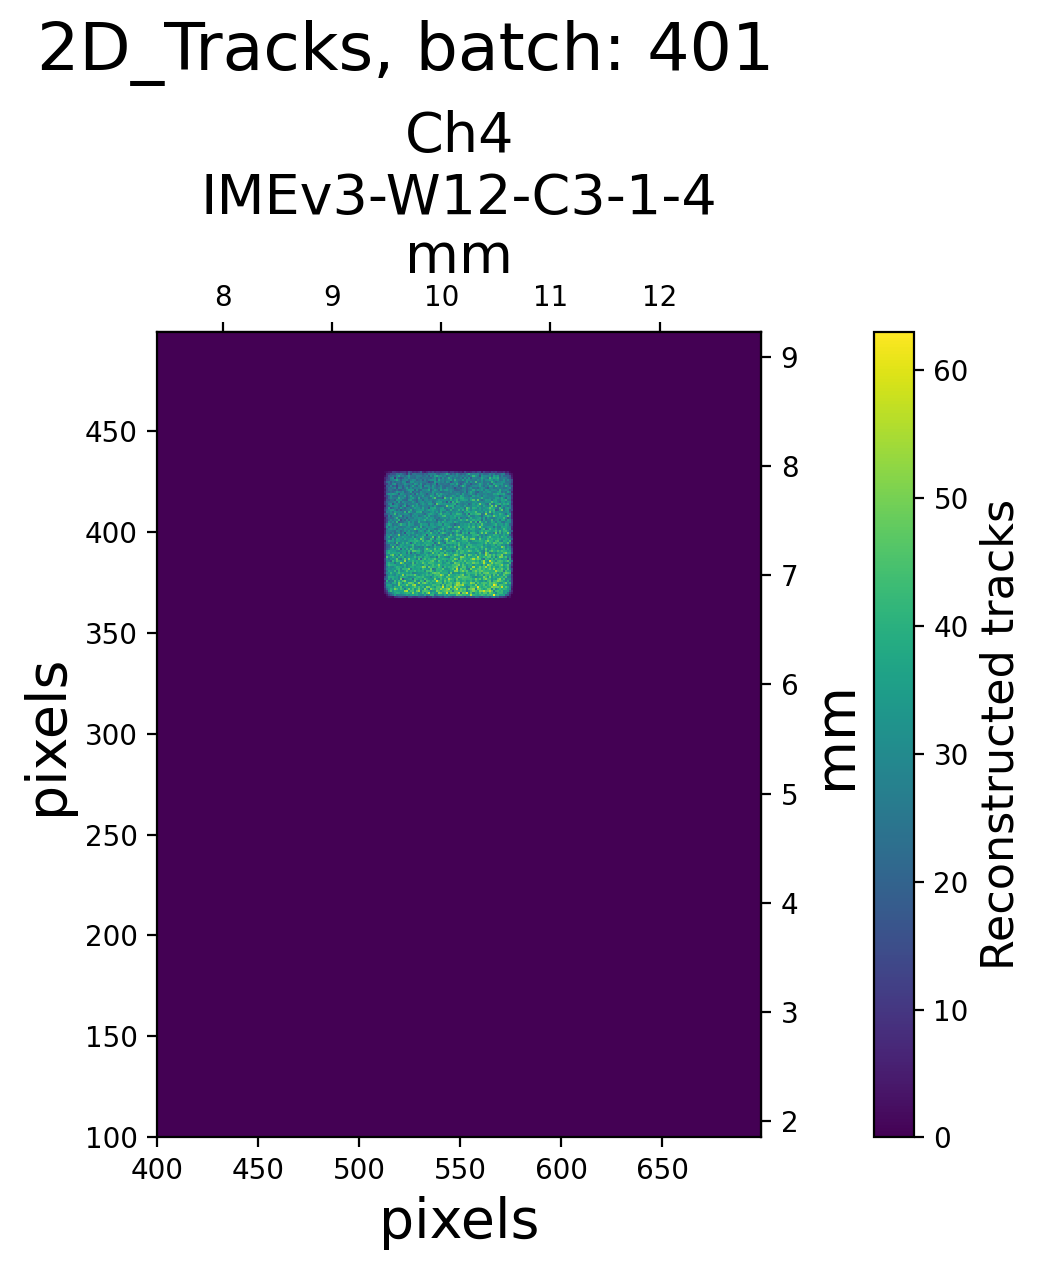

In [14]:
### TRACKS
pulse_cuts = [df[f"pulseHeight_{dut}"]>mins[dut] for dut in [1,2,3]]
pulse_geo = [np.logical_and(geo_cuts[i],pulse_cuts[i]) for i,dut in enumerate([1,2,3])]

plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=bins1, mask=pulse_geo,
     n_DUT=DUTs, savefig=SAVE, savefig_path=pres_path, fmt='png')

### With the options to:
- selecting a slightly larger area to study the outer part
- selecting only the center, to get the clearest signal 

### 1D Projection of the tracks
to highlight the repeated horizontal lines and the vertical empty line

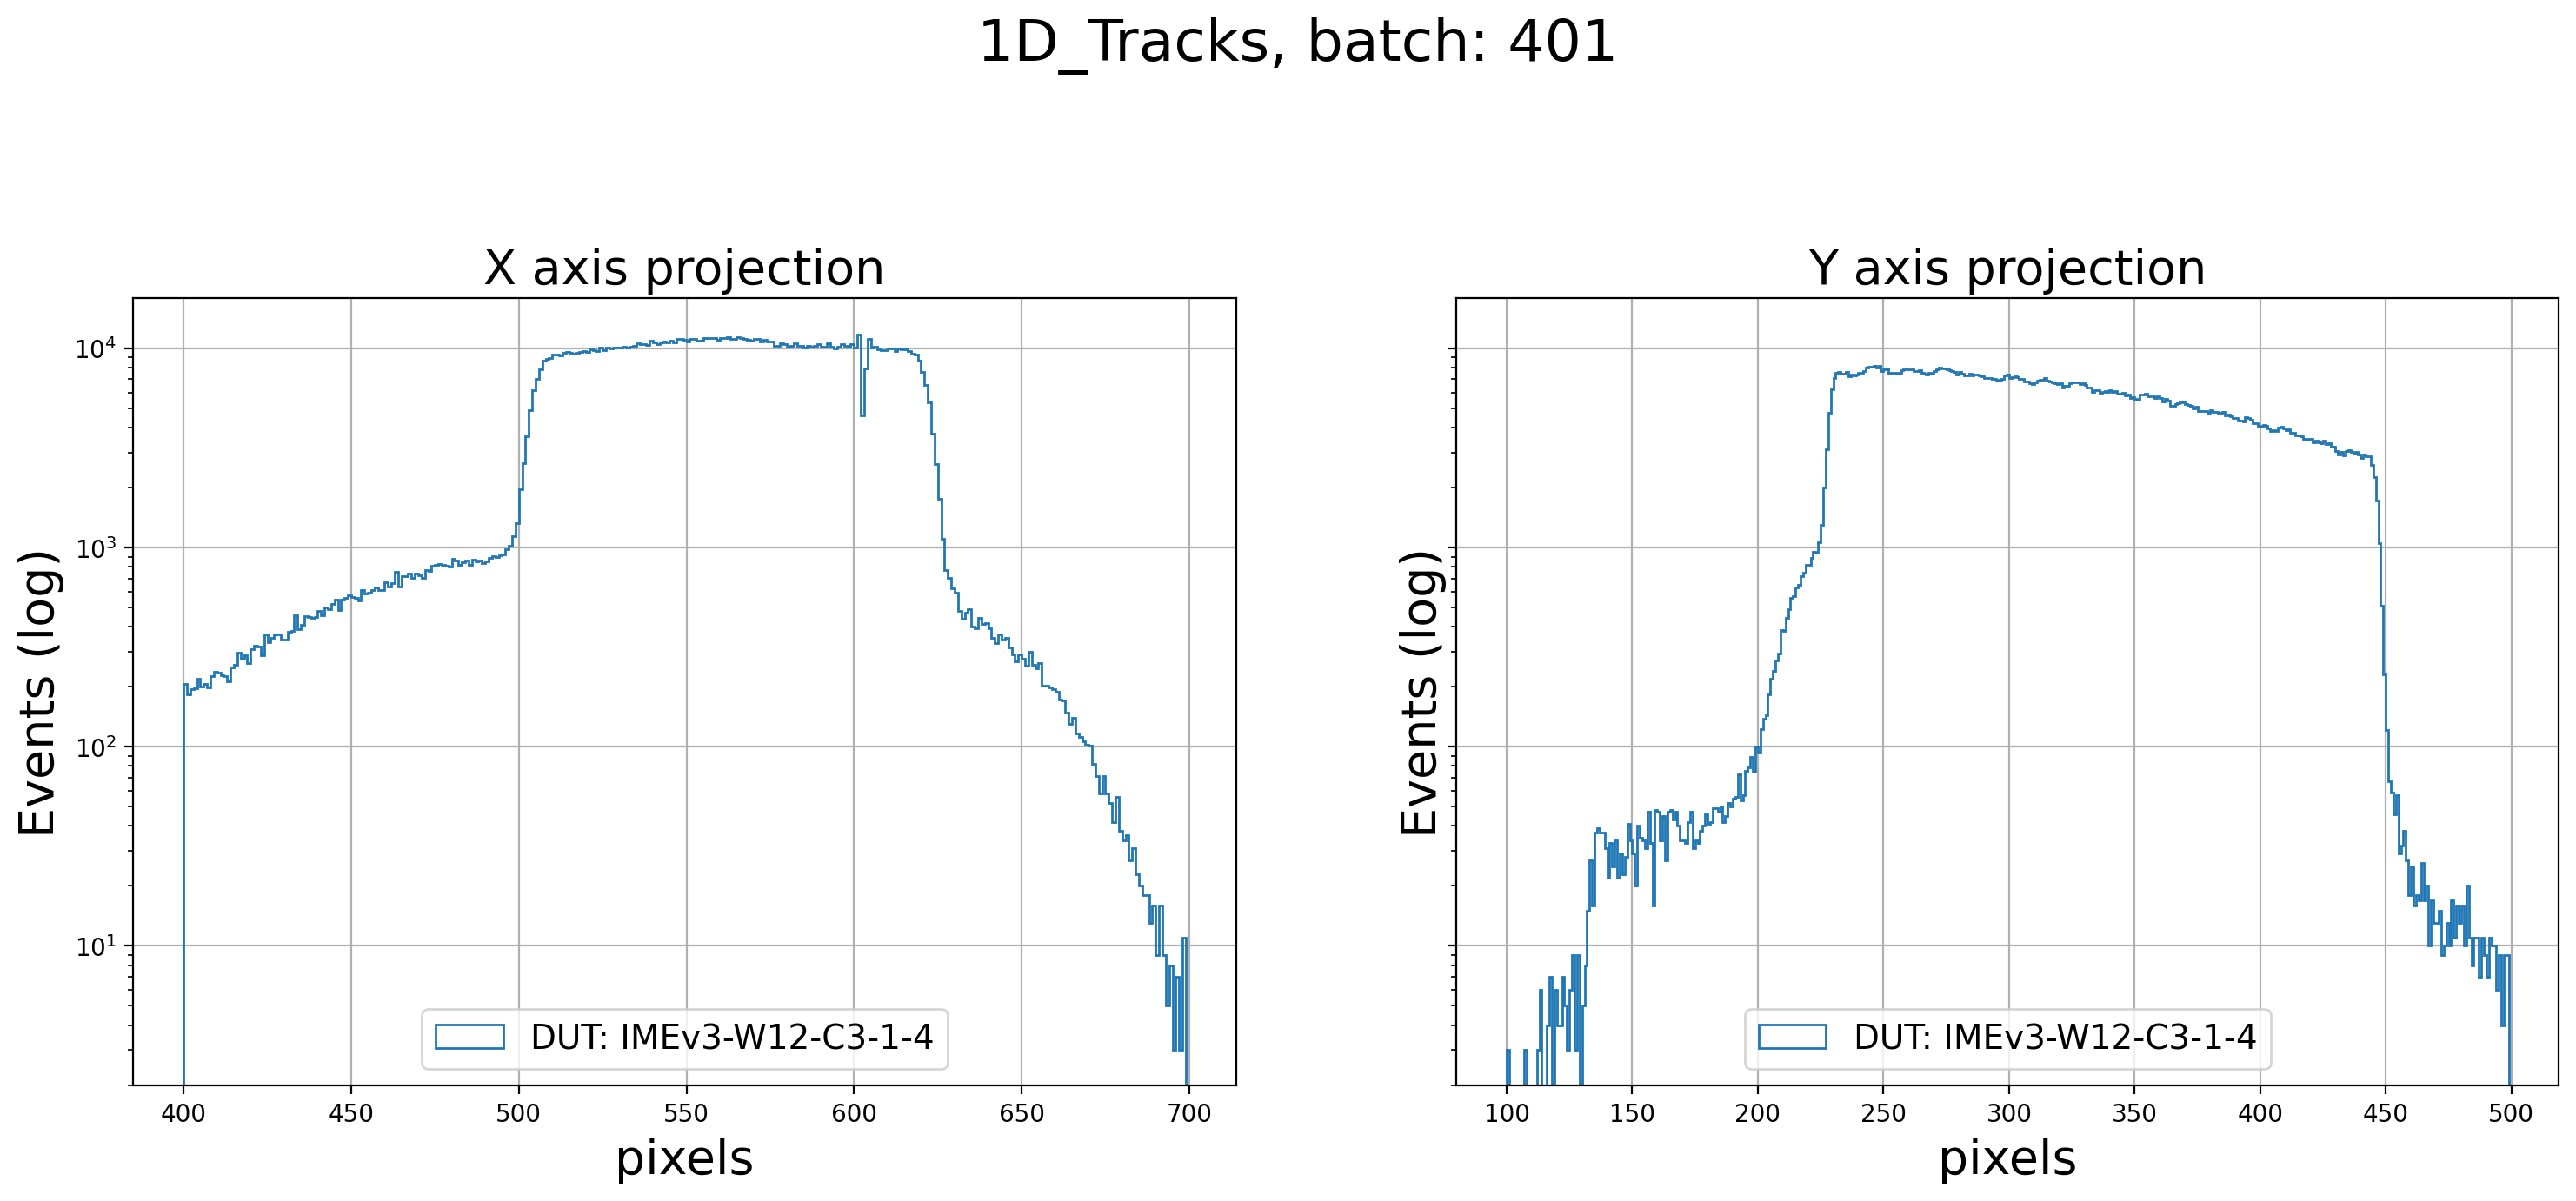

In [15]:
SAVE = False
fig, axes = plot(df,"1D_Tracks", dict_of_batches[this_batch], S, bins=bins1,
     n_DUT=DUTs, savefig=SAVE, savefig_path=pres_path, fmt='png')
for ax in axes:
    ax.legend(fontsize=14, loc='lower center')


## Time cut
Fit the $\Delta t$ with a gaussian, pick some  n*$\sigma$ interval and select events only in this window apply the fit from -20ns to +20ns so that the background is more flat
- also add full time range

### Gaussian:
$$
\Large
f(x,A,\mu,\sigma,BG) = A \cdot e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma} \right)^2} + BG
$$

- $A:  \quad $ Amplitude (n° of events)
- $\mu: \quad $ Mean of the gaussian
- $\sigma: \quad $ Standard deviation
- $BG: \quad $  Flat background

In [16]:
### actually maybe first I want a plot of the time MCP-dut without the fit
colormap = ['k','b','g','r']

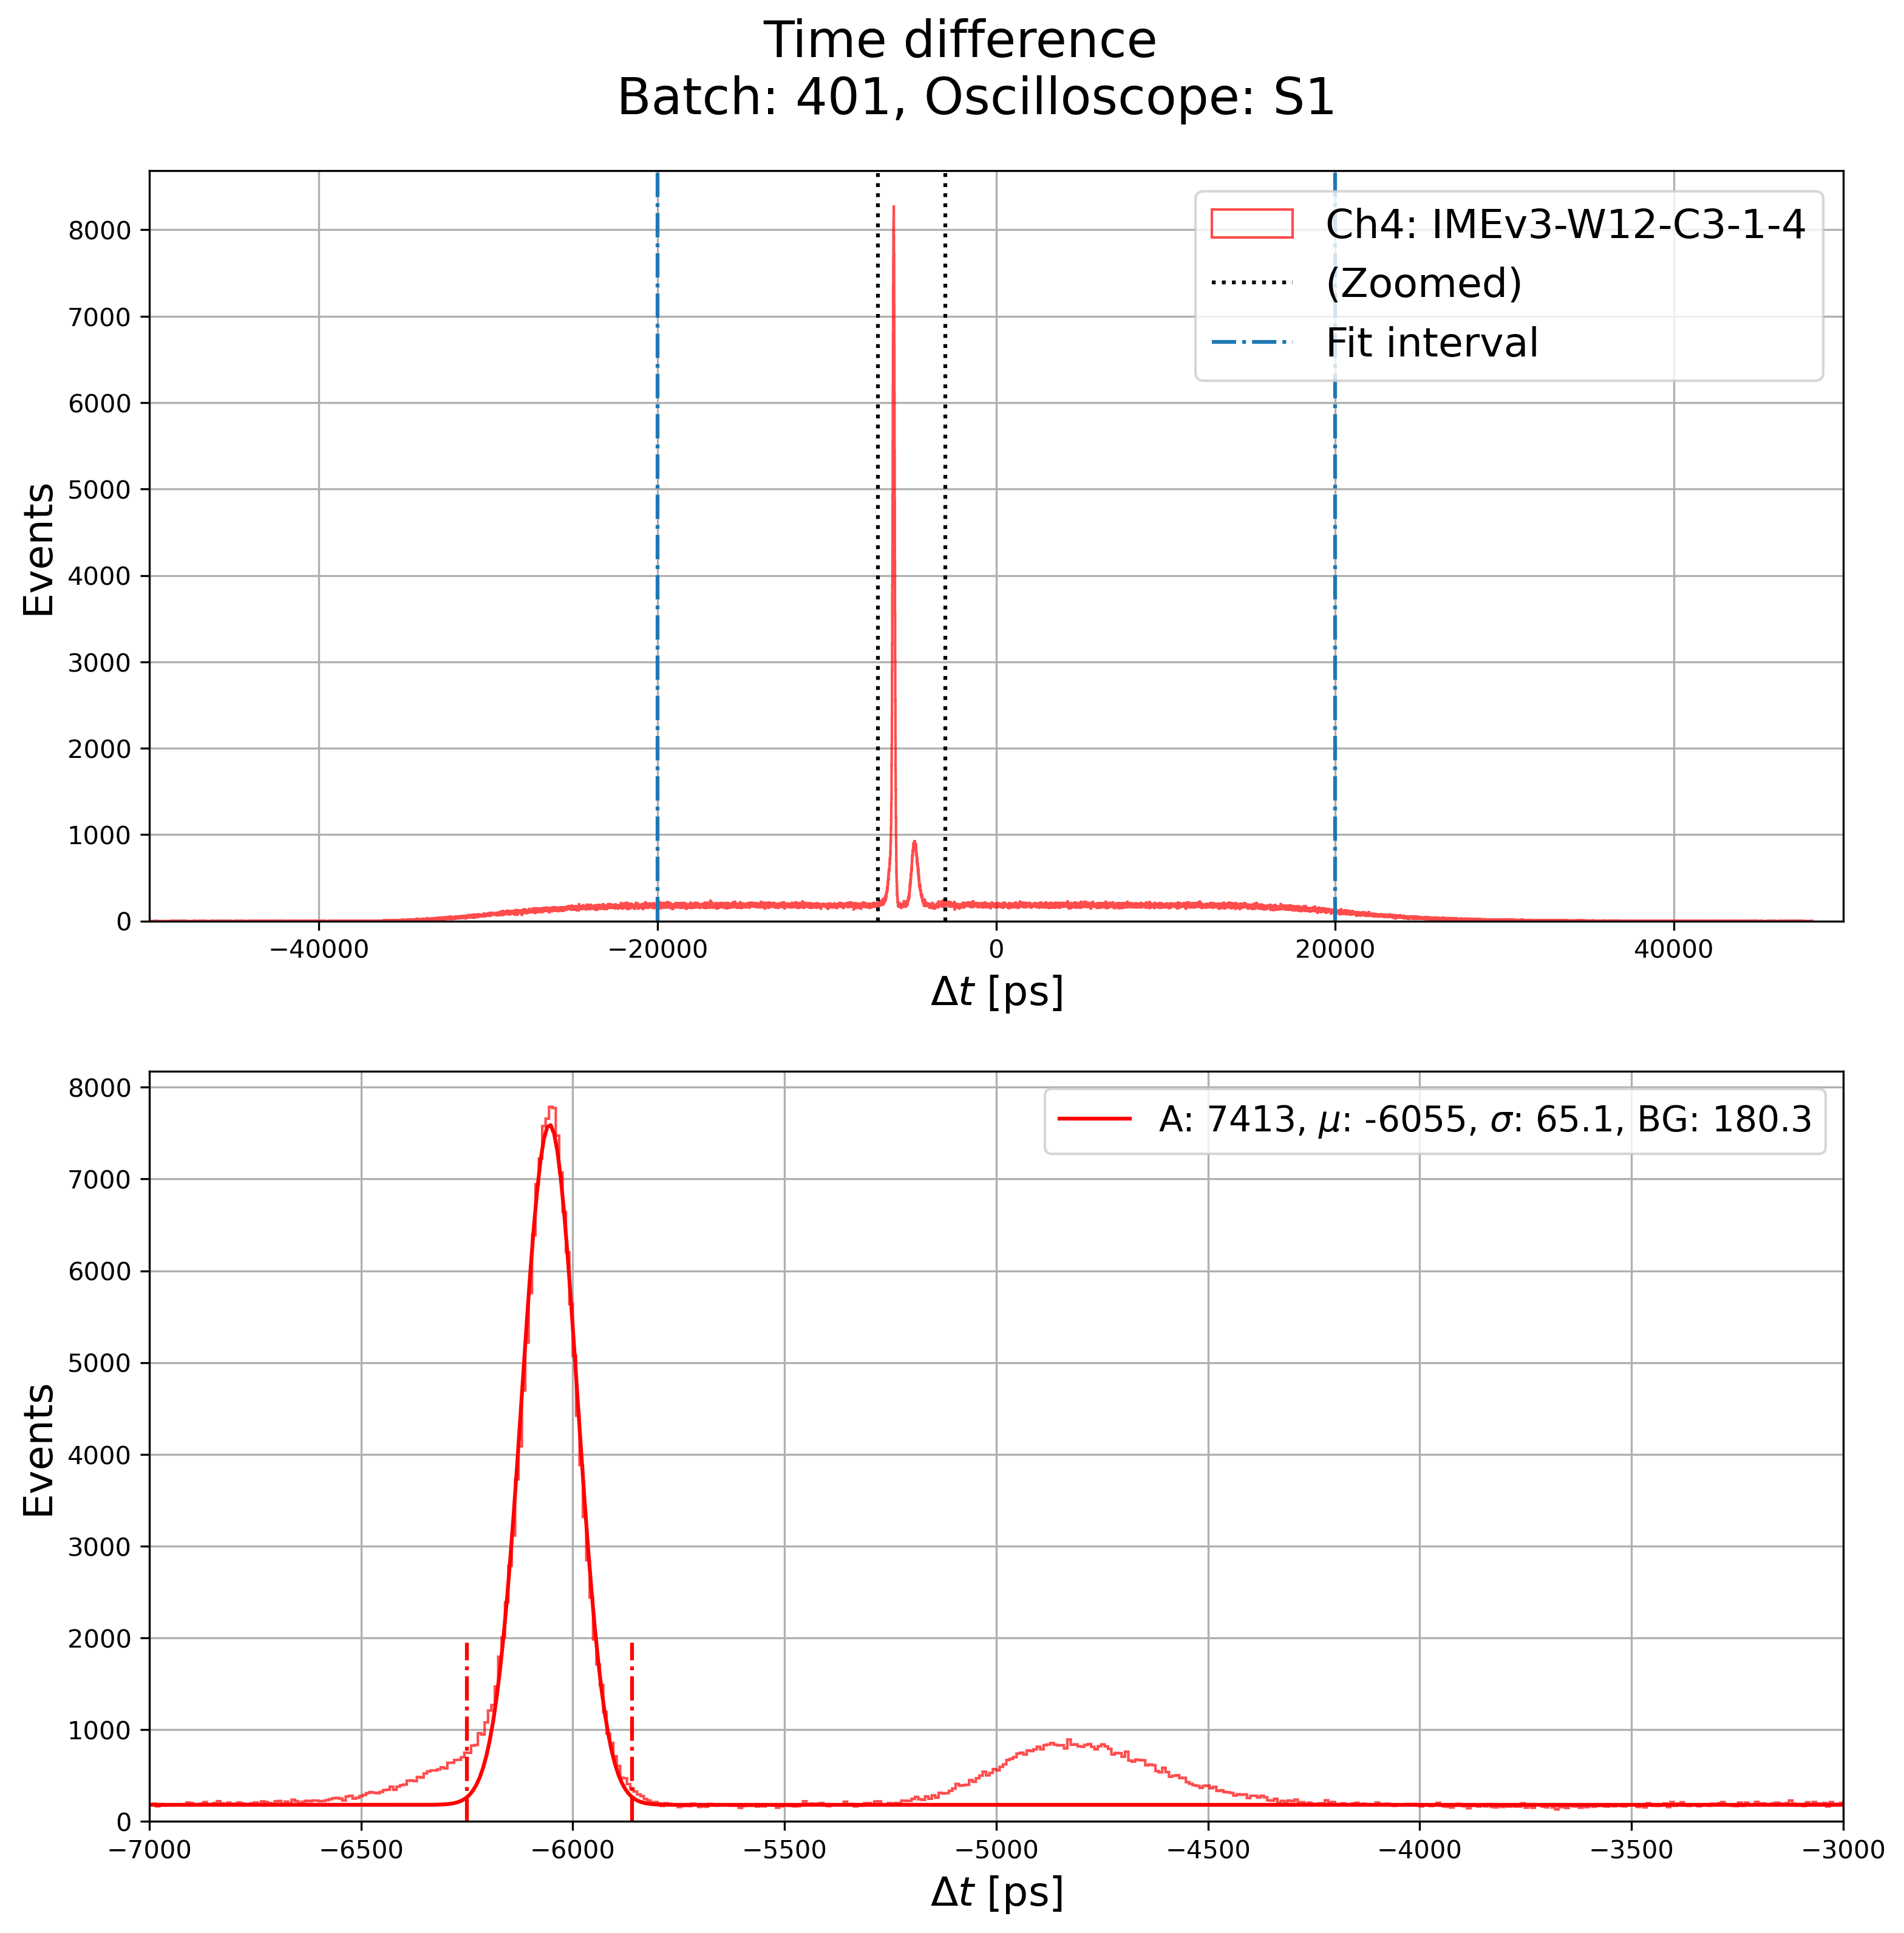

In [17]:
### SAME THING BUT ONLY FIRST PLOT
### now I fit between -20ns < delta t < 20ns
SAVE = True
fig, axes = plt.subplots(figsize=(12,12),nrows=2, ncols=1, dpi=300)

for dut in DUTs:
    window_limit = 20e3
    window_fit = np.logical_and((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])> -window_limit,
                               (df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])< +window_limit)
    
    plot_histogram((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"]),
                   bins=15000, color=colormap[dut], linewidth=1, alpha=0.7,
                   label=f"Ch{dut+1}: {dict_of_batches[this_batch].S[S].get_sensor(f'Ch{dut+1}').name}",
                   fig_ax=(fig,axes[0]))
    
    
    hist, my_bins,_,_,_ = plot_histogram((df[f"timeCFD20_{dut}"].loc[window_fit]-df["timeCFD50_0"].loc[window_fit]),
                                         bins=5000, color=colormap[dut], linewidth=1, alpha=0.7,
                                         fig_ax=(fig,axes[1]))

    bins_centers = (my_bins[:-1]+my_bins[1:])/2
    initial_param = (np.max(hist),bins_centers[np.argmax(hist)],100,np.average(hist))
    param, covar = curve_fit(my_gauss, bins_centers, hist, p0=initial_param)#, sigma=hist**0.5, absolute_sigma=True)
#     print(f"Fit parameters: {param}")
    axes[1].plot(bins_centers, my_gauss(bins_centers,*param), color=colormap[dut])
    number_of_sigmas = 3
    left_base, right_base = param[1]-number_of_sigmas*param[2], param[1]+number_of_sigmas*param[2]
    axes[1].vlines(left_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.')
    axes[1].vlines(right_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.')
    ### add units to the parameters
    axes[1].plot([],[],color=colormap[dut], label="A: %.0f, $\mu$: %.0f, $\sigma$: %.1f, BG: %.1f" %(param[0],param[1], param[2], param[3])) # only two decimals

xlim = (-7e3,-3e3)
# xlim = (-10e3,0)
axes[0].set_xlim(-50e3,50e3)
axes[0].set_xlabel(f"$\Delta t$ [ps]", fontsize=16)
axes[0].set_ylabel("Events", fontsize=16)
axes[0].axvline(xlim[0],linestyle=':',color='k',label='(Zoomed)')
axes[0].axvline(xlim[1],linestyle=':',color='k')
axes[0].axvline(-window_limit, linestyle='-.', label='Fit interval')
axes[0].axvline(+window_limit, linestyle='-.')
axes[0].legend(fontsize=16)

axes[1].set_xlabel(f"$\Delta t$ [ps]", fontsize=16)
axes[1].set_ylabel("Events", fontsize=16)
axes[1].set_xlim(xlim)
axes[1].legend(fontsize=14)

# ### this lines are just to visually find an interval on which to study interesting features
# axes[1].axvline(-5650, color='k')
# axes[1].axvline(-6000, color='k')

fig.suptitle(f"Time difference \
\n Batch: {this_batch}, Oscilloscope: {S}",y=.95, fontsize=20)
if SAVE:
    fig.savefig(os.path.join(pres_path,f"time_difference_{this_batch}_{S}_zoomed_and_gauss_fit.png"), bbox_inches="tight")

### Plot where the second peaks are

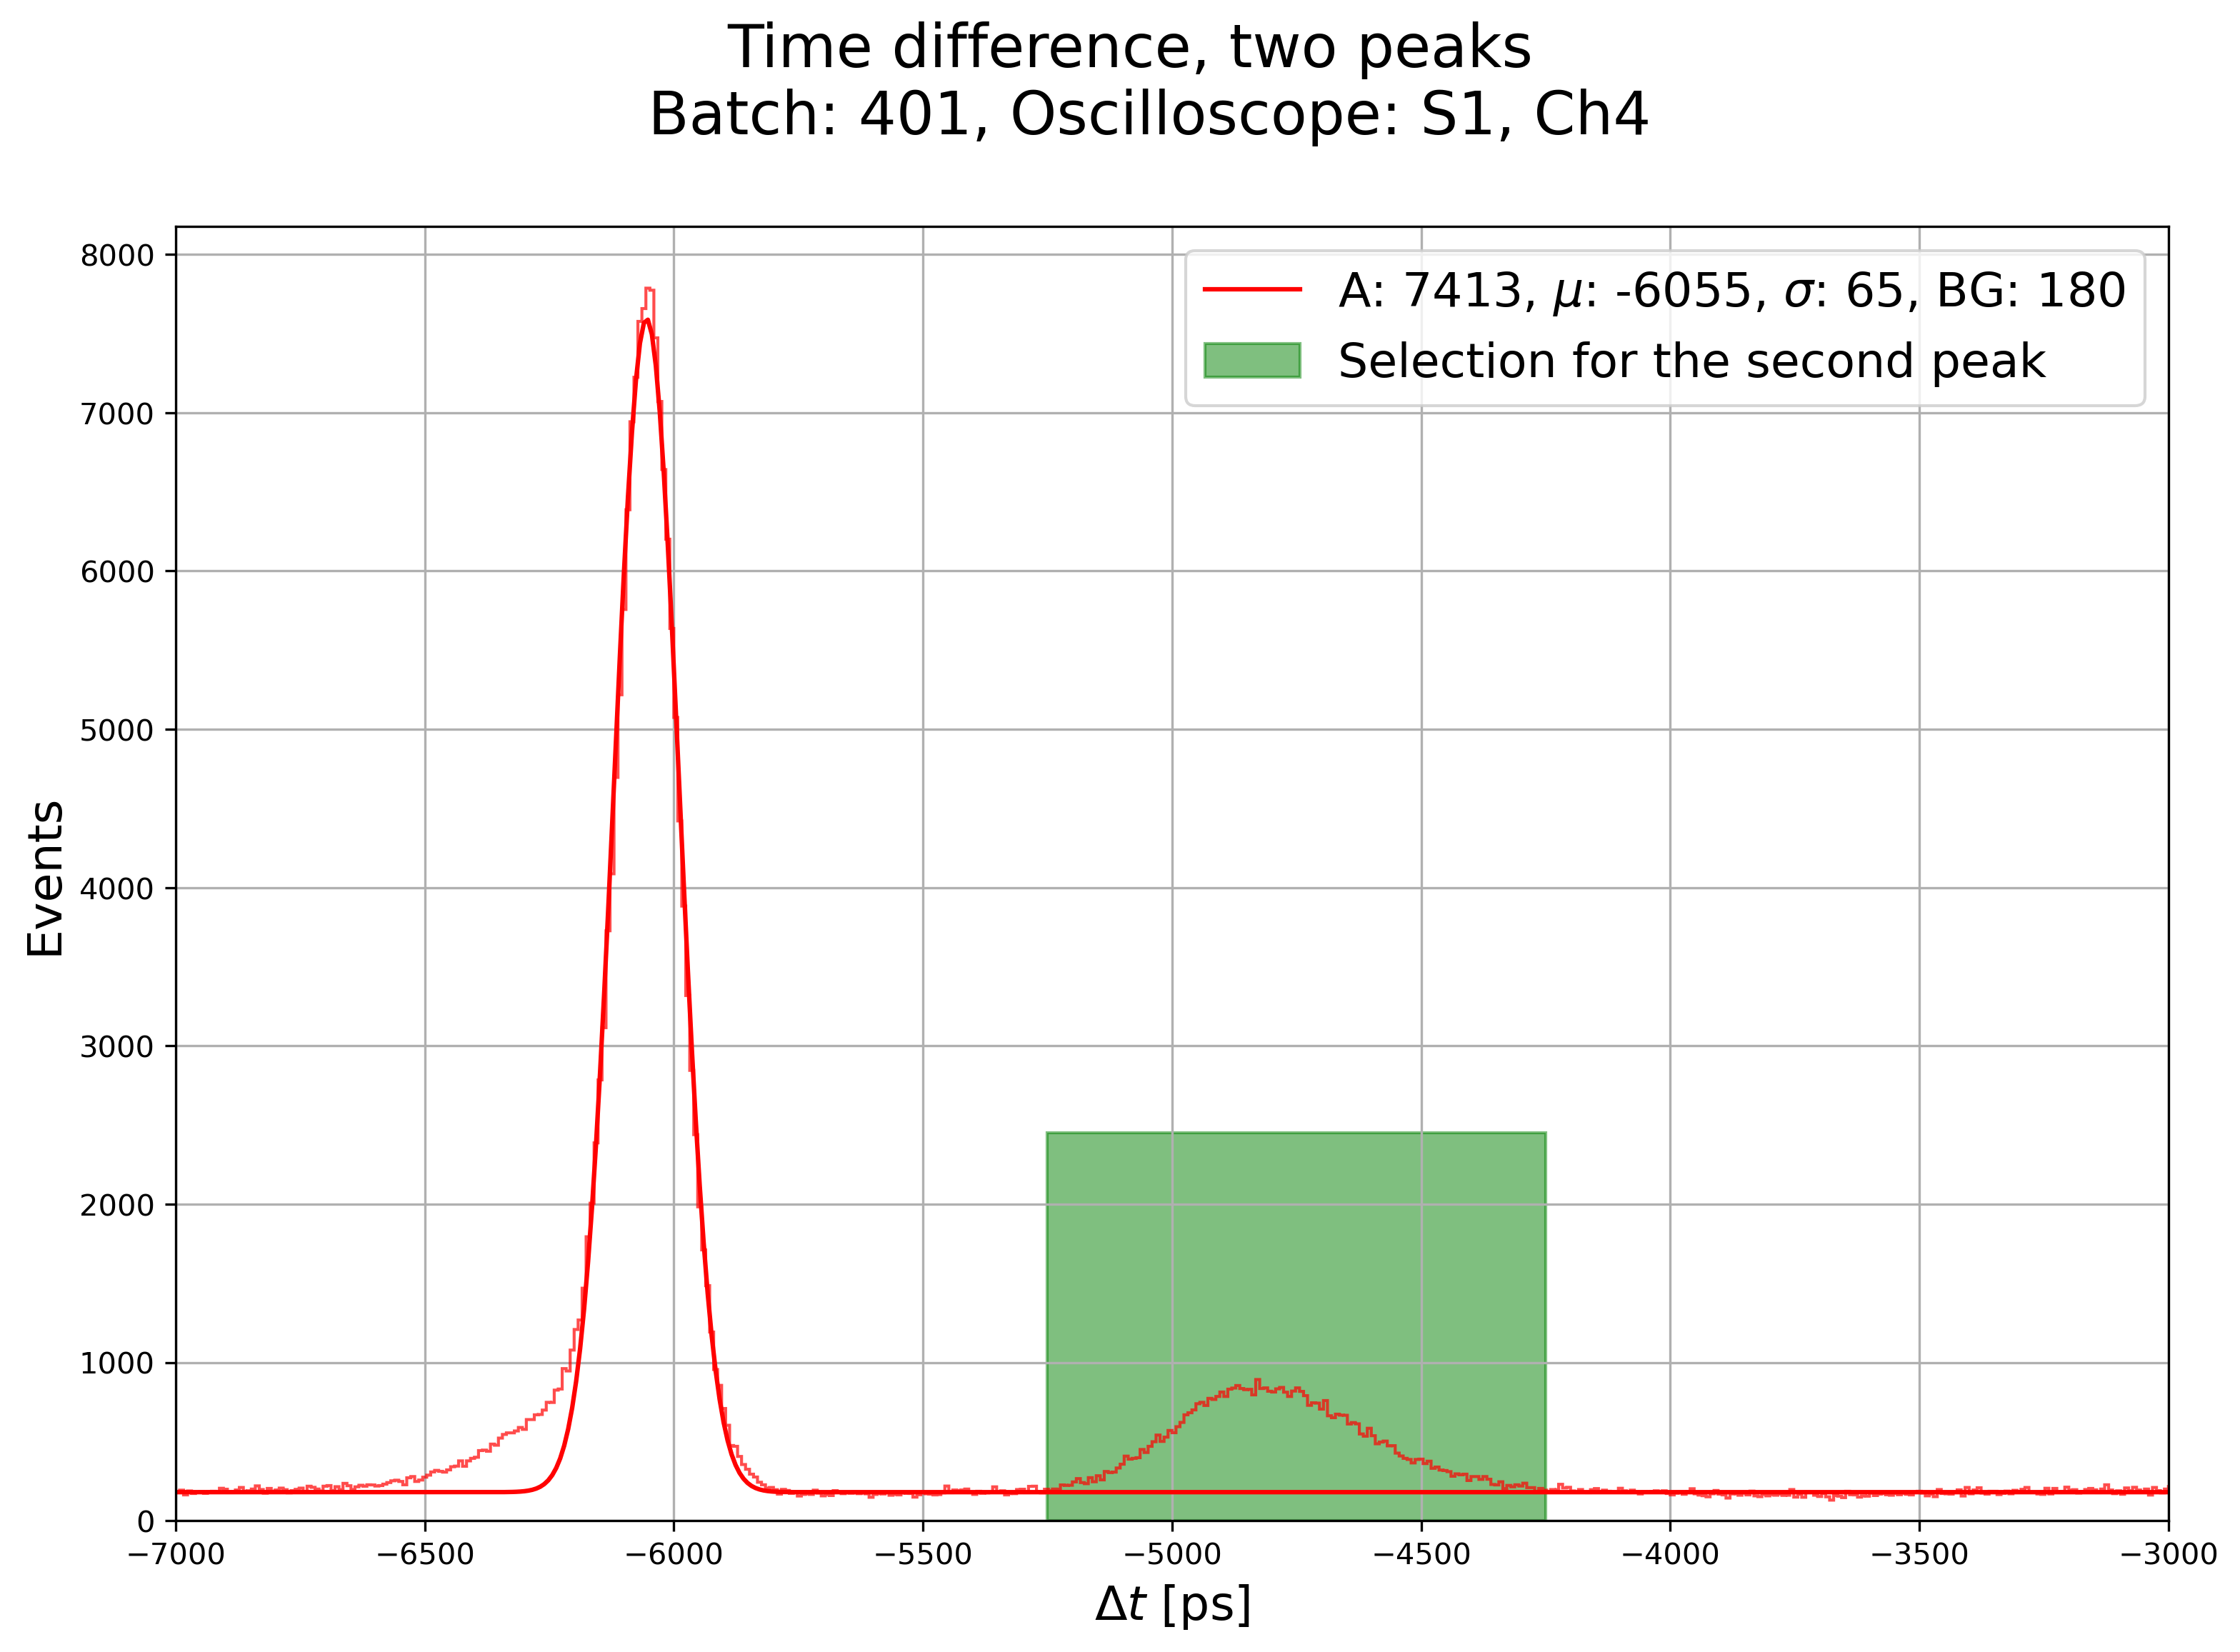

In [30]:
fig, axes = plt.subplots(figsize=(12,8),nrows=1, ncols=1, dpi=300)

for dut in [3]:
    window_limit = 20e3
    window_fit = np.logical_and((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])> -window_limit,
                               (df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])< +window_limit)
    
    hist, my_bins,_,_,_ = plot_histogram((df[f"timeCFD20_{dut}"].loc[window_fit]-df["timeCFD50_0"].loc[window_fit]),
                                         bins=5000, color=colormap[dut], linewidth=1, alpha=0.7,
                                         fig_ax=(fig,axes))

    bins_centers = (my_bins[:-1]+my_bins[1:])/2
    initial_param = (np.max(hist),bins_centers[np.argmax(hist)],100,np.average(hist))
    param, covar = curve_fit(my_gauss, bins_centers, hist, p0=initial_param)#, sigma=hist**0.5, absolute_sigma=True)
#     print(f"Fit parameters: {param}")
    axes.plot(bins_centers, my_gauss(bins_centers,*param), color=colormap[dut])
    number_of_sigmas = 3
    left_base, right_base = param[1]-number_of_sigmas*param[2], param[1]+number_of_sigmas*param[2]
#     axes.vlines(left_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.', label=f'{number_of_sigmas} $\sigma$ interval')
#     axes.vlines(right_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.')
    ### add units to the parameters
    axes.plot([],[],color=colormap[dut], label="A: %.0f, $\mu$: %.0f, $\sigma$: %.0f, BG: %.0f" %(param[0],param[1], param[2], param[3])) # only two decimals

    ### this lines are just to visually find an interval on which to study interesting features
    
interesting_interval = (-5250, -4250)
axes.axvspan(interesting_interval[0], interesting_interval[1], ymin=0, ymax=0.3, alpha=0.5, color='green', label='Selection for the second peak')

axes.set_xlabel(f"$\Delta t$ [ps]", fontsize=16)
axes.set_ylabel("Events", fontsize=16)

xlim = (-7e3,-3e3)
# xlim = (-10e3,0)
axes.set_xlim(xlim)
axes.legend(fontsize=16)

fig.suptitle(f"Time difference, two peaks \
\n Batch: {this_batch}, Oscilloscope: {S}, Ch{dut+1}",y=1, fontsize=20)

if SAVE:
    fig.savefig(os.path.join(pres_path, f"time_difference_{this_batch}_{S}_one_dut_with_second_peak.png"), bbox_inches="tight")

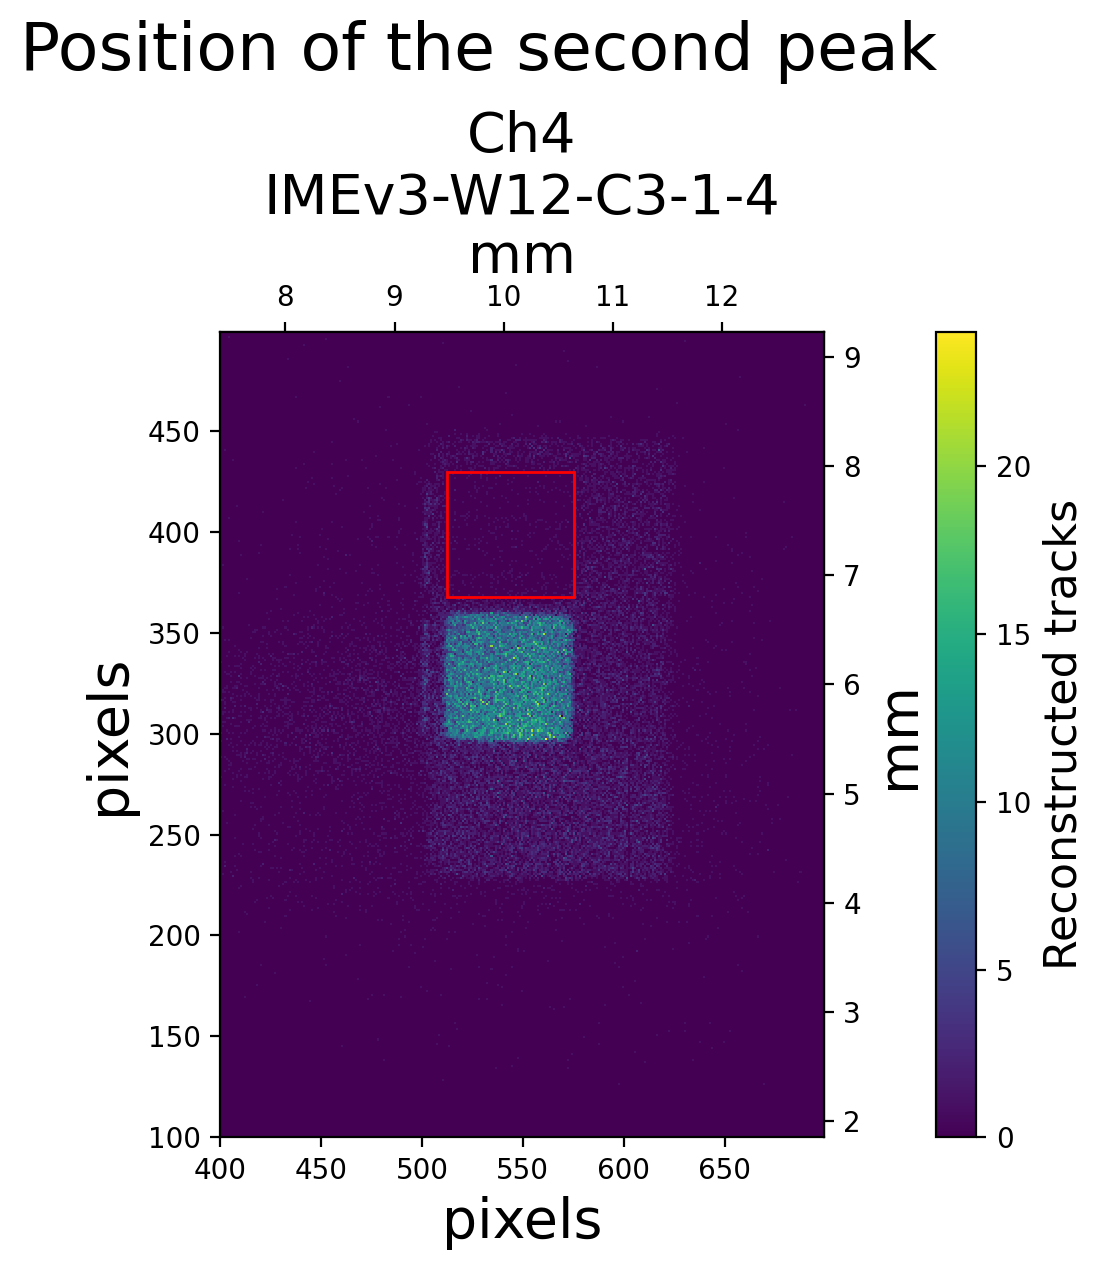

In [31]:
second_peak_cut = [np.logical_and((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])> interesting_interval[0],
                               (df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])< interesting_interval[1]) for dut in [1,2,3]]

fig, ax = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=bins1, n_DUT=[3], mask=second_peak_cut,
                    savefig=False, savefig_path=pres_path, savefig_details=f" position of second peak",fmt='png')
fig.suptitle("Position of the second peak", fontsize=24, y=1.05)

ax[0].add_patch(rectangle_from_geometry_cut(**geo_infos[2]))

if SAVE:
    fig.savefig(os.path.join(pres_path, f"2D Tracks {this_batch}_{S}_one_dut_with_second_peak.png"), bbox_inches="tight")


## Plots of the wide bottom of the gaussian  (!!)
I could also use this to find what is the collected charge of the particles that go thru the edge

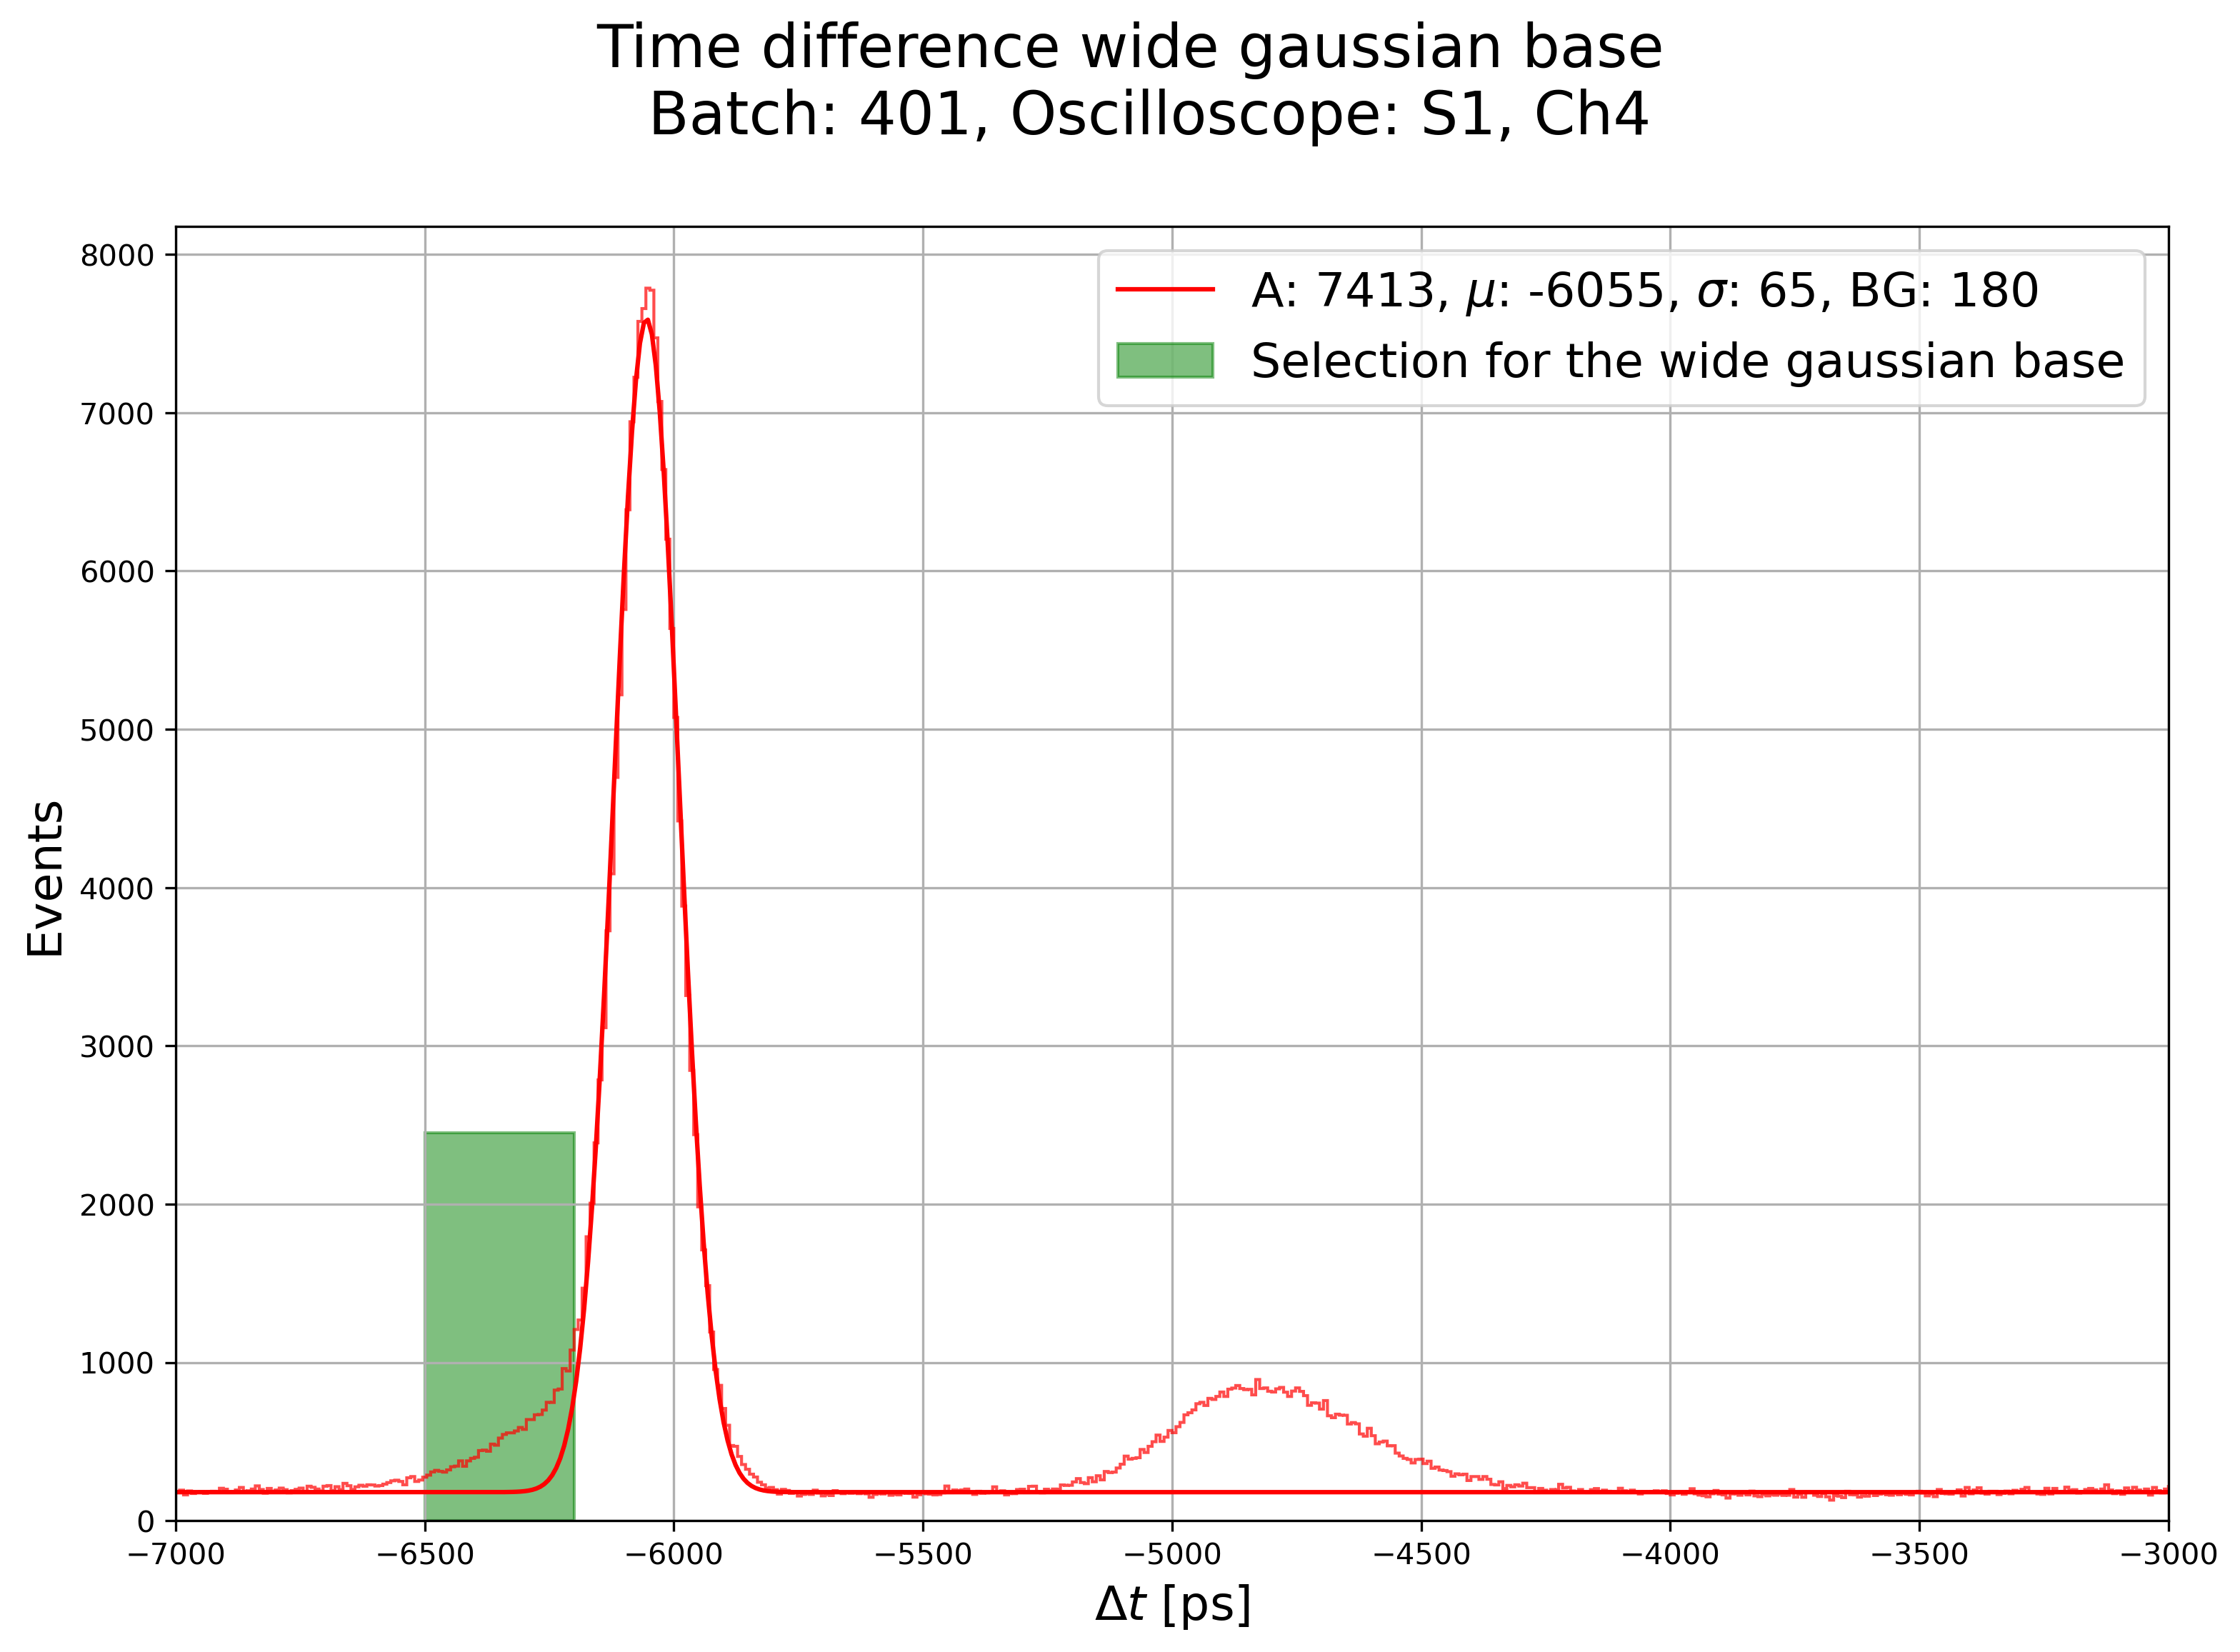

In [32]:
fig, axes = plt.subplots(figsize=(12,8),nrows=1, ncols=1, dpi=300)

for dut in [3]:
    window_limit = 20e3
    window_fit = np.logical_and((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])> -window_limit,
                               (df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])< +window_limit)
    
    hist, my_bins,_,_,_ = plot_histogram((df[f"timeCFD20_{dut}"].loc[window_fit]-df["timeCFD50_0"].loc[window_fit]),
                                         bins=5000, color=colormap[dut], linewidth=1, alpha=0.7,
                                         fig_ax=(fig,axes))

    bins_centers = (my_bins[:-1]+my_bins[1:])/2
    initial_param = (np.max(hist),bins_centers[np.argmax(hist)],100,np.average(hist))
    param, covar = curve_fit(my_gauss, bins_centers, hist, p0=initial_param)#, sigma=hist**0.5, absolute_sigma=True)
    axes.plot(bins_centers, my_gauss(bins_centers,*param), color=colormap[dut])
    
    number_of_sigmas = 3
    left_base, right_base = param[1]-number_of_sigmas*param[2], param[1]+number_of_sigmas*param[2]
#     axes.vlines(left_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.', label=f'{number_of_sigmas} $\sigma$ interval')
#     axes.vlines(right_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.')
#     ### add units to the parameters
    axes.plot([],[],color=colormap[dut], label="A: %.0f, $\mu$: %.0f, $\sigma$: %.0f, BG: %.0f" %(param[0],param[1], param[2], param[3])) # only two decimals

    ### this lines are just to visually find an interval on which to study interesting features
interesting_interval = (-6500, -6200)
axes.axvspan(*interesting_interval, ymin=0, ymax=0.3, alpha=0.5, color='green', label='Selection for the wide gaussian base')

axes.set_xlabel(f"$\Delta t$ [ps]", fontsize=16)
axes.set_ylabel("Events", fontsize=16)

xlim = (-7e3,-3e3)
# xlim = (-10e3,0)
axes.set_xlim(xlim)
axes.legend(fontsize=16)

fig.suptitle(f"Time difference wide gaussian base \
\n Batch: {this_batch}, Oscilloscope: {S}, Ch{dut+1}",y=1, fontsize=20)

if SAVE:
    fig.savefig(os.path.join(pres_path, f"time_difference_{this_batch}_{S}_one_dut_with_wide gaussian_left.png"), bbox_inches="tight")

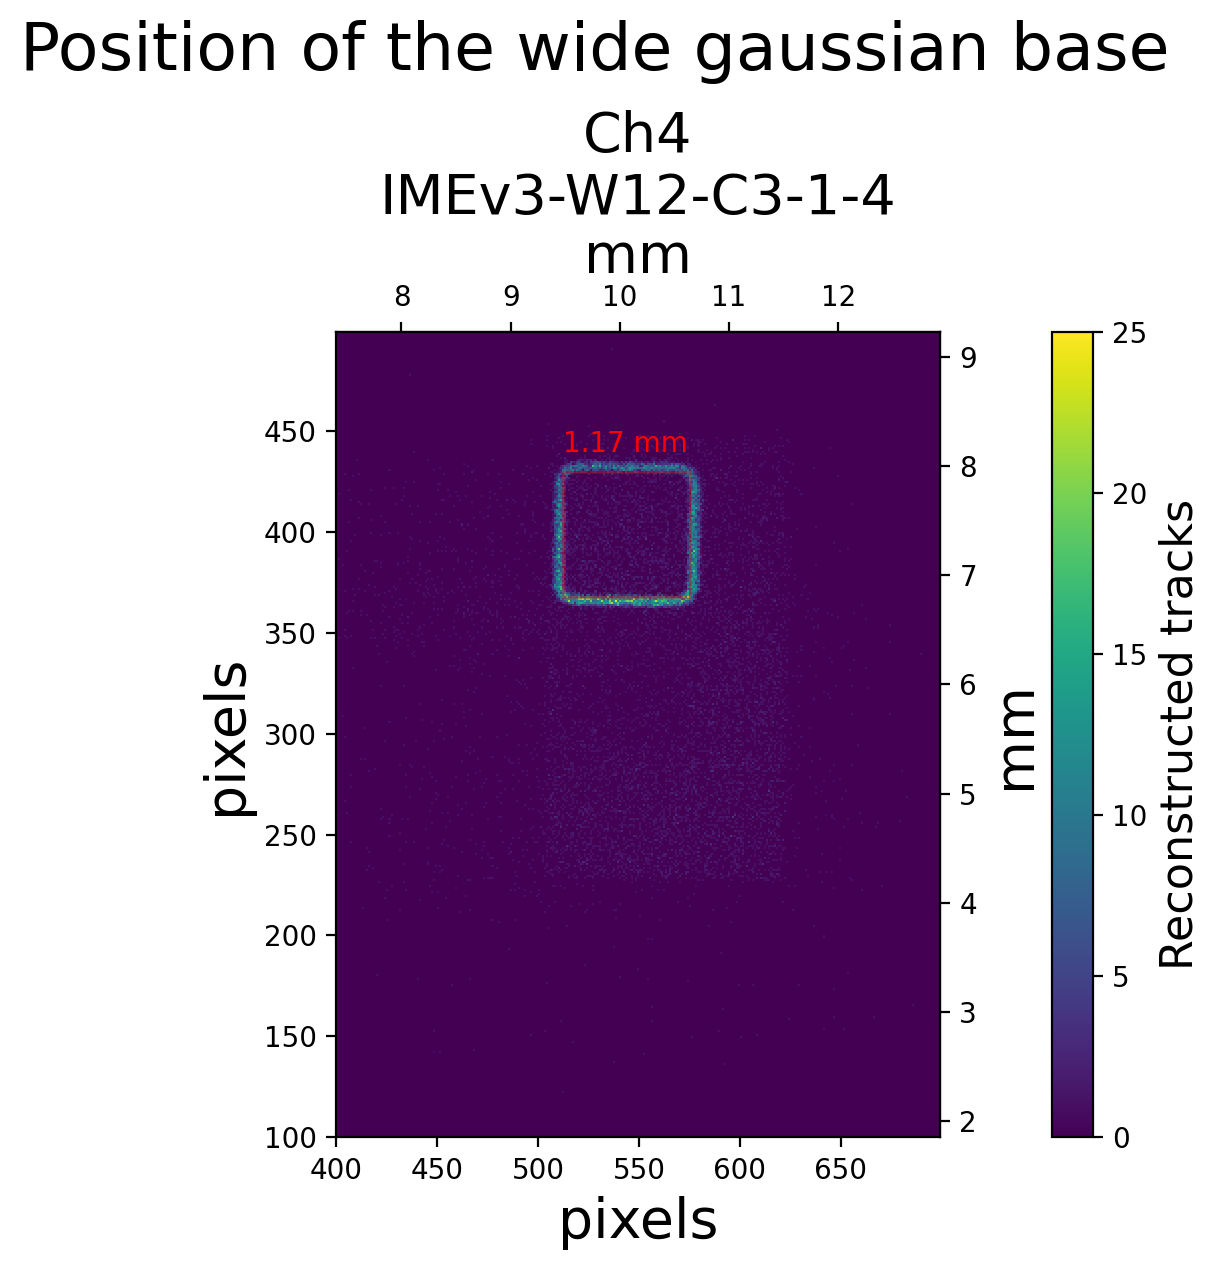

In [33]:
wide_bottom = [np.logical_and((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])> interesting_interval[0],
                               (df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])< interesting_interval[1]) for dut in [1,2,3]]

dut = 3
fig, ax = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=bins1, n_DUT=[dut], mask=wide_bottom,
                    savefig=False, savefig_path=pres_path, savefig_details=f" positions of wide gaussian base_left", fmt='png')

fig.suptitle("Position of the wide gaussian base", fontsize=24, y=1.05)
ax[0].add_patch(rectangle_from_geometry_cut(**geo_infos[2], alpha=.3))
sensor_size = (geo_infos[dut-1]['right_edge']-geo_infos[dut-1]['left_edge'])*PIXEL_SIZE
ax[0].text(x=geo_infos[dut-1]['left_edge'], y=geo_infos[dut-1]['top_edge']+10, s='%.2f mm'%sensor_size, color='r')
    
if SAVE:
    fig.savefig(os.path.join(pres_path, f"2D Tracks {this_batch}_{S}_one_dut_with_wide_gaussian_base.png"), bbox_inches="tight")


#### Now plot the charge of these events

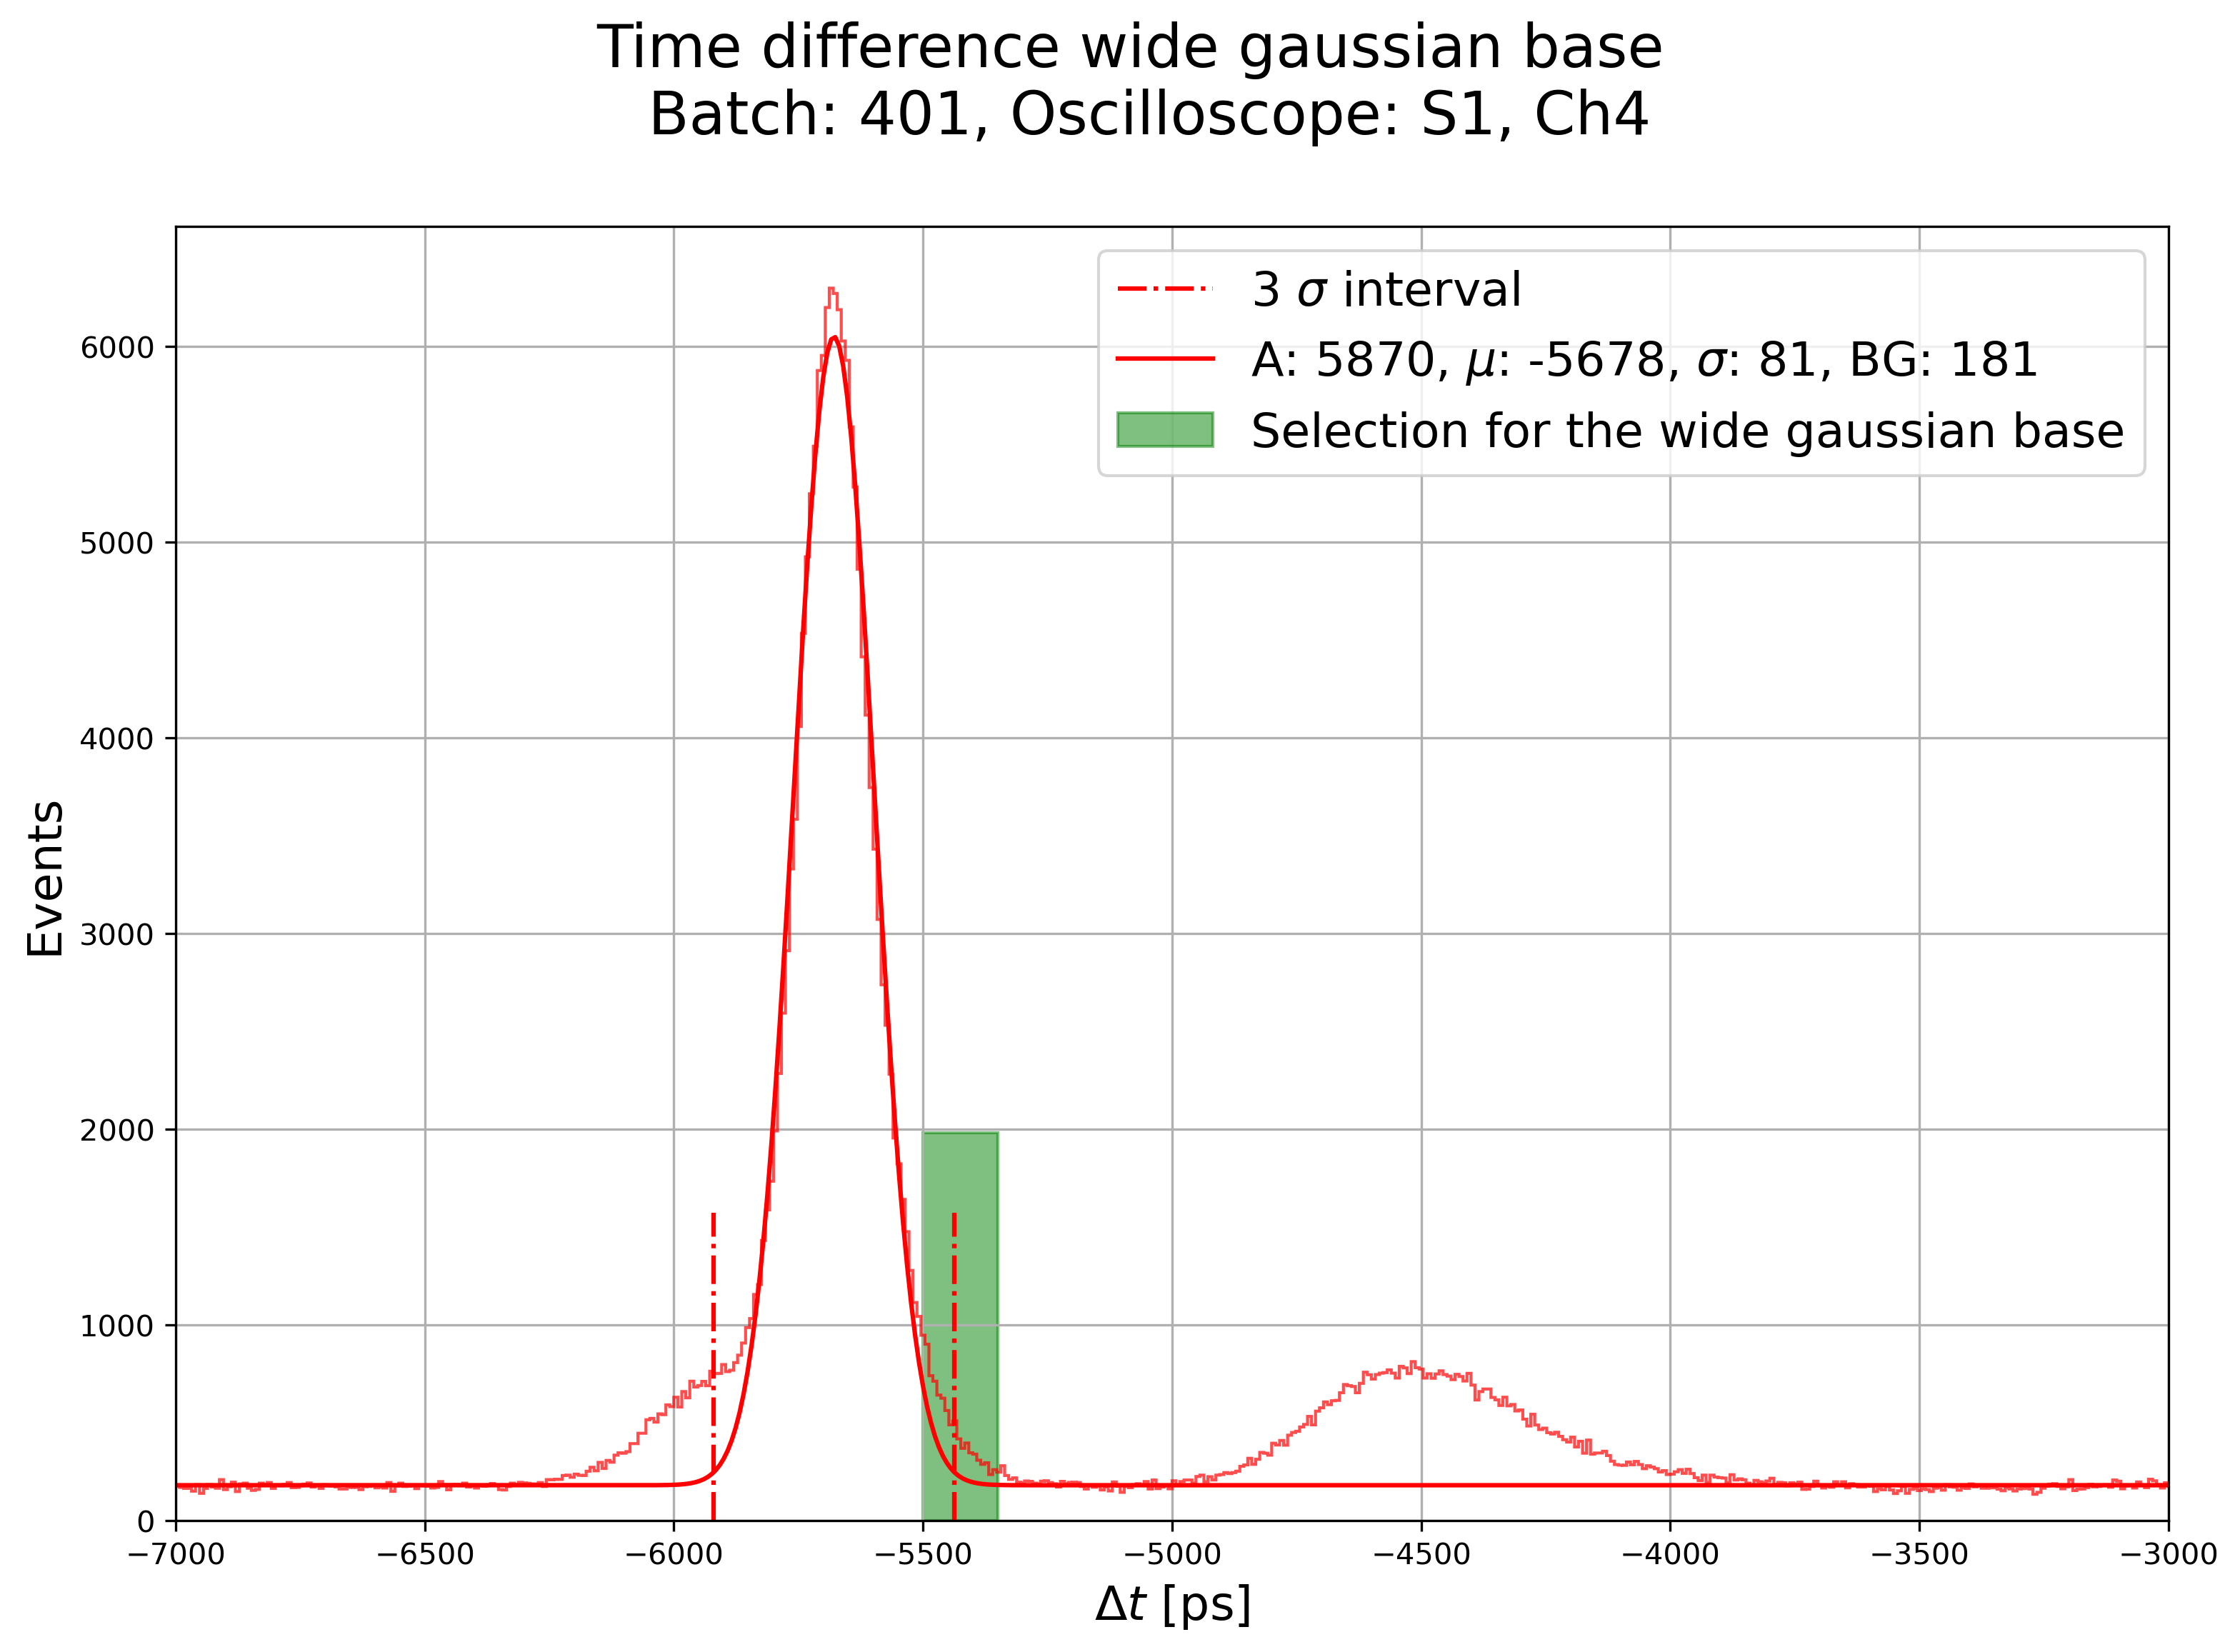

In [34]:
### now same thing but right side, this one is not necessary because the
### RIGHT SIDE OF THE ASYMMETRY IS DUE TO THE CFD VALUES
### 

fig, axes = plt.subplots(figsize=(12,8),nrows=1, ncols=1, dpi=300)

for dut in [3]:
    window_limit = 20e3
    ### OLD ONE WITH DUT:CDF50 AND MCP:CFD20
    window_fit = np.logical_and((df[f"timeCFD50_{dut}"]-df["timeCFD20_0"])> -window_limit,
                               (df[f"timeCFD50_{dut}"]-df["timeCFD20_0"])< +window_limit)
    
    hist, my_bins,_,_,_ = plot_histogram((df[f"timeCFD50_{dut}"].loc[window_fit]-df["timeCFD20_0"].loc[window_fit]),
                                         bins=5000, color=colormap[dut], linewidth=1, alpha=0.7,
                                         fig_ax=(fig,axes))
    
    ### NEW ONE WITH DUT:CFD20 AND MCP:CFD50
#     window_fit = np.logical_and((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])> -window_limit,
#                                (df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])< +window_limit)
    
#     hist, my_bins,_,_,_ = plot_histogram((df[f"timeCFD20_{dut}"].loc[window_fit]-df["timeCFD50_0"].loc[window_fit]),
#                                          bins=5000, color=colormap[dut], linewidth=1, alpha=0.7,
#                                          fig_ax=(fig,axes))

    bins_centers = (my_bins[:-1]+my_bins[1:])/2
    initial_param = (np.max(hist),bins_centers[np.argmax(hist)],100,np.average(hist))
    param, covar = curve_fit(my_gauss, bins_centers, hist, p0=initial_param)#, sigma=hist**0.5, absolute_sigma=True)
    axes.plot(bins_centers, my_gauss(bins_centers,*param), color=colormap[dut])
    
    number_of_sigmas = 3
    left_base, right_base = param[1]-number_of_sigmas*param[2], param[1]+number_of_sigmas*param[2]
    axes.vlines(left_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.', label=f'{number_of_sigmas} $\sigma$ interval')
    axes.vlines(right_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.')
    ### add units to the parameters
    axes.plot([],[],color=colormap[dut], label="A: %.0f, $\mu$: %.0f, $\sigma$: %.0f, BG: %.0f" %(param[0],param[1], param[2], param[3])) # only two decimals

    ### this lines are just to visually find an interval on which to study interesting features
interesting_interval = (-5500, -5350)

axes.axvspan(*interesting_interval, ymin=0, ymax=0.3, alpha=0.5, color='green', label='Selection for the wide gaussian base')

axes.set_xlabel(f"$\Delta t$ [ps]", fontsize=16)
axes.set_ylabel("Events", fontsize=16)

xlim = (-7e3,-3e3)
# xlim = (-10e3,0)
axes.set_xlim(xlim)
axes.legend(fontsize=16)

fig.suptitle(f"Time difference wide gaussian base \
\n Batch: {this_batch}, Oscilloscope: {S}, Ch{dut+1}",y=1, fontsize=20)

if SAVE:
    fig.savefig(os.path.join(pres_path, f"time_difference_{this_batch}_{S}_one_dut_with_wide gaussian_right.png"), bbox_inches="tight")

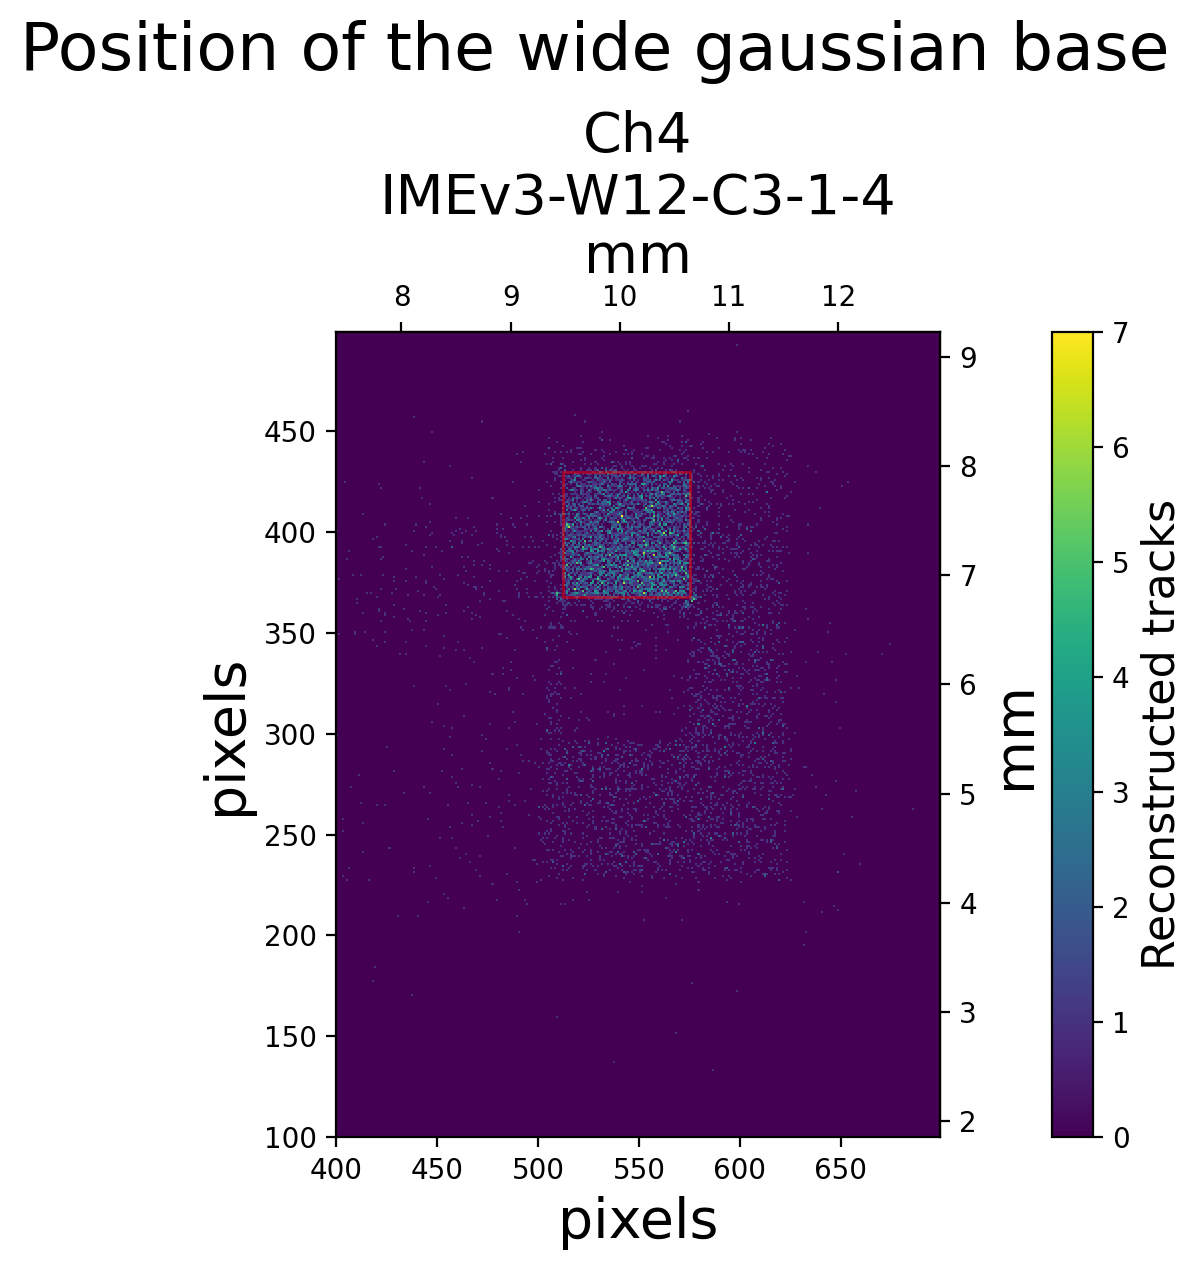

In [36]:
### on the RIGHT side
### OLD ONE WITH DUT:CDF50 AND MCP:CFD20

wide_bottom = [np.logical_and((df[f"timeCFD50_{dut}"]-df["timeCFD20_0"])> interesting_interval[0],
                               (df[f"timeCFD50_{dut}"]-df["timeCFD20_0"])< interesting_interval[1]) for dut in [1,2,3]]

fig, ax = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=bins1, n_DUT=[3], mask=wide_bottom,
                    savefig=SAVE, savefig_path=pres_path, savefig_details=f" positions of wide gaussian base_right", fmt='png')

fig.suptitle("Position of the wide gaussian base", fontsize=24, y=1.05)
ax[0].add_patch(rectangle_from_geometry_cut(**geo_infos[2], alpha=.5))

### Same thing but now applying sensor area cut first


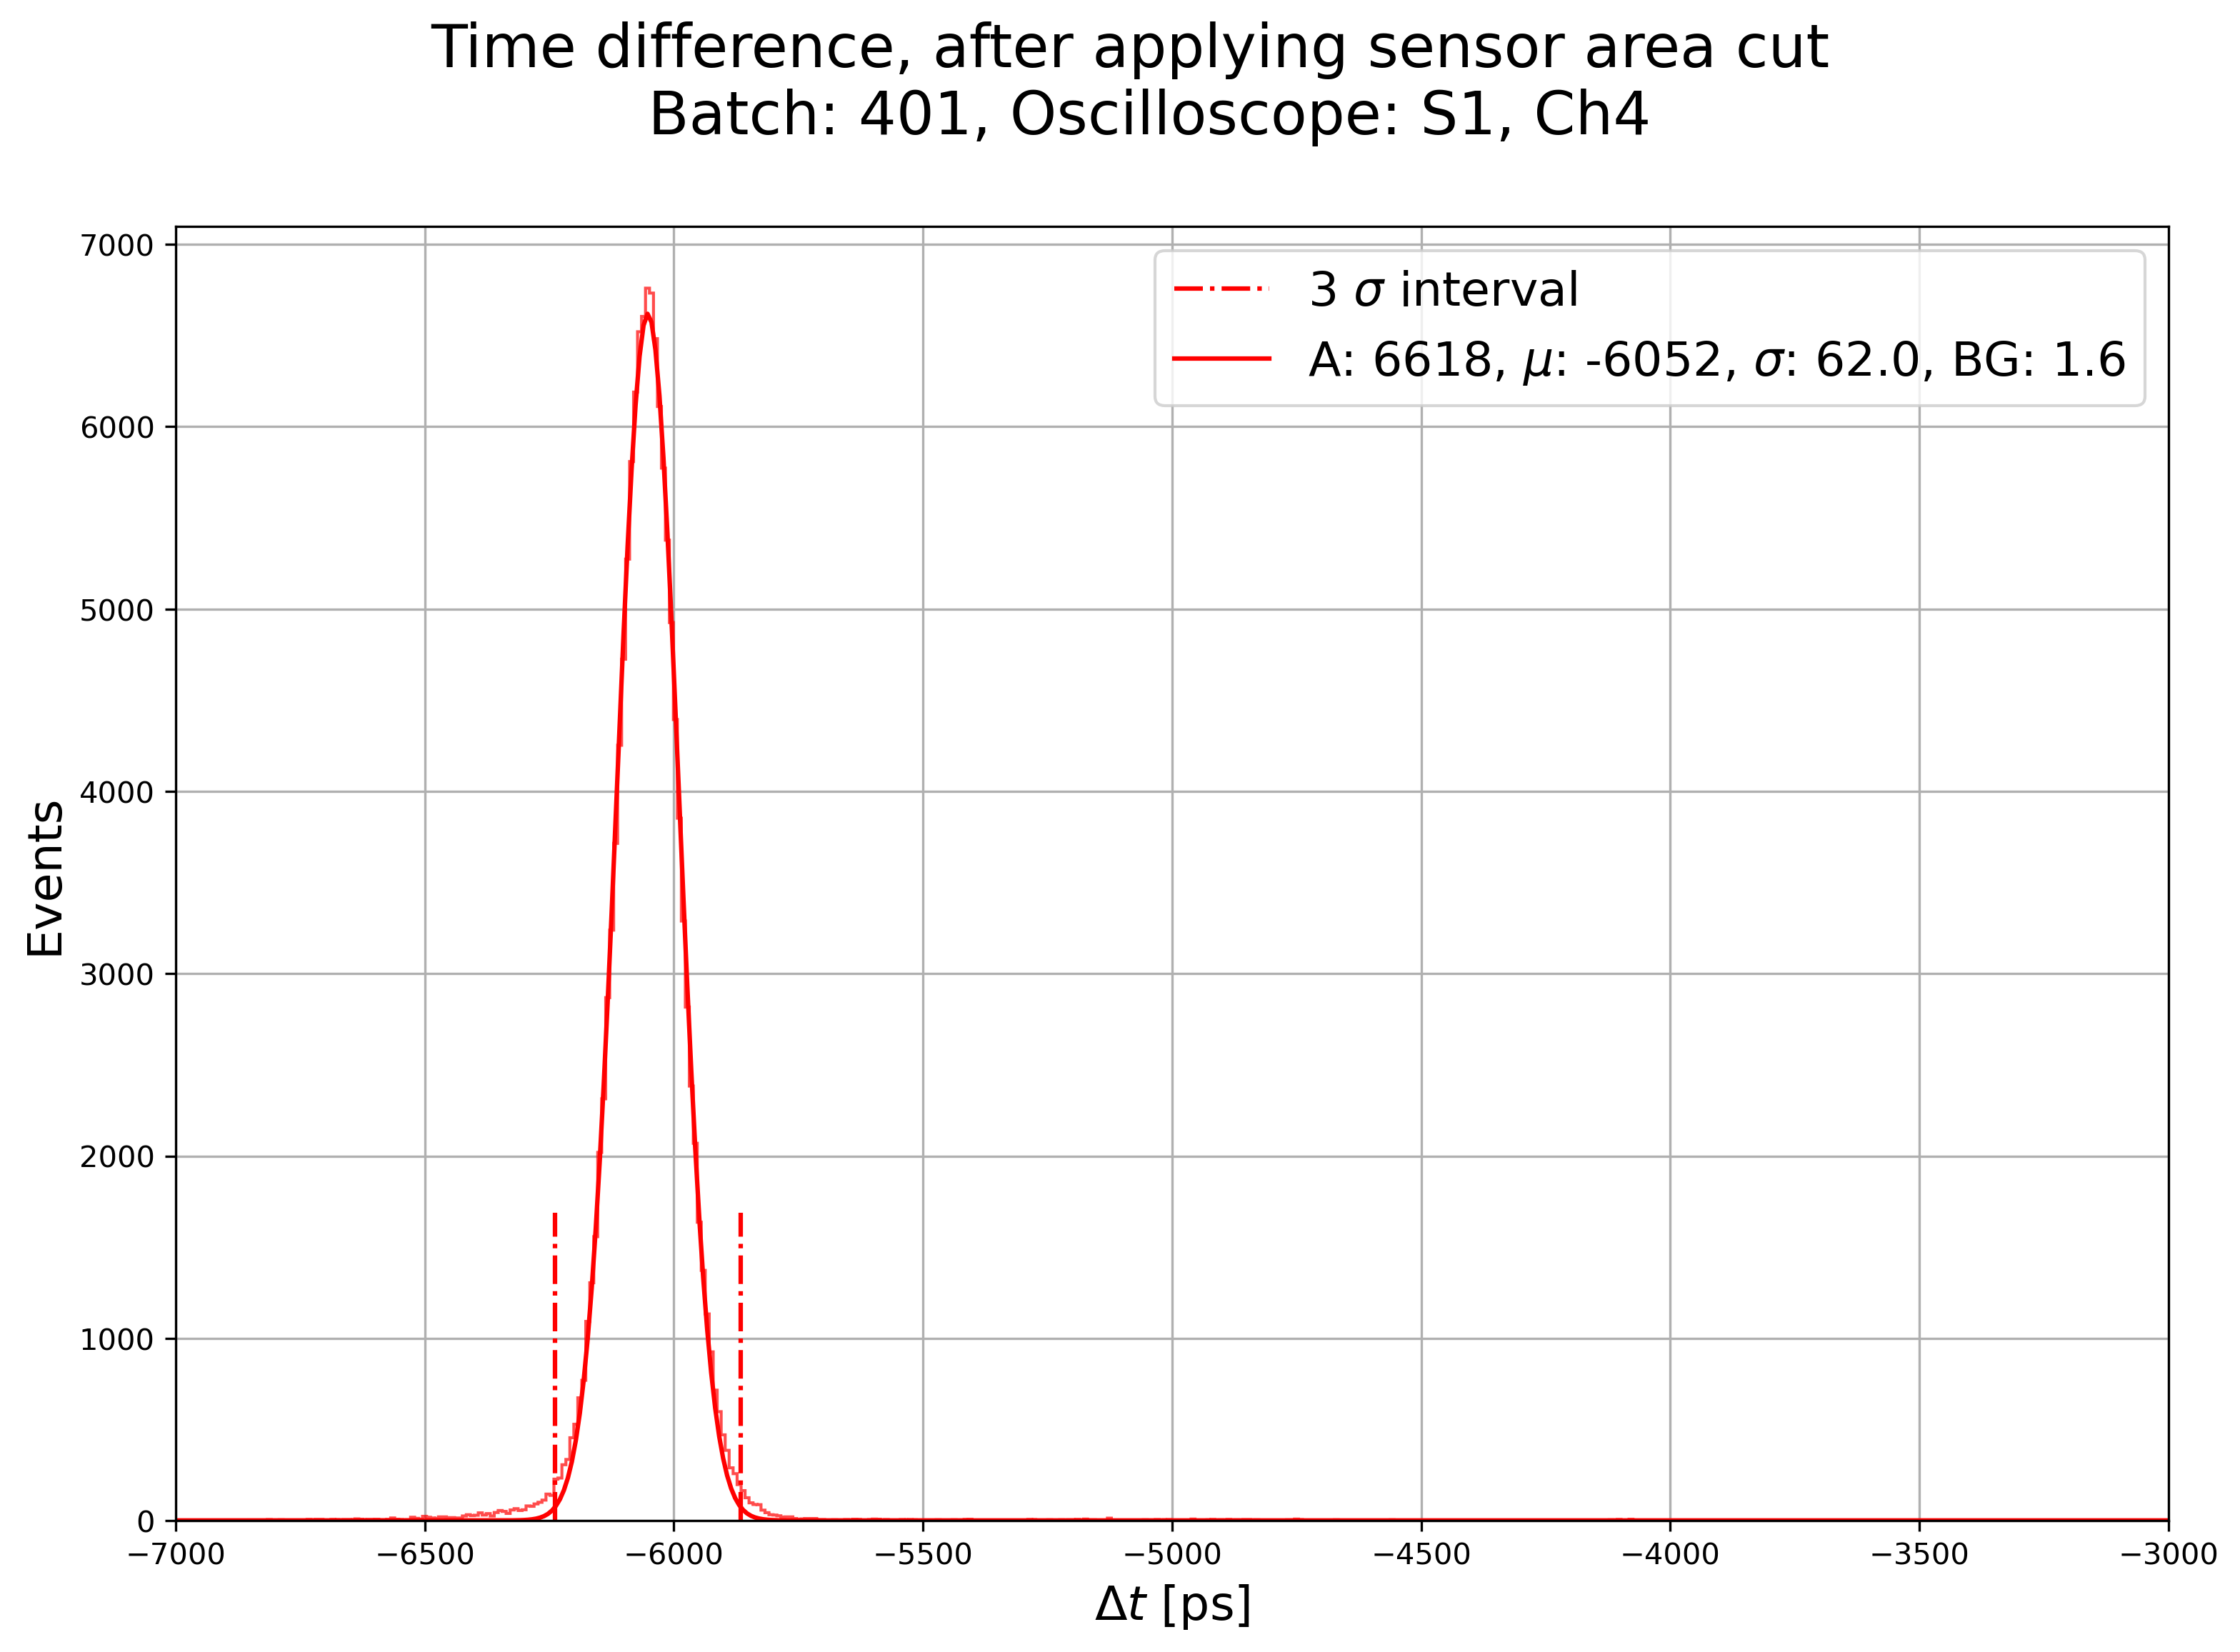

In [37]:
fig, axes = plt.subplots(figsize=(12,8),nrows=1, ncols=1, dpi=300)
# pulse_geo_cuts = [np.logical_and(geo_cuts[dut-1], pulse_cuts[dut-1]) for dut in DUTs]

for dut in DUTs:
    window_limit = 20e3
    window_fit = np.logical_and((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])> -window_limit,
                               (df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])< +window_limit)
    dut_cut = np.logical_and(window_fit, geo_cuts[dut-1])
    
    hist, my_bins,_,_,_ = plot_histogram((df[f"timeCFD20_{dut}"].loc[dut_cut]-df["timeCFD50_0"].loc[dut_cut]),
                                         bins=5000, color=colormap[dut], linewidth=1, alpha=0.7,
                                         fig_ax=(fig,axes))

    bins_centers = (my_bins[:-1]+my_bins[1:])/2
    initial_param = (np.max(hist),bins_centers[np.argmax(hist)],100,np.average(hist))
    param, covar = curve_fit(my_gauss, bins_centers, hist, p0=initial_param)#, sigma=hist**0.5, absolute_sigma=True)
#     print(f"Fit parameters: {param}")
    axes.plot(bins_centers, my_gauss(bins_centers,*param), color=colormap[dut])
    number_of_sigmas = 3
    left_base, right_base = param[1]-number_of_sigmas*param[2], param[1]+number_of_sigmas*param[2]
    axes.vlines(left_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.', label=f'{number_of_sigmas} $\sigma$ interval')
    axes.vlines(right_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.')
    ### add units to the parameters
    axes.plot([],[],color=colormap[dut], label="A: %.0f, $\mu$: %.0f, $\sigma$: %.1f, BG: %.1f" %(param[0],param[1], param[2], param[3])) # only two decimals

axes.set_xlabel(f"$\Delta t$ [ps]", fontsize=16)
axes.set_ylabel("Events", fontsize=16)

xlim = (-7e3,-3e3)
# xlim = (-10e3,0)
axes.set_xlim(xlim)
axes.legend(fontsize=16)

fig.suptitle(f"Time difference, after applying sensor area cut \
\n Batch: {this_batch}, Oscilloscope: {S}, Ch{dut+1}",y=1, fontsize=20)

if SAVE:
    fig.savefig(os.path.join(pres_path, f"time_difference_{this_batch}_{S}_zoomed_and_gauss_fit_with_cuts.png"), bbox_inches="tight")

### Now trying only the central 0.5x0.5 mm²
Basically no difference

In [38]:
central_sensor_area_cuts = [geometry_mask(df, DUT_number=dut, bins=bins1, bins_find_min='rice', only_select='center', use='pulseheight')[0] for dut in [1,2,3]]
central_sensor_area_info = [geometry_mask(df, DUT_number=dut, bins=bins1, bins_find_min='rice', only_select='center', use='pulseheight')[1] for dut in [1,2,3]]

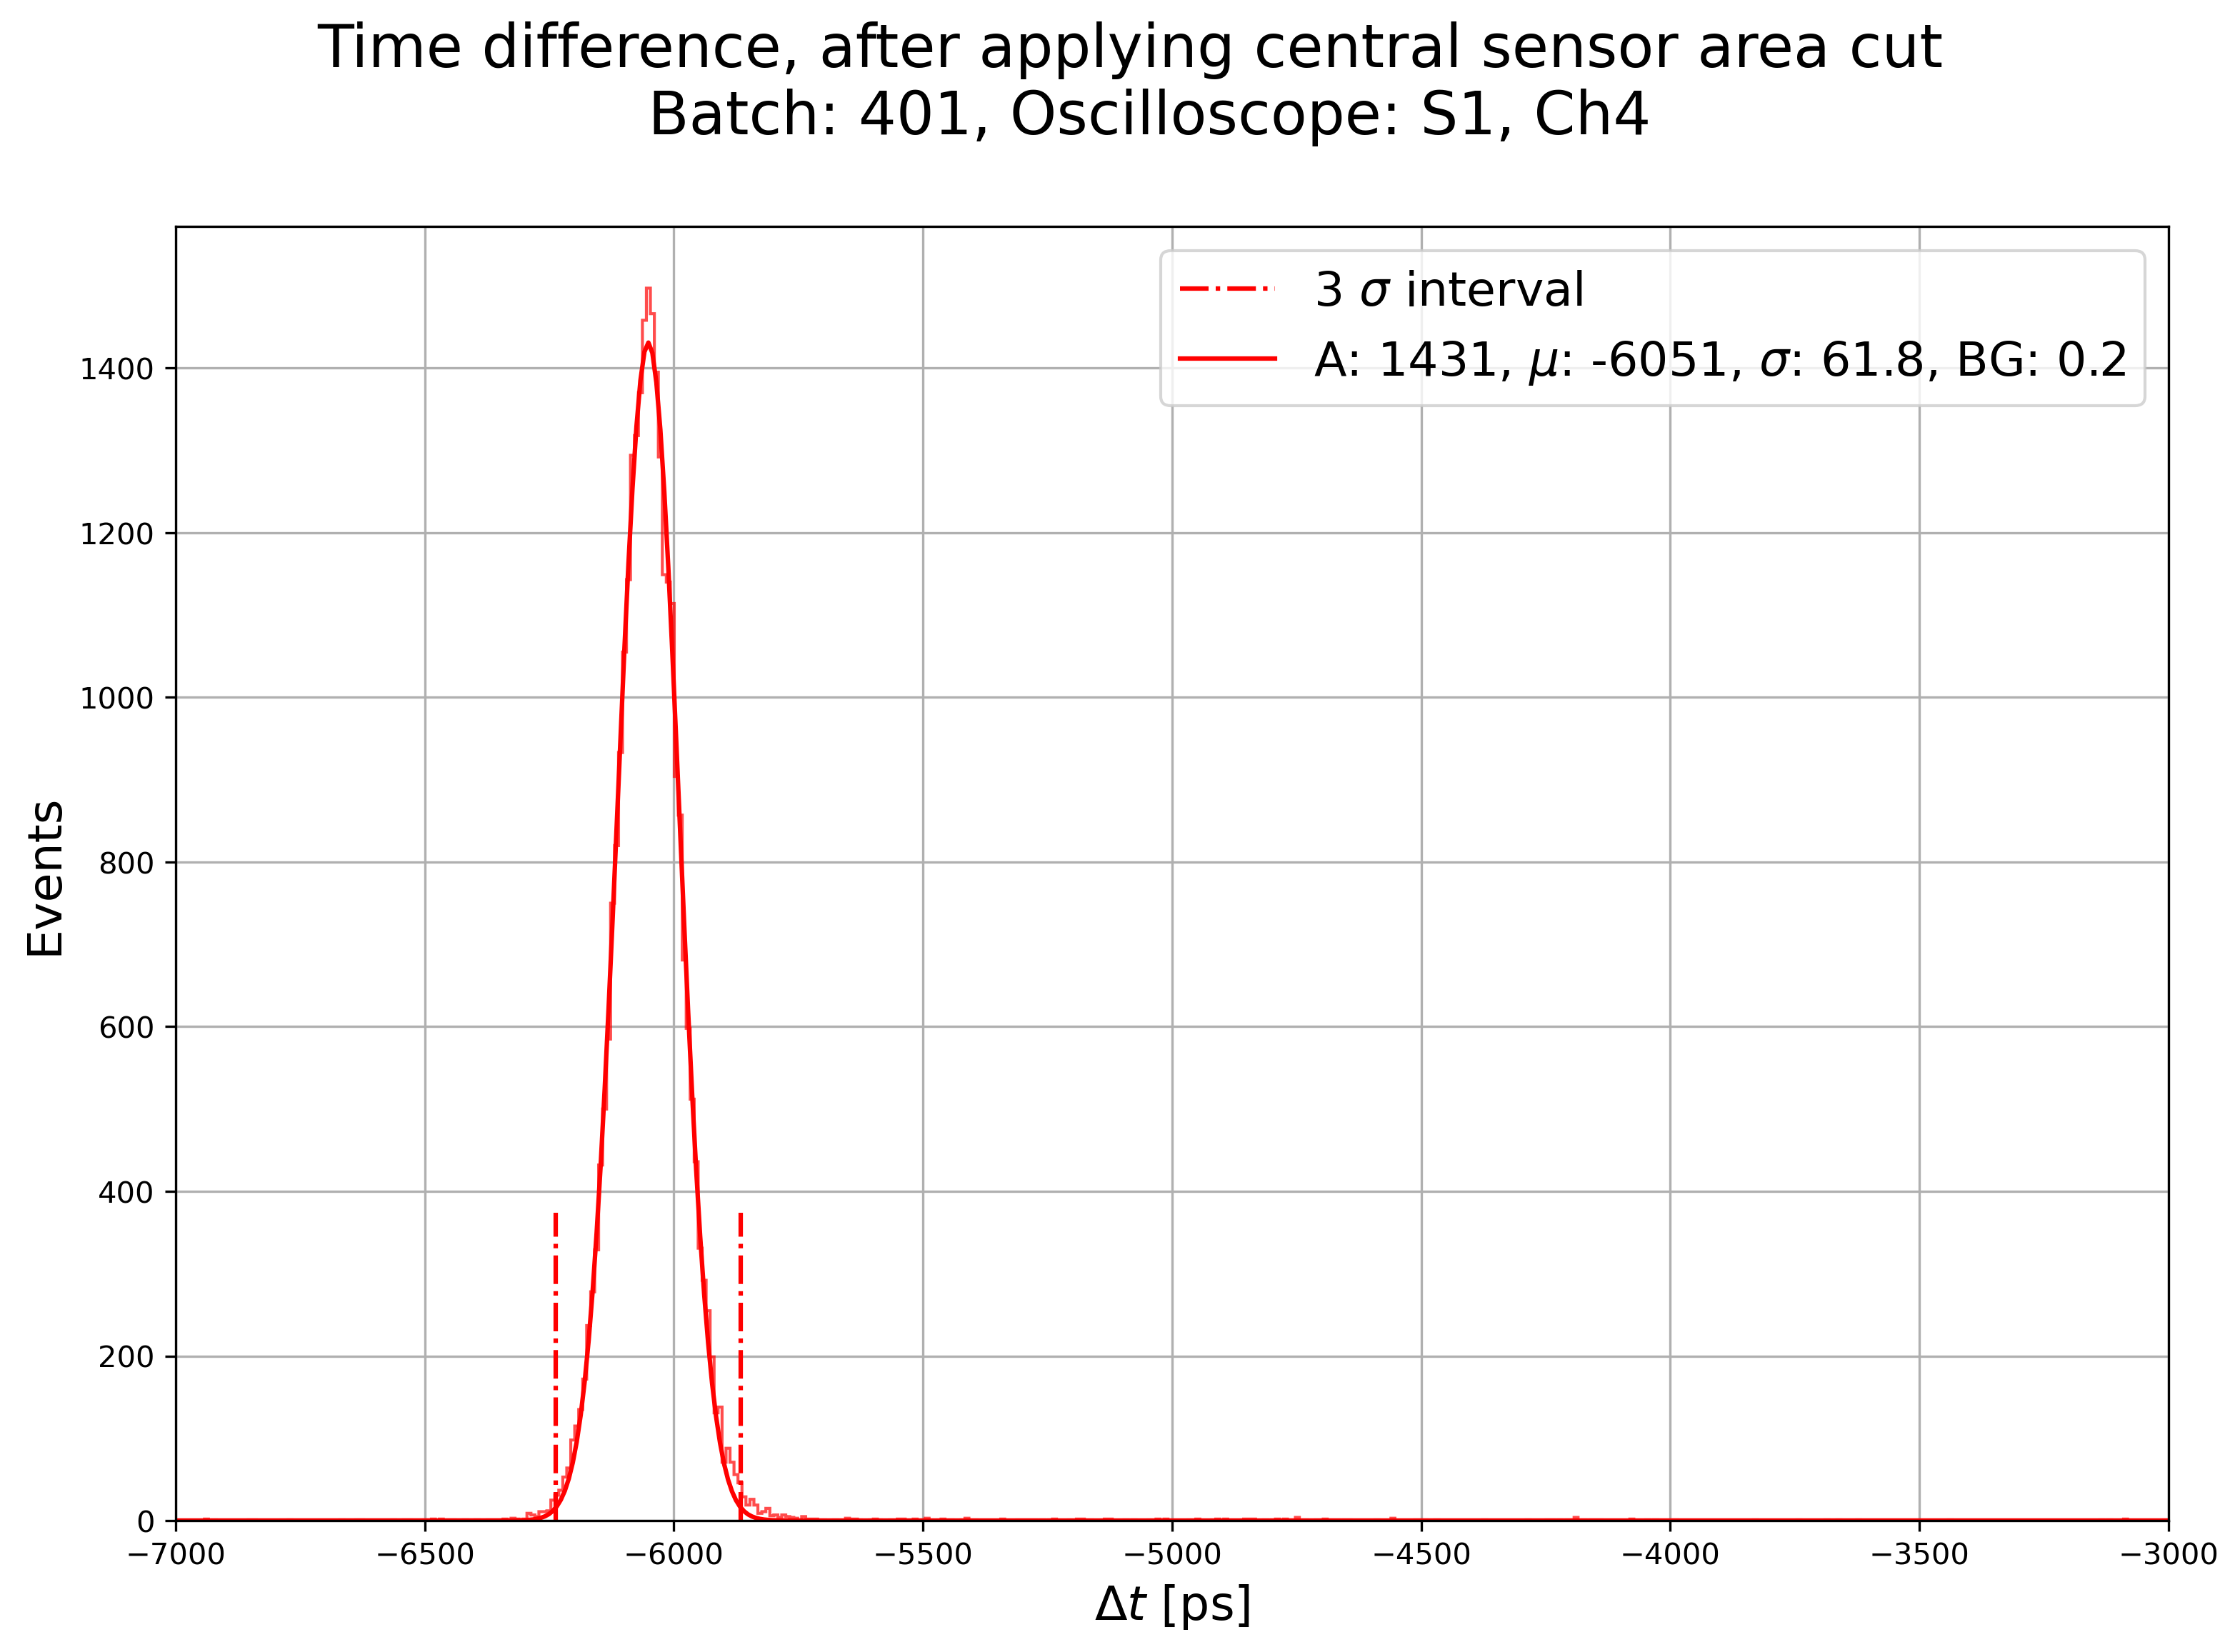

In [39]:
### ONLY CENTRAL AREA
fig, axes = plt.subplots(figsize=(12,8),nrows=1, ncols=1, dpi=300)

for dut in DUTs:
    window_limit = 20e3
    window_fit = np.logical_and((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])> -window_limit,
                               (df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])< +window_limit)
    dut_cut = np.logical_and(window_fit, central_sensor_area_cuts[dut-1])
    
    hist, my_bins,_,_,_ = plot_histogram((df[f"timeCFD20_{dut}"].loc[dut_cut]-df["timeCFD50_0"].loc[dut_cut]),
                                         bins=5000, color=colormap[dut], linewidth=1, alpha=0.7,
                                         fig_ax=(fig,axes))

    bins_centers = (my_bins[:-1]+my_bins[1:])/2
    initial_param = (np.max(hist),bins_centers[np.argmax(hist)],100,np.average(hist))
    param, covar = curve_fit(my_gauss, bins_centers, hist, p0=initial_param)#, sigma=hist**0.5, absolute_sigma=True)
    axes.plot(bins_centers, my_gauss(bins_centers,*param), color=colormap[dut])
    number_of_sigmas = 3
    left_base, right_base = param[1]-number_of_sigmas*param[2], param[1]+number_of_sigmas*param[2]
    axes.vlines(left_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.', label=f'{number_of_sigmas} $\sigma$ interval')
    axes.vlines(right_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.')
    ### add units to the parameters
    axes.plot([],[],color=colormap[dut], label="A: %.0f, $\mu$: %.0f, $\sigma$: %.1f, BG: %.1f" %(param[0],param[1], param[2], param[3])) # only two decimals

axes.set_xlabel(f"$\Delta t$ [ps]", fontsize=16)
axes.set_ylabel("Events", fontsize=16)

xlim = (-7e3,-3e3)
# xlim = (-10e3,0)
axes.set_xlim(xlim)
axes.legend(fontsize=16)

fig.suptitle(f"Time difference, after applying central sensor area cut \
\n Batch: {this_batch}, Oscilloscope: {S}, Ch{dut+1}",y=1, fontsize=20)

if SAVE:
    fig.savefig(os.path.join(pres_path, f"time_difference_{this_batch}_{S}_zoomed_and_gauss_fit_with_cuts.png"), bbox_inches="tight")

In [40]:
# fig, ax = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=bins1, n_DUT=[3], mask=time_cuts,
#                     savefig=SAVE, savefig_path=pres_path, savefig_details=f" positions of wide bottom peak",fmt='png')

parenthesis about the second/third peak in the $\Delta t$

## $\Delta t$ vs pulseHeight plot

/home/marcello/.local/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/marcello/.local/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


(<Figure size 2400x2400 with 2 Axes>,
 array([<ScatterDensityAxesSubplot:title={'center':'DUT: IMEv3-W12-C3-1-4'}, xlabel='$\\Delta t$ [ps] (DUT 3 - MCP)', ylabel='PulseHeight [mV]'>],
       dtype=object))

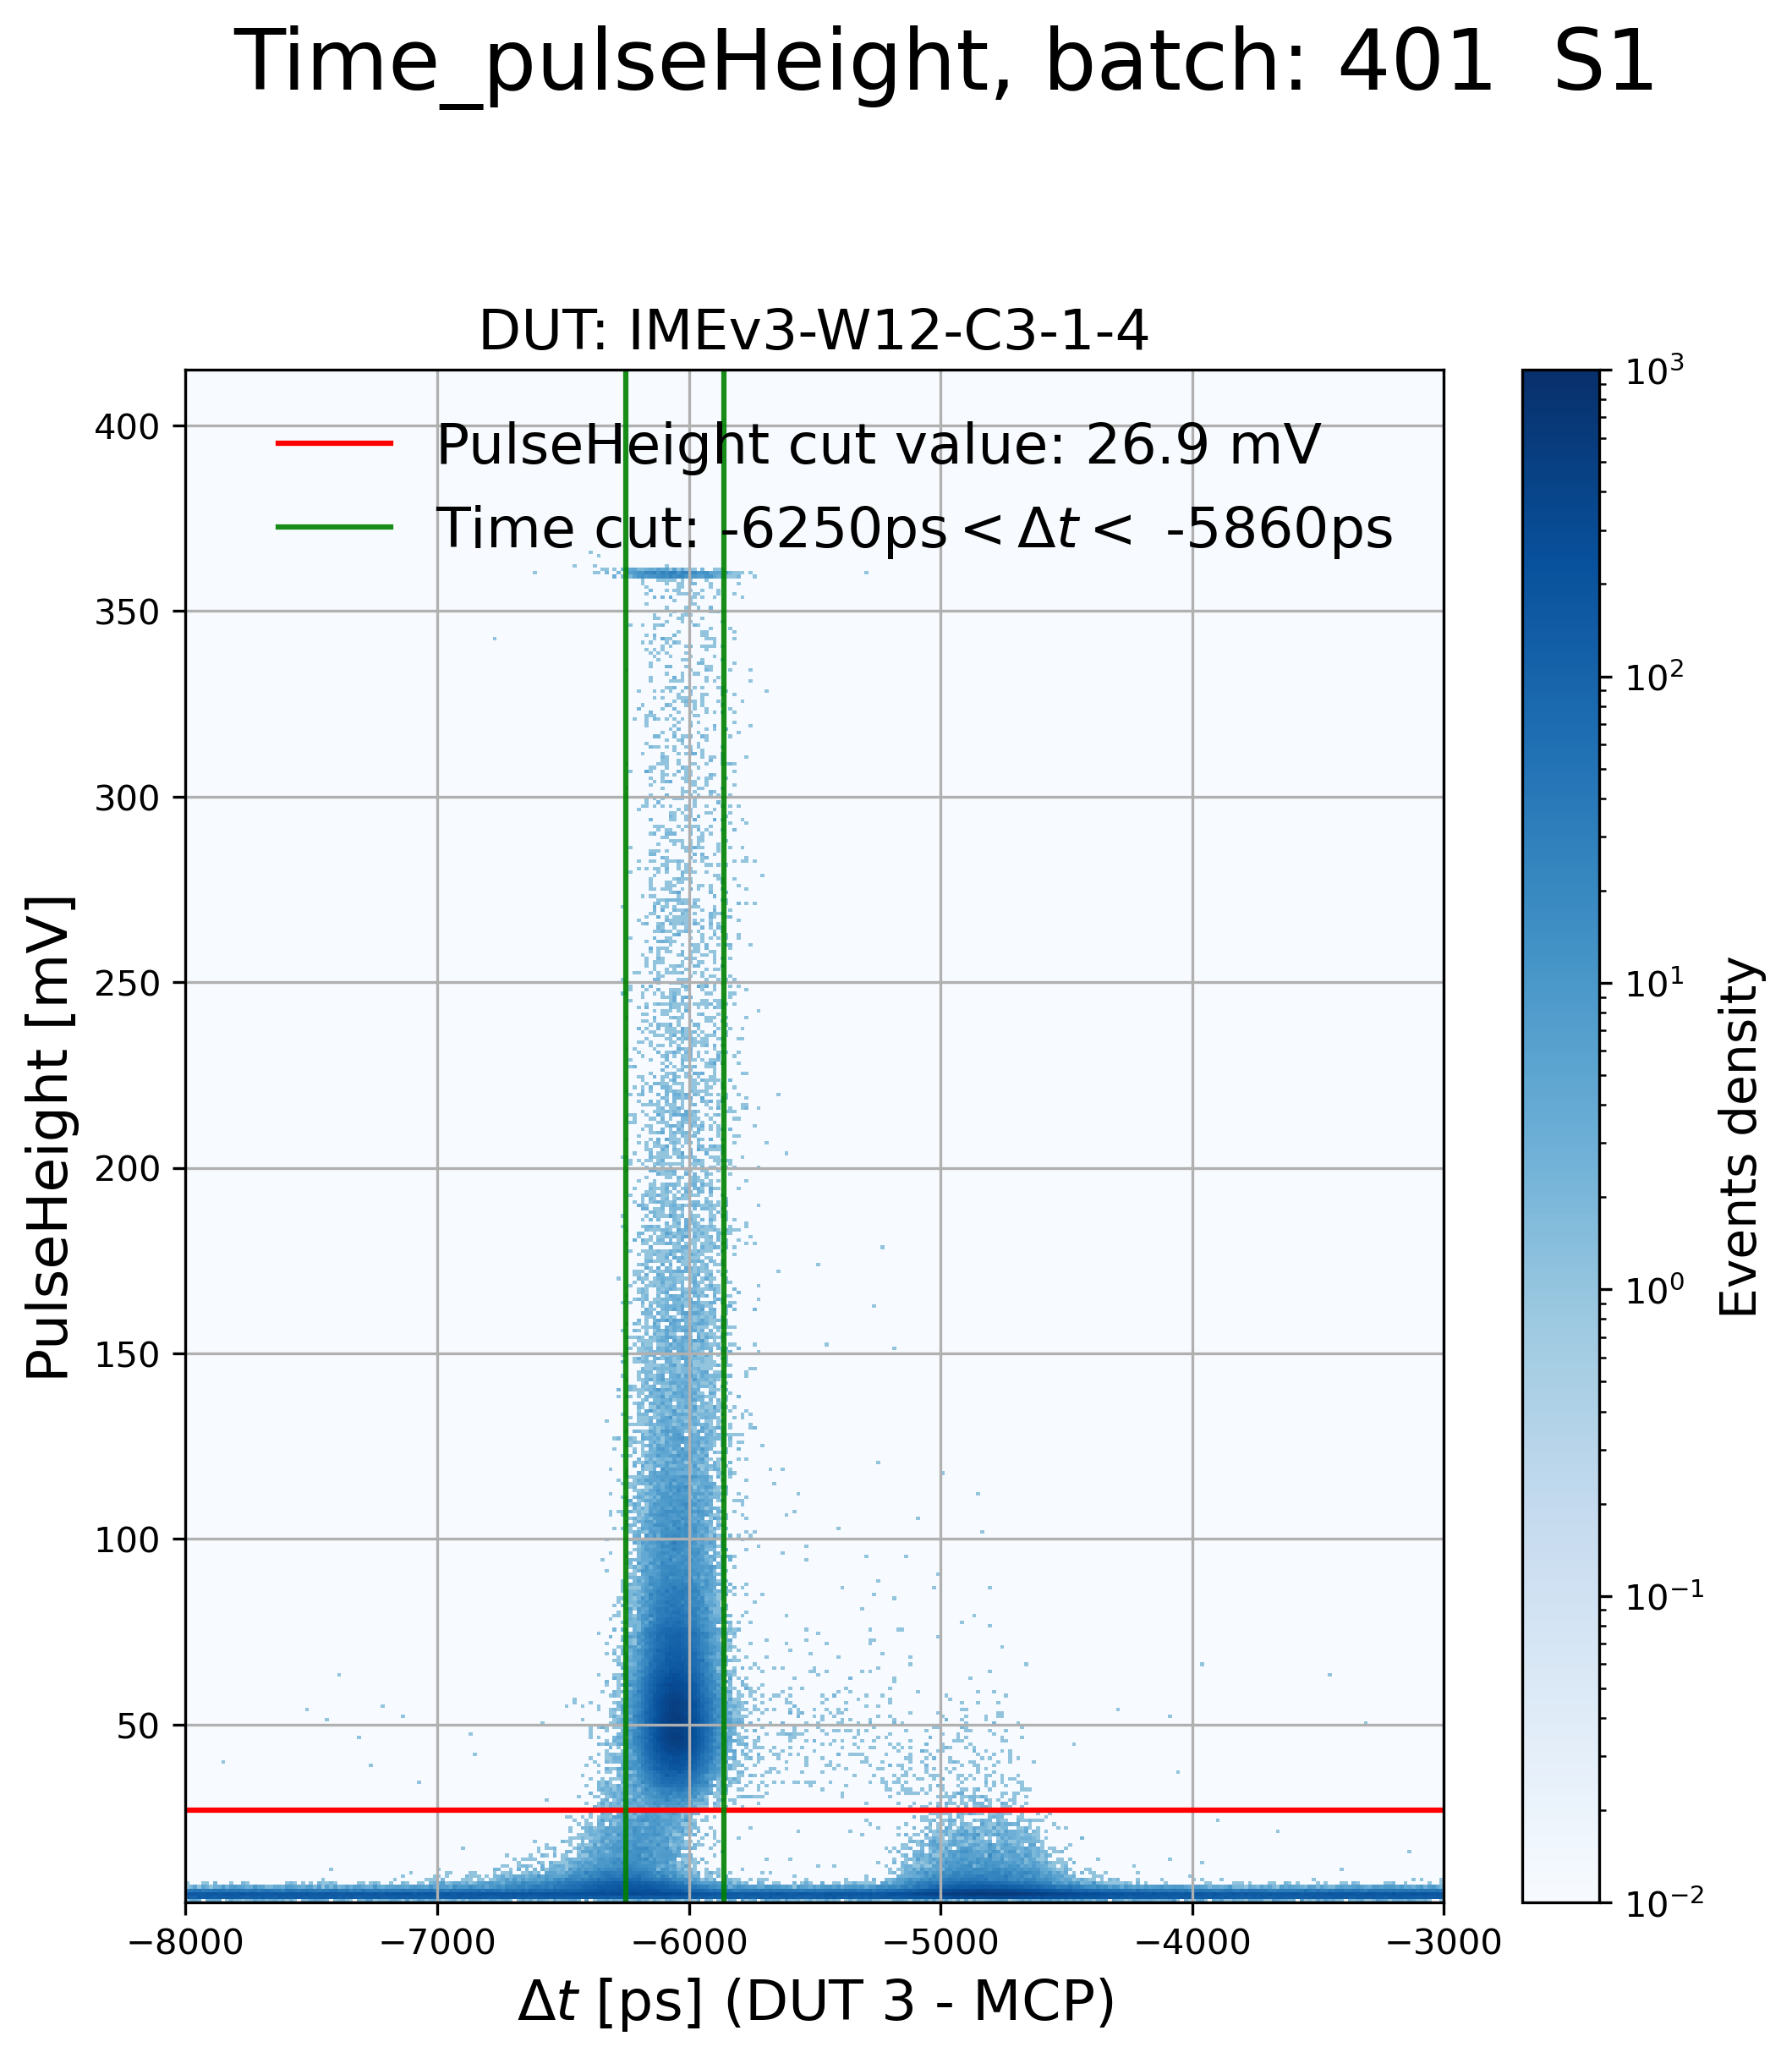

In [41]:
### delta time vs pulseHeight with or without info info
SAVE = True
plot(df, "Time_pulseHeight", dict_of_batches[this_batch], S, bins=10000, extra_info=False,
     n_DUT=DUTs, savefig=SAVE, savefig_details=f' {S}', savefig_path=pres_path, fmt='png')

[WARNING] -	 No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 2400x2400 with 2 Axes>,
 array([<ScatterDensityAxesSubplot:title={'center':'DUT: IMEv3-W12-C3-1-4'}, xlabel='$\\Delta t$ [ps] (DUT 3 - MCP)', ylabel='PulseHeight [mV]'>],
       dtype=object))

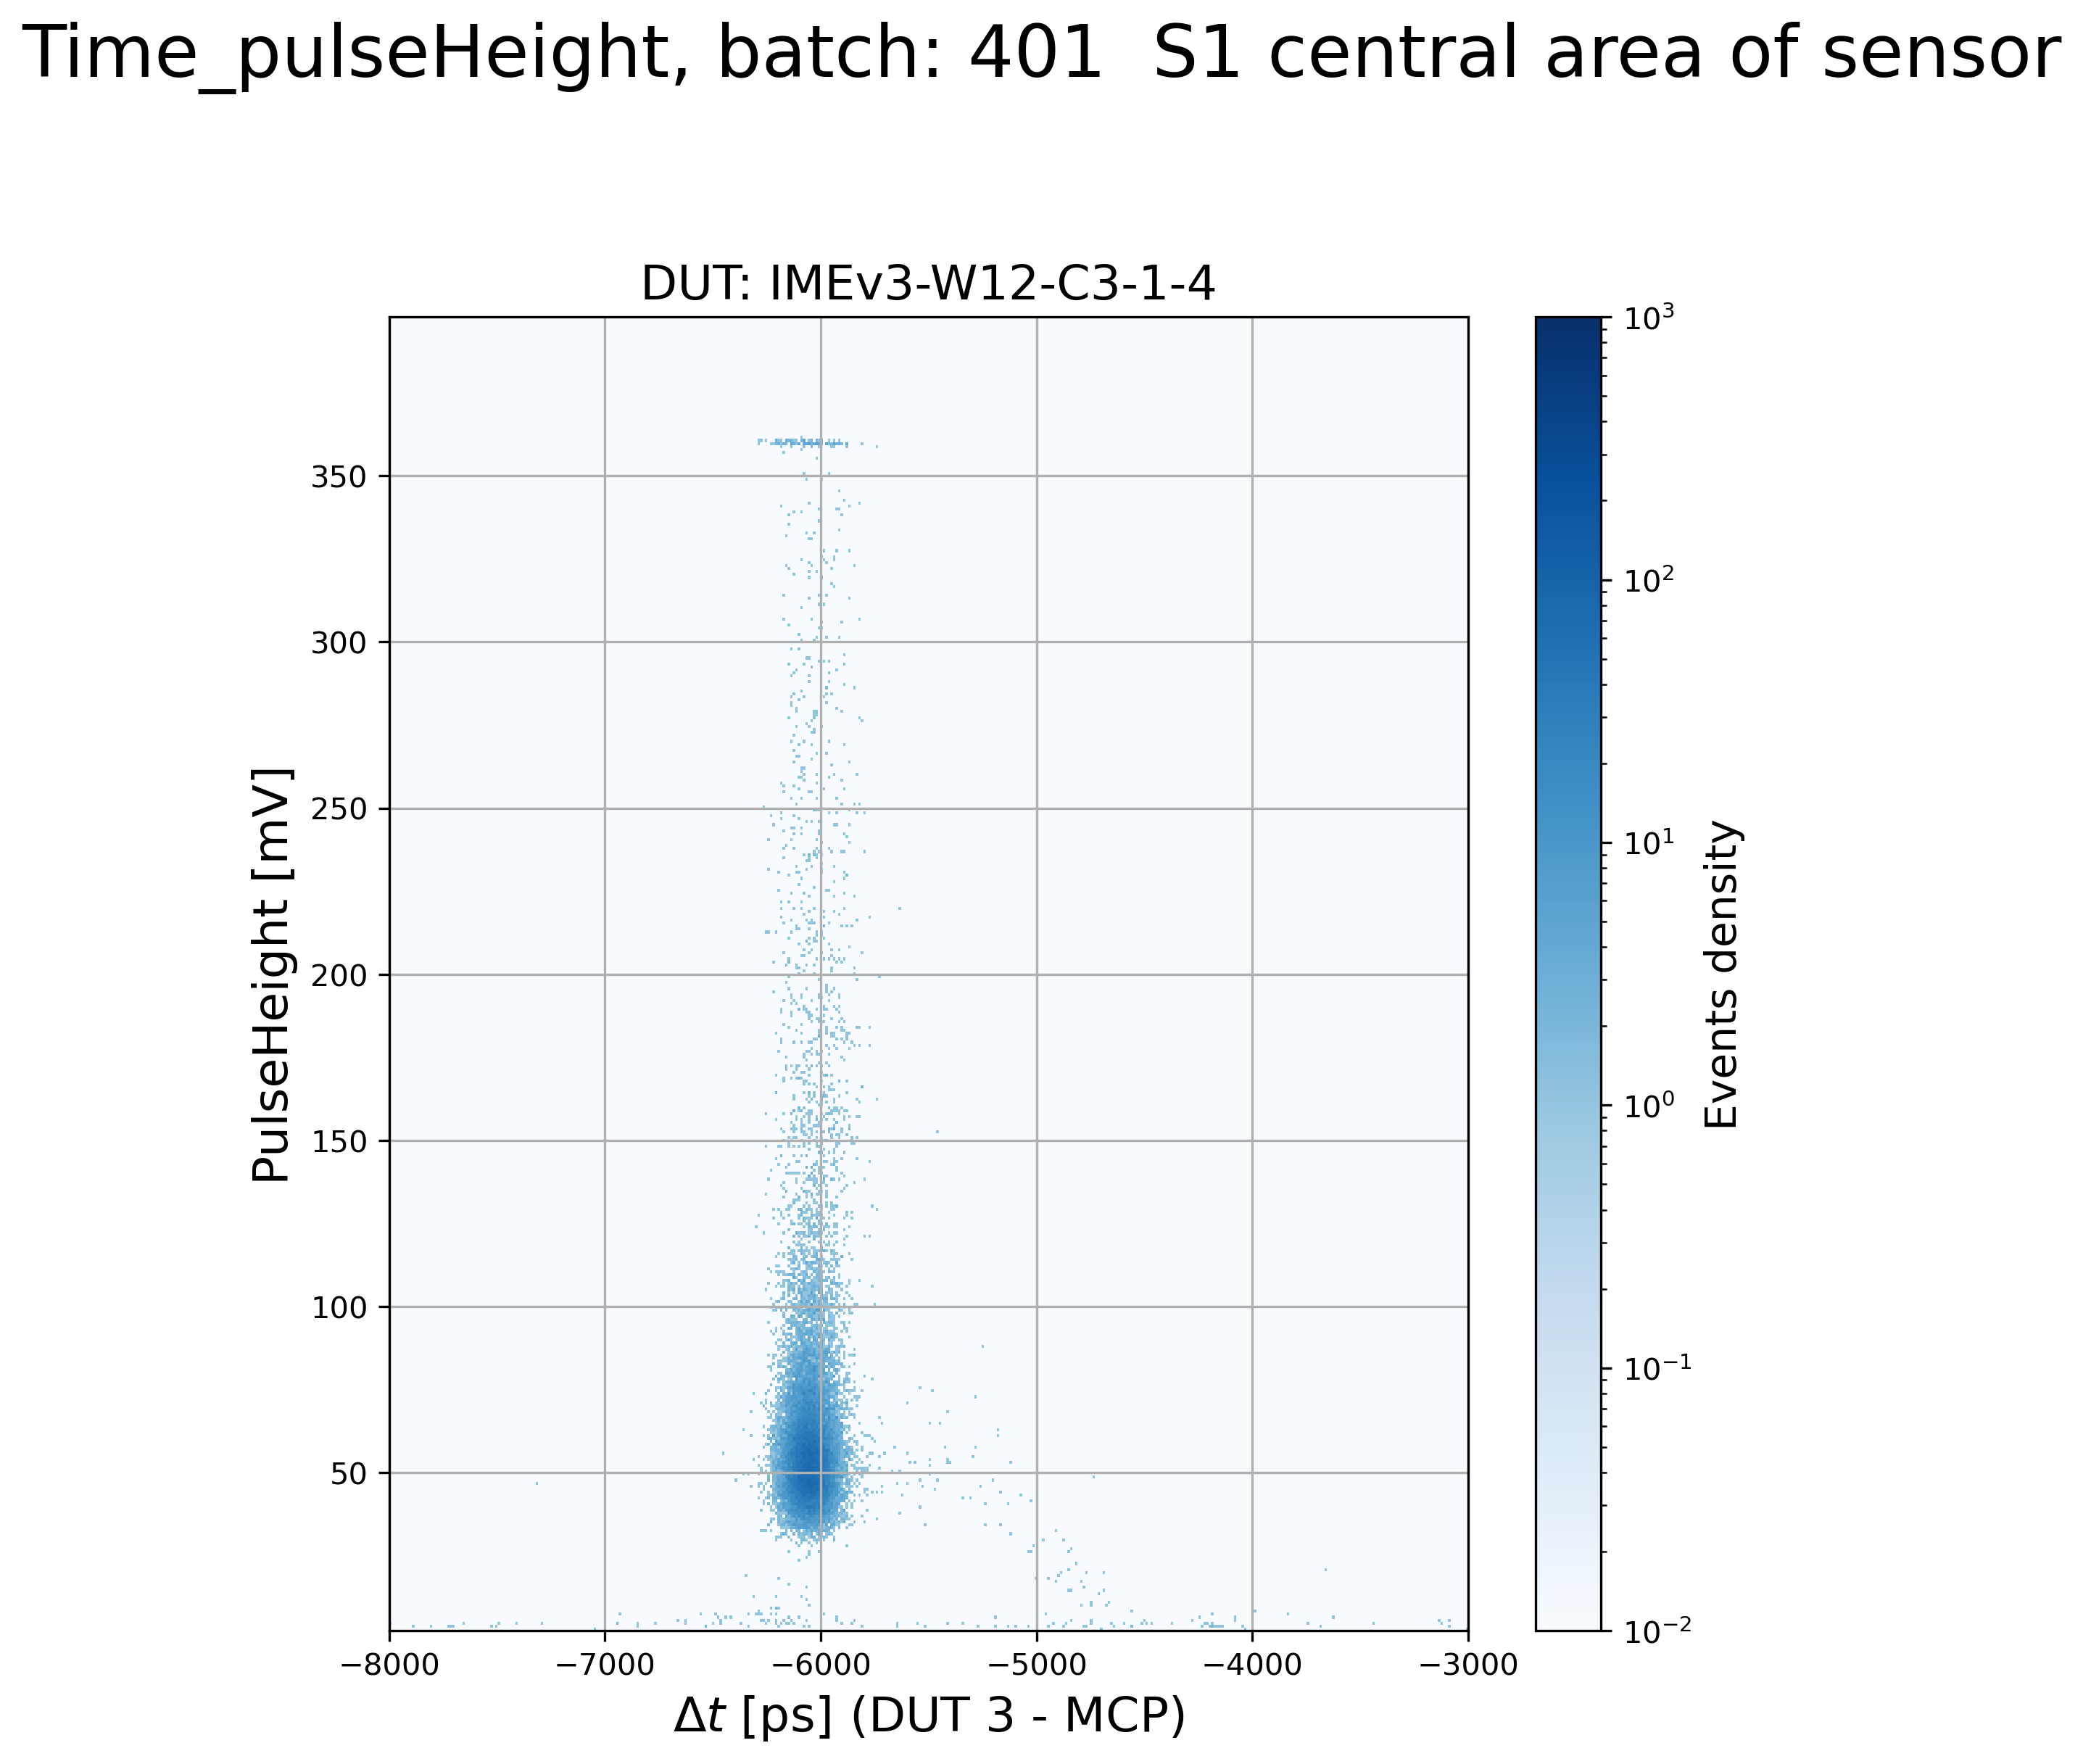

In [42]:
### delta time vs pulseHeight CENTRAL AREA OF SENSOR without info
SAVE = True
plot(df, "Time_pulseHeight", dict_of_batches[this_batch], S, bins=10000, info=False, extra_info=False, mask=central_sensor_area_cuts,
     n_DUT=DUTs, savefig=SAVE, savefig_details=f' {S} central area of sensor', savefig_path=pres_path, fmt='png')


- efficiency plot 1D and 2D
- efficiency w.r.t the threshold charge

## Charge distribution, cuts and fit

In [43]:
# transimpedance = [dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').transimpedance for dut in [1,2,3]]
mins = [find_min_btw_peaks(df[f"pulseHeight_{dut}"], bins='rice', plot=False) for dut in [1,2,3]]

geo_cuts = [geometry_mask(df, DUT_number=dut, bins=bins1, bins_find_min='rice')[0] for dut in [1,2,3]]
extended_geo_cuts = [geometry_mask(df, DUT_number=dut, bins=bins1, bins_find_min='rice', only_select='extended')[0] for dut in [1,2,3]]
time_cuts = [time_mask(df, DUT_number=dut, sigmas=3)[0] for dut in [1,2,3]]
pulse_cuts = [df[f'pulseHeight_{dut}']>mins[dut-1] for dut in [1,2,3]]

all_cuts = [np.logical_and(np.logical_and(geo_cuts[dut-1], time_cuts[dut-1]), pulse_cuts[dut-1]) for dut in [1,2,3]]

fit_cuts = [np.logical_and(df[f"charge_{dut}"]>0, all_cuts[dut-1]) for dut in [1,2,3]]

In [44]:
colormap = ['k','b','g','r']


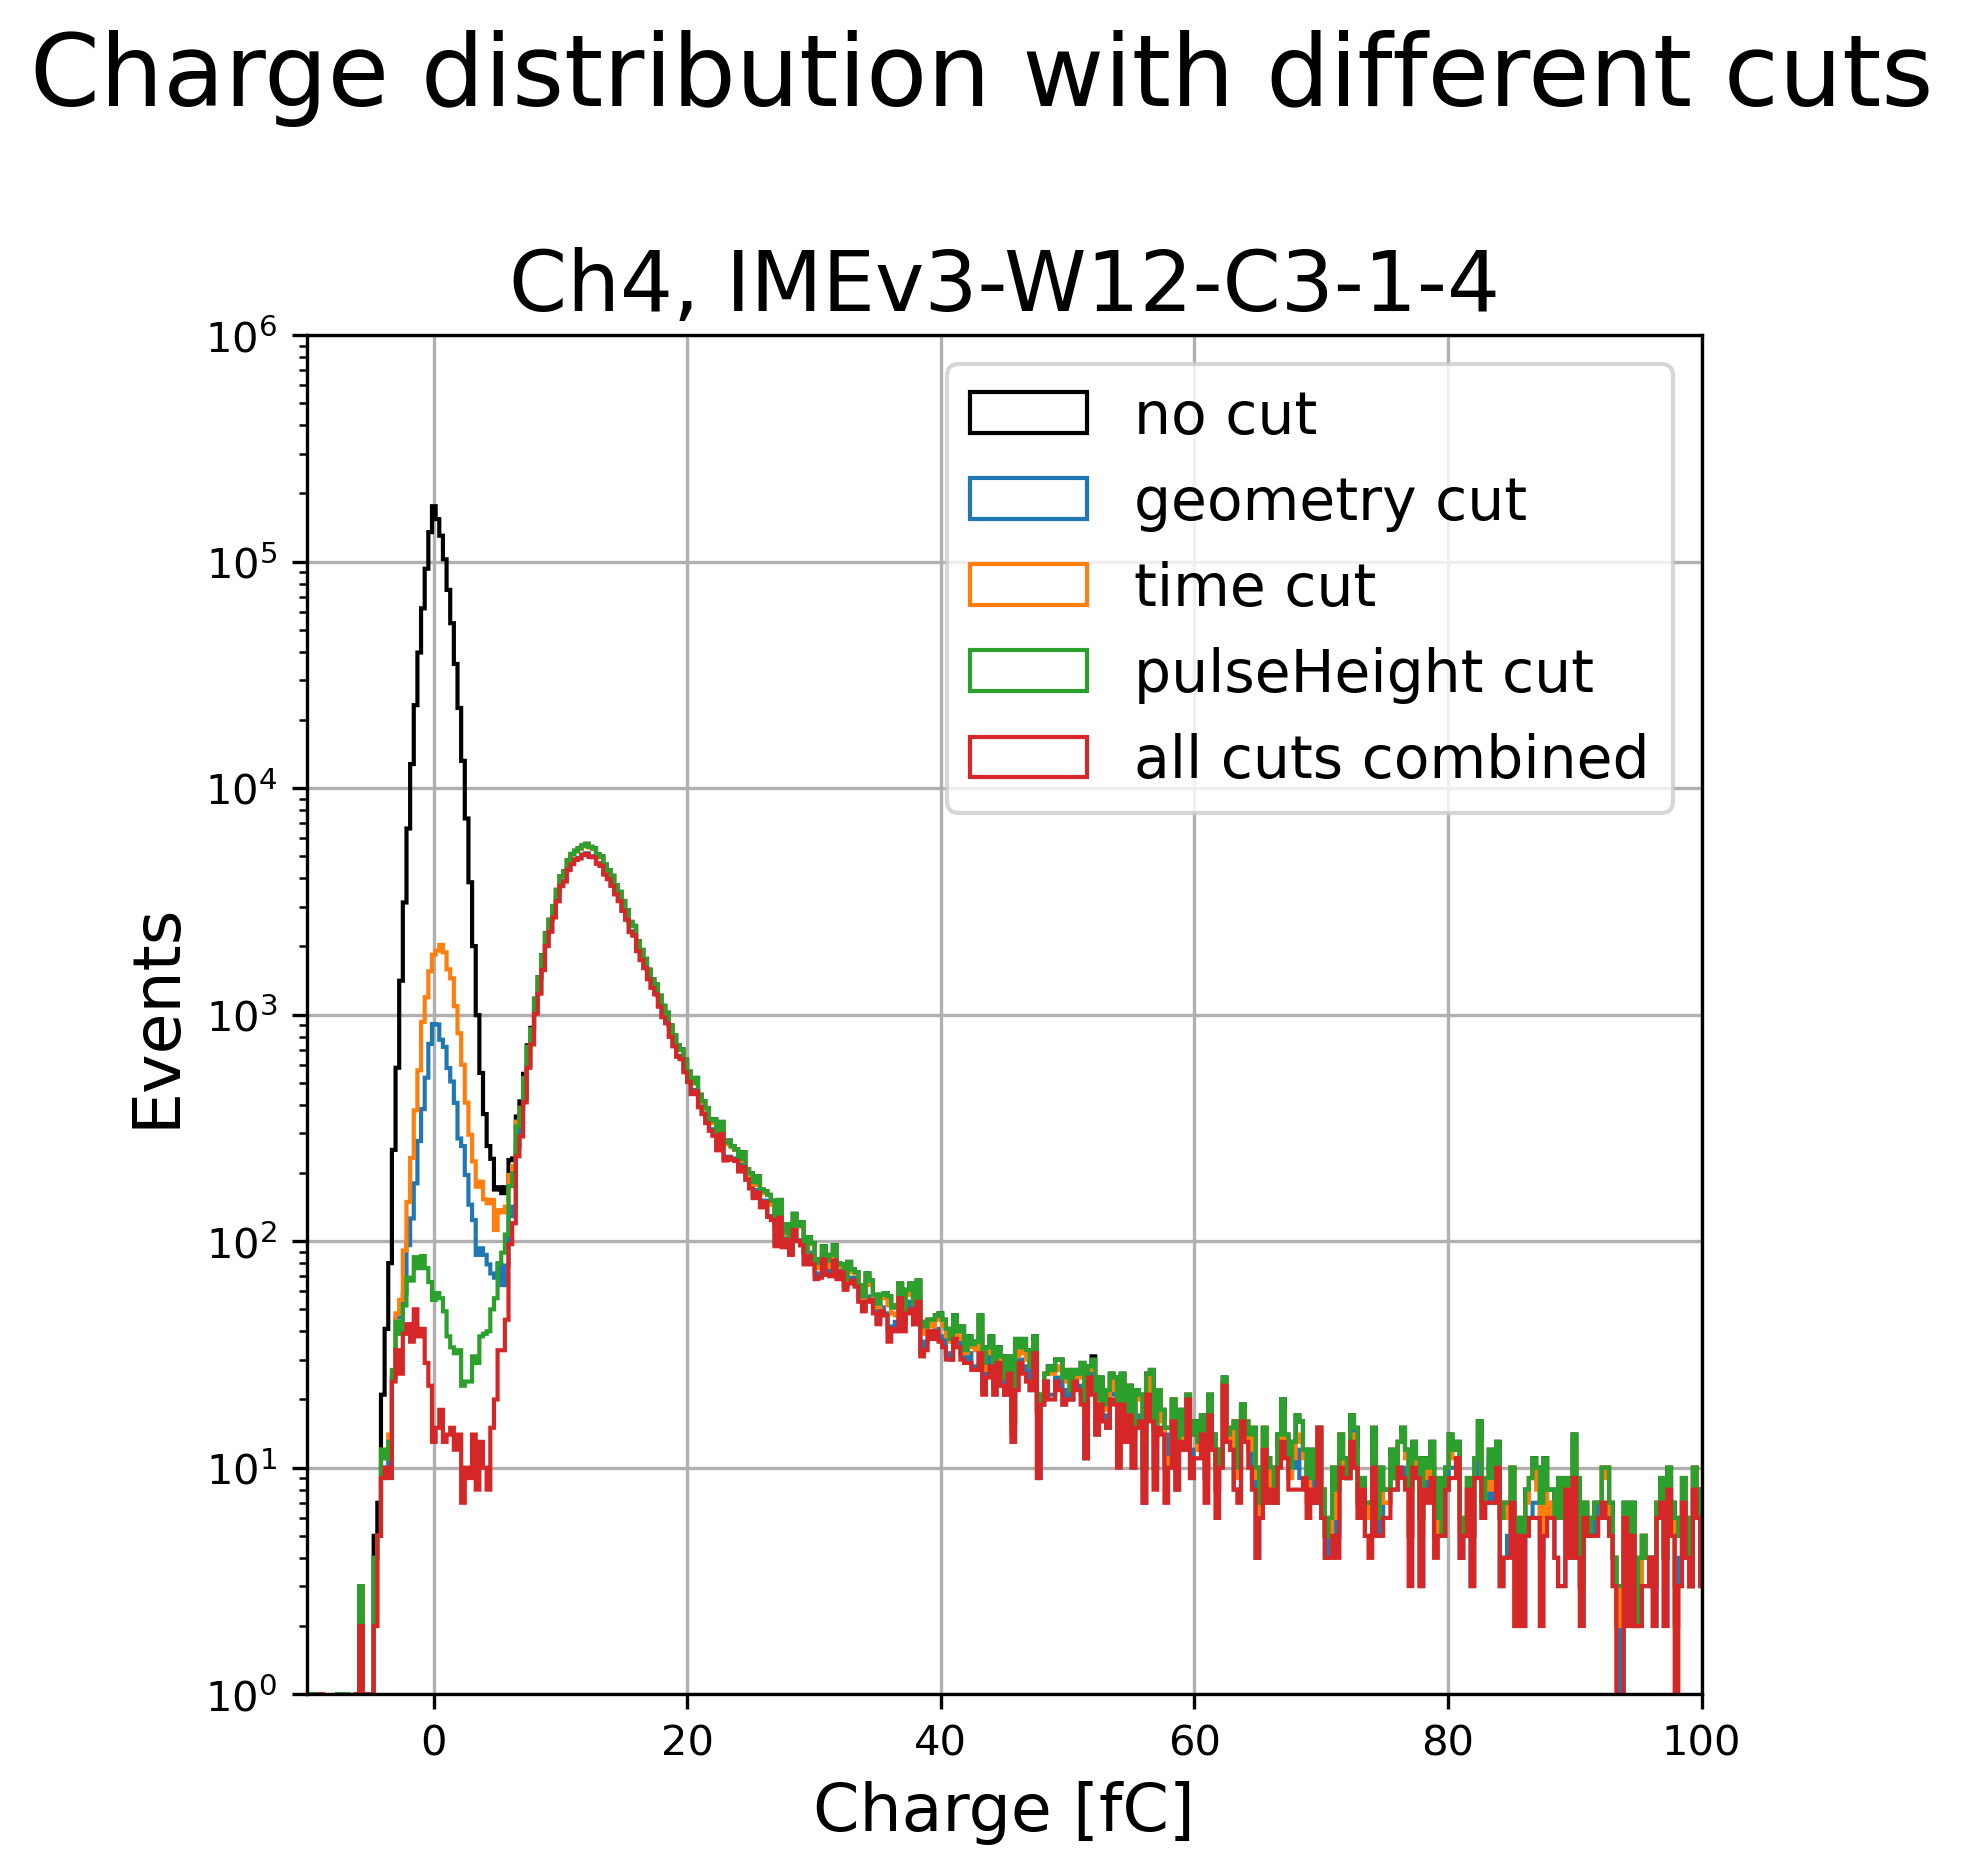

In [45]:

fig, axes = plt.subplots(figsize=(6*len(DUTs),6), ncols=len(DUTs), dpi=300)
### if there is only on dut
axes = [axes]
transimpedance = [4700]*3   ### apparently the transimpedance is wrong

for i,dut in enumerate(DUTs):
    hist,my_bins,_,_,_ = plot_histogram(df[f'charge_{dut}']/transimpedance[dut-1], bins=2000,
                                          color=colormap[0], label=f"no cut",
                                          fig_ax=(fig,axes[i]))
    
    hist_geo_cut,_,_,_,_ = plot_histogram((df[f'charge_{dut}'].loc[geo_cuts[dut-1]]/transimpedance[dut-1]), bins=my_bins,
                                                   histtype='step', alpha=1, label=f"geometry cut",
                                                   fig_ax=(fig,axes[i]))
    
    hist_time_cut,_,_,_,_ = plot_histogram((df[f'charge_{dut}'].loc[time_cuts[dut-1]]/transimpedance[dut-1]), bins=my_bins,
                                                   histtype='step', alpha=1, label=f"time cut",
                                                   fig_ax=(fig,axes[i]))
    
    hist_pulse_cut,_,_,_,_ = plot_histogram((df[f'charge_{dut}'].loc[pulse_cuts[dut-1]]/transimpedance[dut-1]), bins=my_bins,
                                                   histtype='step', alpha=1, label=f"pulseHeight cut",
                                                   fig_ax=(fig,axes[i]))
    
    hist_all_cut,_,_,_,_ = plot_histogram((df[f'charge_{dut}'].loc[all_cuts[dut-1]]/transimpedance[dut-1]), bins=my_bins,
                                                   histtype='step', alpha=1, label=f"all cuts combined",
                                                   fig_ax=(fig,axes[i]))
    bins_centers = (my_bins[1:]+my_bins[:-1])/2
    bins_centers = bins_centers.astype(np.float64)
#     interesting_interval = (-3,3)
#     axes[i].axvspan(*interesting_interval, ymin=0, ymax=1, alpha=0.4, color='red', label='Noise?')
    
    axes[i].semilogy()
    axes[i].set_xlim(-10, 100)
    axes[i].set_ylim(1,1e6)
    axes[i].set_xlabel("Charge [fC]", fontsize=16)
    axes[i].set_ylabel("Events", fontsize=16)
    axes[i].grid('--')
    axes[i].set_title(f"Ch{dut+1}, {dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').name}",fontsize=20)
    axes[i].legend(fontsize=14)
    
fig.suptitle(f"Charge distribution with different cuts", fontsize=24, y=1.05)
if SAVE:
    fig.savefig(os.path.join(pres_path,f'Charge_distribution_different_cuts_batch_{this_batch}_{S}.png'), bbox_inches='tight')

#### Gaussian*Langau fit

In [46]:
# chi2_reduced = sum((hist_all_cut-pylandau.langau(bins_centers,*param))**2/pylandau.langau(bins_centers,*param))/(len(hist_all_cut)-len(param))

In [47]:
sum(pylandau.langau(bins_centers,*param)==0)

RuntimeError: Cannot calculate MPV, check function parameters and file bug report!

In [38]:
chi2_reduced = sum((hist_all_cut-pylandau.langau(bins_centers,*param))**2/pylandau.langau(bins_centers,*param))#/(len(hist_all_cut)-len(param))
chi2_reduced

/tmp/ipykernel_337595/3985986275.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi2_reduced = sum((hist_all_cut-pylandau.langau(bins_centers,*param))**2/pylandau.langau(bins_centers,*param))#/(len(hist_all_cut)-len(param))
/tmp/ipykernel_337595/3985986275.py:1: RuntimeWarning: invalid value encountered in divide
  chi2_reduced = sum((hist_all_cut-pylandau.langau(bins_centers,*param))**2/pylandau.langau(bins_centers,*param))#/(len(hist_all_cut)-len(param))


nan

In [ ]:
### with PULSEHEIGHT cut,  TIME cut and AREA OF THE SENSOR (geometry cut)

fig, axes = plt.subplots(figsize=(6*len(DUTs),6), ncols=len(DUTs), dpi=300)

### if there is only one dut
axes = [axes]

for i,dut in enumerate(DUTs):
#     transimpedance = dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').transimpedance
    transimpedance = 4700    ### I want to use the same 'my_bins' as the plot just before
    hist_all_cut,_,_,_,_ = plot_histogram((df[f'charge_{dut}'].loc[fit_cuts[dut-1]]/transimpedance), bins=my_bins,
                                           histtype='step', alpha=1, label=f"pulseHeight, geometry and time cut",
                                           fig_ax=(fig,axes[i]))

    bins_centers = (my_bins[1:]+my_bins[:-1])/2
    bins_centers = bins_centers.astype(np.float64)

    param, covariance = curve_fit(pylandau.langau, bins_centers, hist_all_cut, p0=(my_bins[np.argmax(hist_all_cut)],1,1,np.max(hist_all_cut)))
#     param, covariance = charge_fit(df, dut, mask=all_cuts[dut-1], transimpedance=transimpedance, plot=False)
    chi2_reduced = sum((hist_all_cut-pylandau.langau(bins_centers,*param))**2/pylandau.langau(bins_centers,*param))/(len(hist_all_cut)-len(param))
    axes[i].plot([],[],linewidth=0, label="$\chi^2$ reduced: "+f"%.1f"%chi2_reduced)
    
    axes[i].plot(bins_centers, pylandau.langau(bins_centers, *param), label="Landau*Gaussian fit")
    
    axes[i].semilogy()
    axes[i].set_xlim(-10, 100)
    axes[i].set_ylim(1,1e6)
    axes[i].set_xlabel("Charge [fC]", fontsize=16)
    axes[i].set_ylabel("Events", fontsize=16)
    axes[i].grid('--')
    axes[i].set_title(f"Ch{dut+1}, {dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').name}",fontsize=20)
    legend_text = "MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2]) # only two decimals
    handles, labels = axes[i].get_legend_handles_labels()
    handles.append(mpatches.Patch(color='none', label=legend_text))
    axes[i].legend(handles=handles, fontsize=14);
    
fig.suptitle(f"Charge distribution and Landau*Gaussian fit\n with pulseHeight, geometry and time cut", fontsize=24, y=1.1)

# fig.savefig(os.path.join(pres_path,f"Charge_distribution_with_langau_fit_{this_batch}.png"),bbox_inches='tight')


In [ ]:
### with only CENTRAL AREA OF THE SENSOR (geometry cut)

fig, axes = plt.subplots(figsize=(6*len(DUTs),6), ncols=len(DUTs), dpi=300)
### if there is only on dut
axes = [axes]

for i,dut in enumerate(DUTs):
#     transimpedance = dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').transimpedance
    transimpedance = 4700
    hist_center_cut,my_bins,_,_,_ = plot_histogram((df[f'charge_{dut}'].loc[central_sensor_area_cuts[dut-1]]/transimpedance), bins='auto',
                                           histtype='step', alpha=1, label=f"central area of sensor",
                                           fig_ax=(fig,axes[i]))

    bins_centers = (my_bins[1:]+my_bins[:-1])/2
    bins_centers = bins_centers.astype(np.float64)

    param, covariance = curve_fit(pylandau.langau, bins_centers, hist_center_cut, p0=(my_bins[np.argmax(hist_center_cut)],1,1,np.max(hist_center_cut)))
    axes[i].plot(bins_centers, pylandau.langau(bins_centers, *param), label="Landau*Gaussian fit")
    
    axes[i].semilogy()
    axes[i].set_xlim(-10, 50)
    axes[i].set_ylim(0.1,1e6)
    axes[i].set_xlabel("Charge [fC]", fontsize=16)
    axes[i].set_ylabel("Events", fontsize=16)
    axes[i].grid('--')
    axes[i].set_title(f'Ch{dut+1}',fontsize=20)
    legend_text = "MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2]) # only two decimals
    handles, labels = axes[i].get_legend_handles_labels()
    handles.append(mpatches.Patch(color='none', label=legend_text))
    axes[i].legend(handles=handles, fontsize=16);
    
fig.suptitle(f"Charge distribution and Landau*Gaussian fit \n central area of sensor", fontsize=24, y=1.1)

# fig.savefig(f"../various plots/Charge_distribution_fit_{this_batch}.svg",bbox_inches='tight')


### Studying what events cause the peak of noise below zero, CHARGE

In [ ]:
df[f'charge_{dut}'].loc[all_cuts[dut-1]]

In [ ]:
### Noisy charge without cuts

noise_charge = [np.logical_and(df[f'charge_{dut}']/
                dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').transimpedance > interesting_interval[0],
                               df[f'charge_{dut}']/
                dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').transimpedance < interesting_interval[1])
                for dut in [1,2,3]]

fig, ax = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=bins1, n_DUT=[1,2,3], mask=noise_charge,
                    savefig=SAVE, savefig_path=pres_path, savefig_details=f" tracks of charge noise peak", fmt='png')

fig.suptitle("Tracks of the charge noise peak", fontsize=24, y=1.05)


In [ ]:
### Noisy charge with SENSOR AREA cut (geometry cut)

noise_charge = [np.logical_and(geo_cuts[dut-1],
                np.logical_and(df[f'charge_{dut}']/
                                dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').transimpedance > interesting_interval[0],
                               df[f'charge_{dut}']/
                                dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').transimpedance < interesting_interval[1]))
                for dut in [1,2,3]]

fig, ax = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=bins1, n_DUT=[1,2,3], mask=noise_charge,
                    savefig=SAVE, savefig_path=pres_path, savefig_details=f" tracks of charge noise peak with sensor area cut", fmt='png')

fig.suptitle("Tracks of the charge noise peak with sensor area cut", fontsize=24, y=1.05)


In [ ]:
### Noisy charge with TIME cut

noise_charge = [np.logical_and(time_cuts[dut-1],
                np.logical_and(df[f'charge_{dut}']/
                                dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').transimpedance > interesting_interval[0],
                               df[f'charge_{dut}']/
                                dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').transimpedance < interesting_interval[1]))
                for dut in [1,2,3]]

fig, axes = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=bins1, n_DUT=[1,2,3], mask=noise_charge,
                    savefig=SAVE, savefig_path=pres_path, savefig_details=f" tracks of charge noise peak with time cut", fmt='png')

fig.suptitle("Tracks of the charge noise peak with time cut", fontsize=24, y=1.05)

for i,ax in enumerate(axes):
    ax.add_patch(rectangle_from_geometry_cut(**geo_infos[i], alpha=.5))
    
if SAVE:
    fig.savefig(os.path.join(pres_path,f'Charge_noise_peak_{this_batch}_{S}_with_sensor_highlight.png'), bbox_inches='tight')

In [ ]:
### Noisy charge with PULSEHEIGHT cut

noise_charge = [np.logical_and(pulse_cuts[dut-1],
                np.logical_and(df[f'charge_{dut}']/
                                dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').transimpedance > interesting_interval[0],
                               df[f'charge_{dut}']/
                                dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').transimpedance < interesting_interval[1]))
                for dut in DUTs]

fig, axes = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=bins1, n_DUT=[1,2,3], mask=noise_charge,
                    savefig=SAVE, savefig_path=pres_path, savefig_details=f" tracks of charge noise peak with pulseheight cut", fmt='png')

fig.suptitle("Tracks of the charge noise peak with pulseheight cut", fontsize=24, y=1.05)

for i,ax in enumerate(axes):
    ax.add_patch(rectangle_from_geometry_cut(**geo_infos[i], alpha=.7))    

In [ ]:
### Noisy charge with ALL THREE CUTS

noise_charge = [np.logical_and(all_cuts[dut-1], df[f'charge_{dut}']/
                               dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').transimpedance < 0) for dut in DUTs]

fig, axes = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=bins1, n_DUT=[1,2,3], mask=noise_charge,
                    savefig=SAVE, savefig_path=pres_path, savefig_details=f" tracks of charge noise peak with all three cuts", fmt='png')

fig.suptitle("Tracks of the charge noise peak with all three cuts", fontsize=24, y=1.05)

for i,ax in enumerate(axes):
    ax.add_patch(rectangle_from_geometry_cut(**geo_infos[i], alpha=.7))    

## Efficiency

In [ ]:
### without cuts (only selecting sensor area)

fig, axes = plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, transimpedance=4700, geometry_cut='normal', zoom_to_sensor=True,
    bins=bins1, n_DUT=DUTs, savefig=SAVE, savefig_details=f'{S} thresh_charge {threshold_charge}fC (zoomed)', 
    savefig_path=pres_path, fmt='png')

### I want to draw the red square of the center onto these plots
for i,dut in enumerate(DUTs):
    axes[i].add_patch(rectangle_from_geometry_cut(**central_sensor_area_info[dut-1]))

if SAVE:
    fig.savefig(os.path.join(pres_path,f'2D Efficiency_{this_batch}_{S}_with_center_highlight.png'), bbox_inches='tight')
    

In [ ]:
### efficiency with time cut
fig, axes = plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut='normal', mask=time_cuts, zoom_to_sensor=True,
    bins=bins1, n_DUT=DUTs, savefig=SAVE, savefig_details=f'{S} thresh_charge {threshold_charge}fC (zoomed with timecut)', 
    savefig_path=pres_path, fmt='png')


In [ ]:
SAVE = True
plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut='center', zoom_to_sensor=True,
    bins=bins1, n_DUT=DUTs, savefig=SAVE, savefig_details=f' {S} thresh_charge {threshold_charge}fC (center)',
     savefig_path=pres_path, fmt='png')
;

In [ ]:
plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut='normal', zoom_to_sensor=True,
    bins=bins1, n_DUT=DUTs, savefig=SAVE, savefig_details=f'{S}, threshold_charge: {threshold_charge}fC',
    savefig_path=pres_path, fmt='png')
;

In [ ]:
SAVE = True
plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut='center', zoom_to_sensor=True,
    bins=bins1, n_DUT=DUTs, savefig=SAVE, savefig_details=f'{S}, threshold_charge: {threshold_charge}fC (center)',
    savefig_path=pres_path, fmt='png')
;

In [ ]:
plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut='center', mask=time_cuts, zoom_to_sensor=True,
    bins=bins1, n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S}_threshold_charge_{threshold_charge}fC (time cut) ',
    savefig_path=pres_path, fmt='png')
;

## Total efficiency

In [ ]:
# transimpedance = [dict_of_batches[this_batch].S[this_scope].get_sensor(f'ch{dut+1}').transimpedance for dut in [1,2,3]]
transimpedance = [4700]*3
threshold_range = np.arange(-5, 20, 0.5)

fig, axes = plt.subplots(figsize=(8*len(DUTs),6),ncols=len(DUTs), dpi=300)
axes = [axes]

for i,dut in enumerate(DUTs):
    efficiency_normal = []
    error_normal = []
    
    efficiency_center = []
    error_center = []
    
    efficiency_timecut = []
    error_timecut = []

    for charge in threshold_range:
        ### efficiency with geometry cut
        eff, err = efficiency_error(df[f"charge_{dut}"].loc[geo_cuts[dut-1]]/transimpedance[dut-1], charge)
        efficiency_normal.append(eff)
        error_normal.append(err)
        ### efficiency with geometry cut (center)
        eff, err = efficiency_error(df[f"charge_{dut}"].loc[central_sensor_area_cuts[dut-1]]/transimpedance[dut-1], charge)
        efficiency_center.append(eff)
        error_center.append(err)
        ### efficiency with time cut (HAVEN'T DONE IT YET)
        eff, err = efficiency_error(df[f"charge_{dut}"].loc[np.logical_and(central_sensor_area_cuts[dut-1], time_cuts[dut-1])]/transimpedance[dut-1], charge)
        efficiency_timecut.append(eff)
        error_timecut.append(err)
        
        if charge==4:
            eff_at_4fC = eff

    ### geometry cut
    axes[i].errorbar(threshold_range, efficiency_normal, yerr=error_normal, marker='.', markersize=3, linewidth=0,
                elinewidth=1, ecolor='k', capsize=1.5,
                label=f"Full surface")#, #tracks: {df[f'charge_{dut}'].loc[geometry].size}")
    ### geometry cut (center)
    axes[i].errorbar(threshold_range, efficiency_center, yerr=error_center, marker='.', markersize=3, linewidth=0,
                elinewidth=1, ecolor='k', capsize=1.5,
                label=f"Center")#, #tracks: {df[f'charge_{dut}'].loc[geometry].size}")
    ### time cut (center)
    axes[i].errorbar(threshold_range, efficiency_timecut, yerr=error_timecut, marker='.', markersize=3, linewidth=0,
                elinewidth=1, ecolor='k', capsize=1.5,
                label=f"Center (time cut)")#, #tracks: {df[f'charge_{dut}'].loc[geometry].size}")

#     axes[i].set_title(f" Sensor: {dict_of_batches[this_batch].S[this_scope].get_sensor(f'Ch{dut+1}').name}, batch {this_batch}",fontsize=16)
    axes[i].set_xlabel("Threshold charge (fC)",fontsize=16)
    axes[i].set_ylabel("Total efficiency",fontsize=16)
    axes[i].axhline(0.95, label="95% efficiency", color='r', alpha=0.4, linewidth=2)
    axes[i].axvline(4, label="4fC threshold", color='g', linewidth=1)
    axes[i].plot([],[], label="Efficiency at 4fC: %.2f"%(eff_at_4fC*100)+"%", linewidth=0)
    axes[i].grid('--')
    axes[i].legend(fontsize=16)
fig.suptitle(f"Efficiency depending on threshold charge",fontsize=20,y=1)

if SAVE:
    fig.savefig(os.path.join(pres_path,f"Efficiency depending on threshold charge batch {this_batch} {S}.png"), bbox_inches='tight')

In [ ]:
# transimpedance = [dict_of_batches[this_batch].S[this_scope].get_sensor(f'ch{dut+1}').transimpedance for dut in [1,2,3]]
transimpedance = [4700]*3
threshold_range = np.arange(0, 20, 0.5)

fig, axes = plt.subplots(figsize=(8*len(DUTs),6),ncols=len(DUTs), dpi=300)
axes = [axes]

for i,dut in enumerate(DUTs):
    efficiency_normal = []
    error_normal = []
    
    efficiency_center = []
    error_center = []
    
    efficiency_timecut = []
    error_timecut = []

    for charge in threshold_range:
        ### efficiency with geometry cut
        eff, err = efficiency_error(df[f"charge_{dut}"].loc[np.logical_and(geo_cuts[dut-1], time_cuts[dut-1])]/transimpedance[dut-1], charge)
        efficiency_normal.append(eff)
        error_normal.append(err)
        ### efficiency with geometry cut (center)
        eff, err = efficiency_error(df[f"charge_{dut}"].loc[np.logical_and(central_sensor_area_cuts[dut-1], time_cuts[dut-1])]/transimpedance[dut-1], charge)
        efficiency_center.append(eff)
        error_center.append(err)
        
        if charge==4:
            eff_at_4fC = eff

    ### geometry cut
    axes[i].errorbar(threshold_range, efficiency_normal, yerr=error_normal, marker='.', markersize=3, linewidth=0,
                elinewidth=1, ecolor='k', capsize=1.5,
                label=f"Full surface")#, #tracks: {df[f'charge_{dut}'].loc[geometry].size}")
    ### geometry cut (center)
    axes[i].errorbar(threshold_range, efficiency_center, yerr=error_center, marker='.', markersize=3, linewidth=0,
                elinewidth=1, ecolor='k', capsize=1.5,
                label=f"Center")#, #tracks: {df[f'charge_{dut}'].loc[geometry].size}")

#     axes[i].set_title(f" Sensor: {dict_of_batches[this_batch].S[this_scope].get_sensor(f'Ch{dut+1}').name}, batch {this_batch}",fontsize=16)
    axes[i].set_xlabel("Threshold charge (fC)",fontsize=16)
    axes[i].set_ylabel("Total efficiency",fontsize=16)
    axes[i].axhline(0.95, label="95% efficiency", color='r', alpha=0.4, linewidth=2)
    axes[i].axvline(4, label="4fC threshold", color='g', linewidth=1)
    axes[i].plot([],[], label="Efficiency at 4fC: %.2f"%(eff_at_4fC*100)+"%", linewidth=0)
    axes[i].grid('--')
    axes[i].legend(fontsize=16)
fig.suptitle(f"Efficiency depending on threshold charge (with time cut)",fontsize=20,y=1)

if SAVE:
    fig.savefig(os.path.join(pres_path,f"Efficiency depending on threshold charge (w/ time cut) batch {this_batch} {S}.png"), bbox_inches='tight')

## Time Resolution

In [19]:
SAVE = False

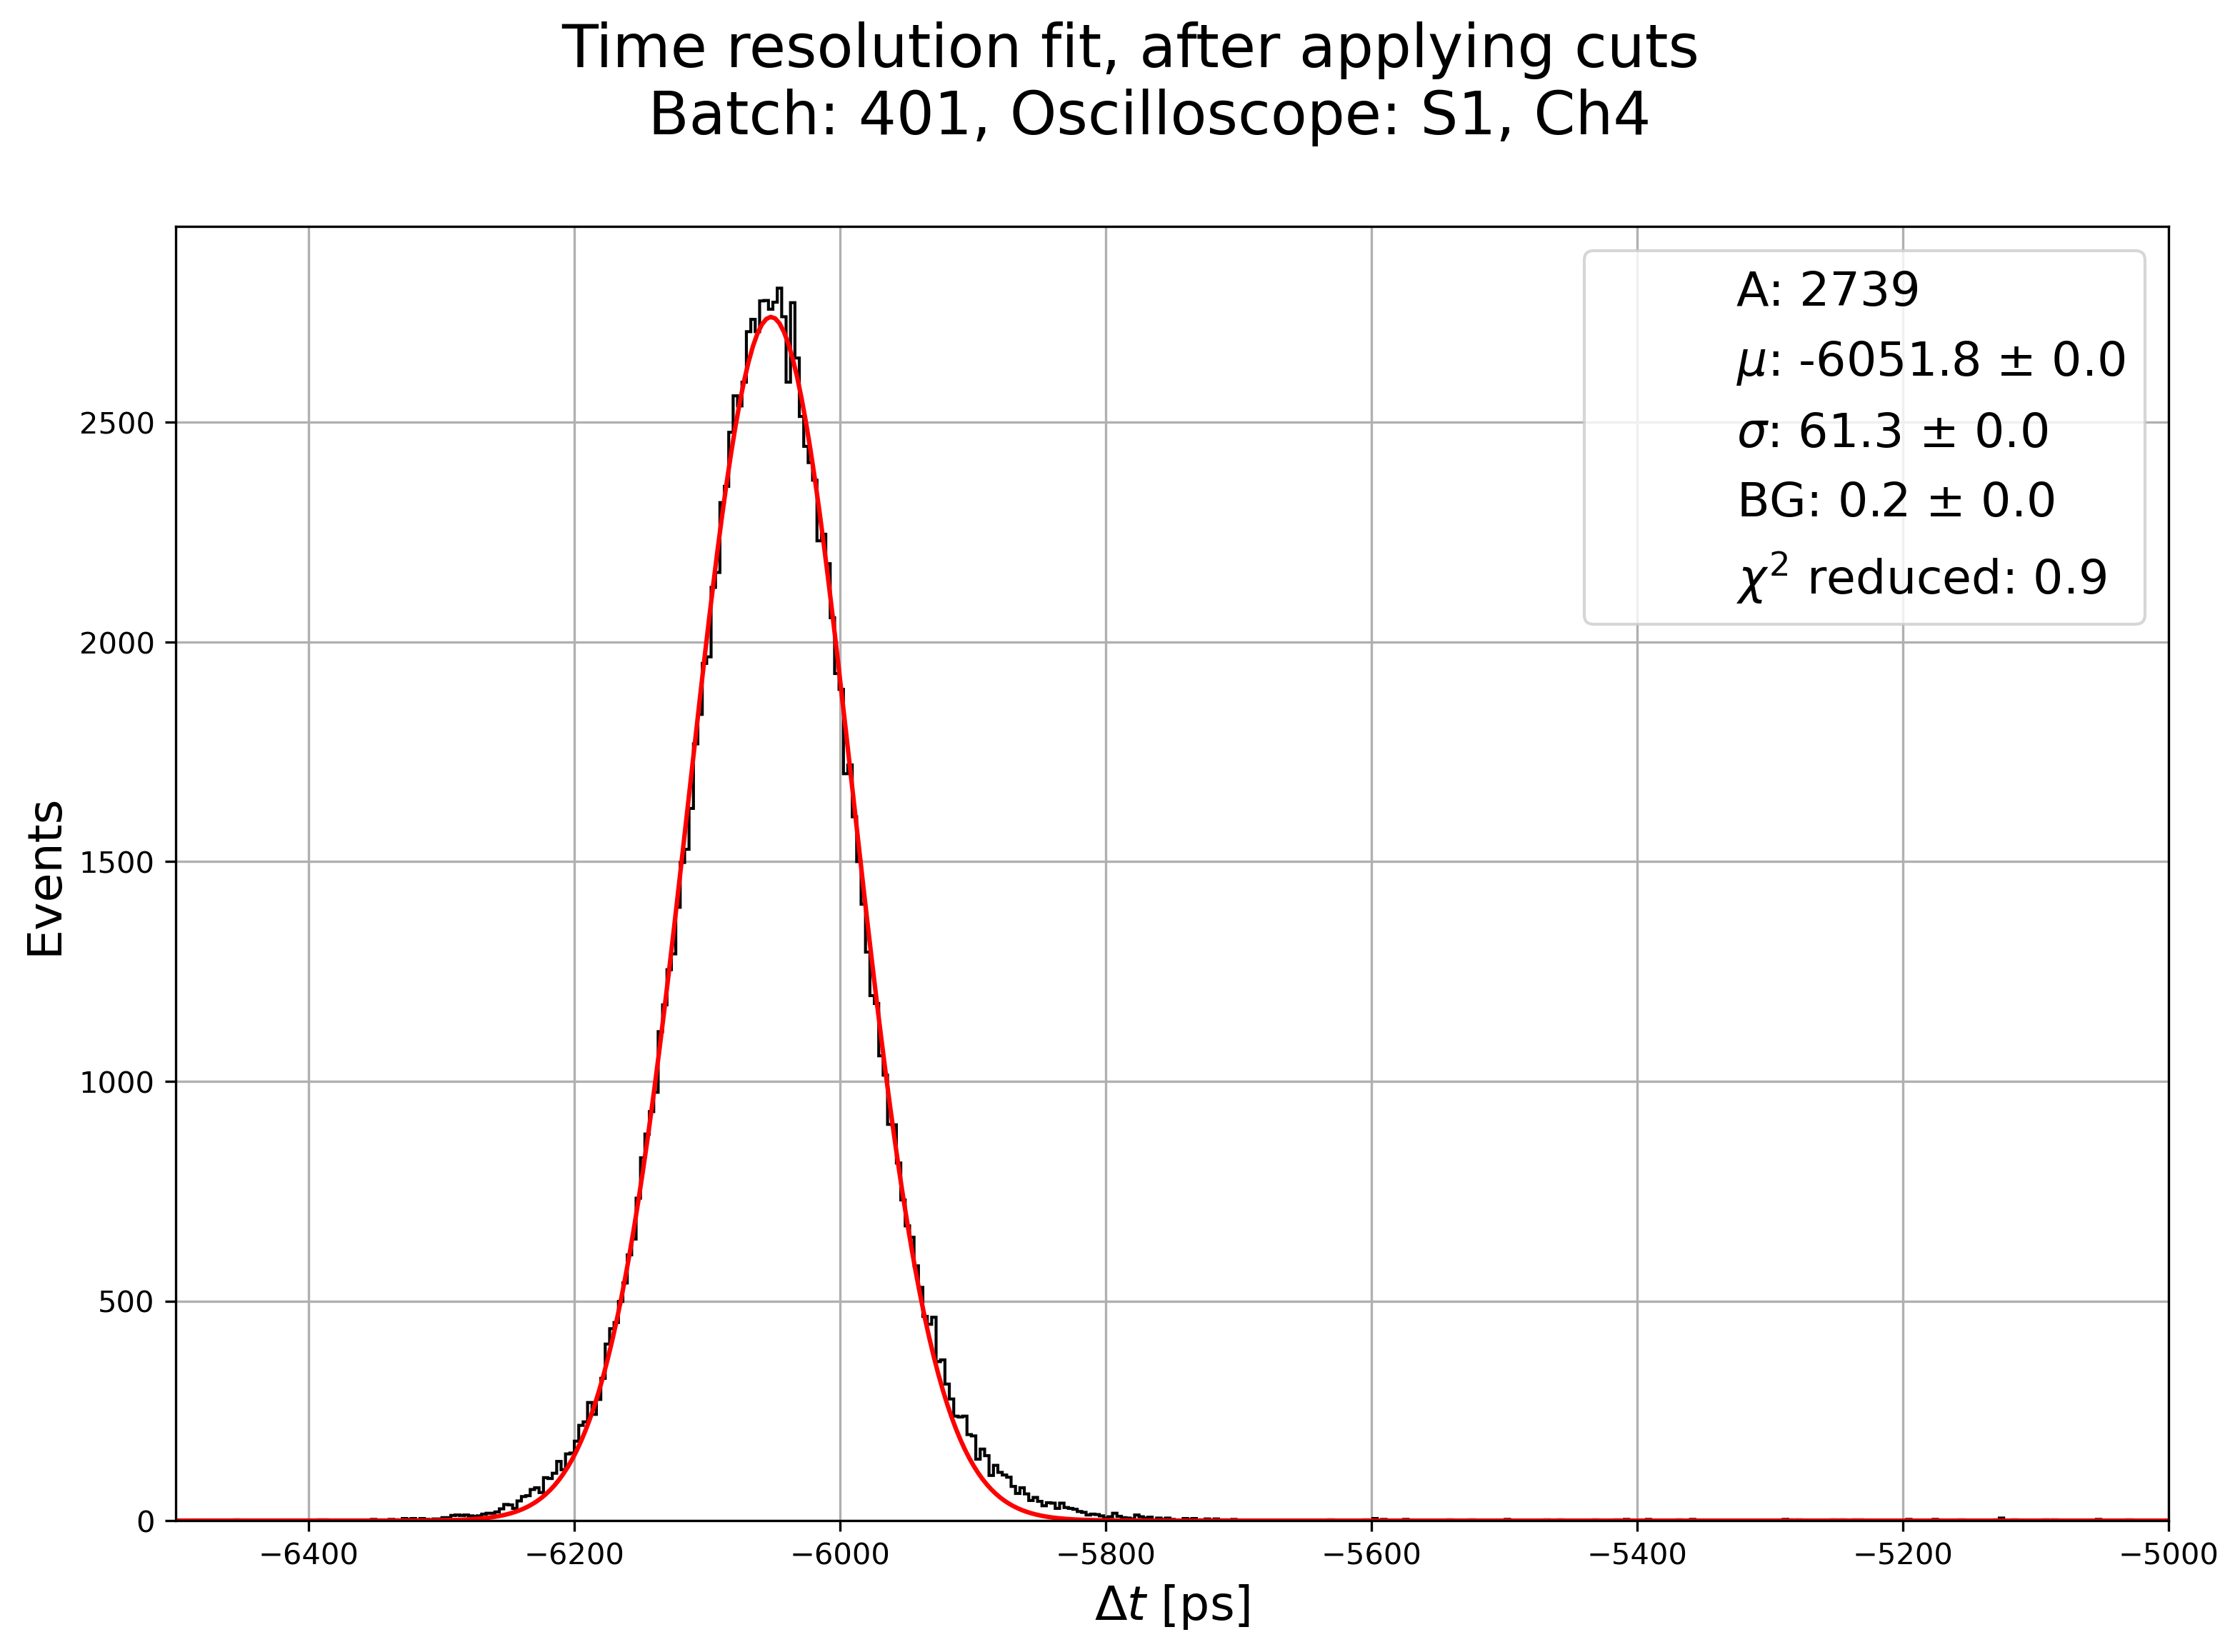

In [18]:
fig, axes = plt.subplots(figsize=(12,8),nrows=1, ncols=1, dpi=300)
# pulse_geo_cuts = [np.logical_and(geo_cuts[dut-1], pulse_cuts[dut-1]) for dut in DUTs]

for dut in DUTs:
    window_limit = 20e3
    window_fit = np.logical_and((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])> -window_limit,
                               (df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])< +window_limit)
#     dut_cut = np.logical_and(window_fit, all_cuts[dut-1])
#     dut_cut = np.logical_and(window_fit, np.logical_and(pulse_cuts[dut-1],geo_cuts[dut-1]))

### ONLY EVENTS WITH CHARGE OVER THE THRESHOLD CHARGE
    dut_cut = np.logical_and(df[f"charge_{dut}"]>threshold_charge,
                             np.logical_and(window_fit, np.logical_and(pulse_cuts[dut-1],geo_cuts[dut-1])))
        
    hist, my_bins,_,_,_ = plot_histogram((df[f"timeCFD20_{dut}"].loc[dut_cut]-df["timeCFD50_0"].loc[dut_cut]),
                                         bins='auto', color='k', linewidth=1, alpha=1,
                                         fig_ax=(fig,axes))

    bins_centers = (my_bins[:-1]+my_bins[1:])/2
    initial_param = (np.max(hist),bins_centers[np.argmax(hist)],100,np.average(hist))
    param, covar = curve_fit(my_gauss, bins_centers, hist, p0=initial_param)#, sigma=hist**0.5, absolute_sigma=True)
#     print(f"Fit parameters: {param}"
    axes.plot(bins_centers, my_gauss(bins_centers,*param), color=colormap[dut])

    ### add units to the parameters
    axes.plot([],[],linewidth=0, label="A: %.0f" %param[0]) # only two decimals
    axes.plot([],[],linewidth=0, label="$\mu$: %.1f $\pm$ %.1f"%(param[1],covar[1,1]**0.5))
    axes.plot([],[],linewidth=0, label="$\sigma$: %.1f $\pm$ %.1f"%(param[2],covar[2,2]**0.5))
    axes.plot([],[],linewidth=0, label="BG: %.1f $\pm$ %.1f"%(param[3],covar[3,3]**0.5))
    ### maybe I should just make the chi² into a function
    chi2_reduced = sum((hist-my_gauss(bins_centers,*param))**2/my_gauss(bins_centers,*param))/(len(hist)-len(param))
    axes.plot([],[],linewidth=0, label="$\chi^2$ reduced: "+f"%.1f"%chi2_reduced)
#     skewness = skew(df[f"timeCFD20_{dut}"].loc[dut_cut]-df["timeCFD50_0"].loc[dut_cut])
#     axes.plot([],[],linewidth=0, label=f"skewness: {skewness}")
    
axes.set_xlabel(f"$\Delta t$ [ps]", fontsize=16)
axes.set_ylabel("Events", fontsize=16)

xlim = (-6.5e3,-5e3)
# xlim = (-10e3,0)
axes.set_xlim(xlim)
axes.legend(fontsize=16)

fig.suptitle(f"Time resolution fit, after applying cuts \
\n Batch: {this_batch}, Oscilloscope: {S}, Ch{dut+1}",y=1, fontsize=20)

if SAVE:
    fig.savefig(os.path.join(pres_path, f"time_resolution_{this_batch}_{S}_zoomed_and_gauss_fit_with_cuts.png"), bbox_inches="tight")

 ### Testing different CFD thresholds

In [21]:
SAVE=False

In [15]:
boh = []
for i in range(4):
    boh.append(i)
boh = np.array(boh).reshape(2,2)


array([[0, 1],
       [2, 3]])

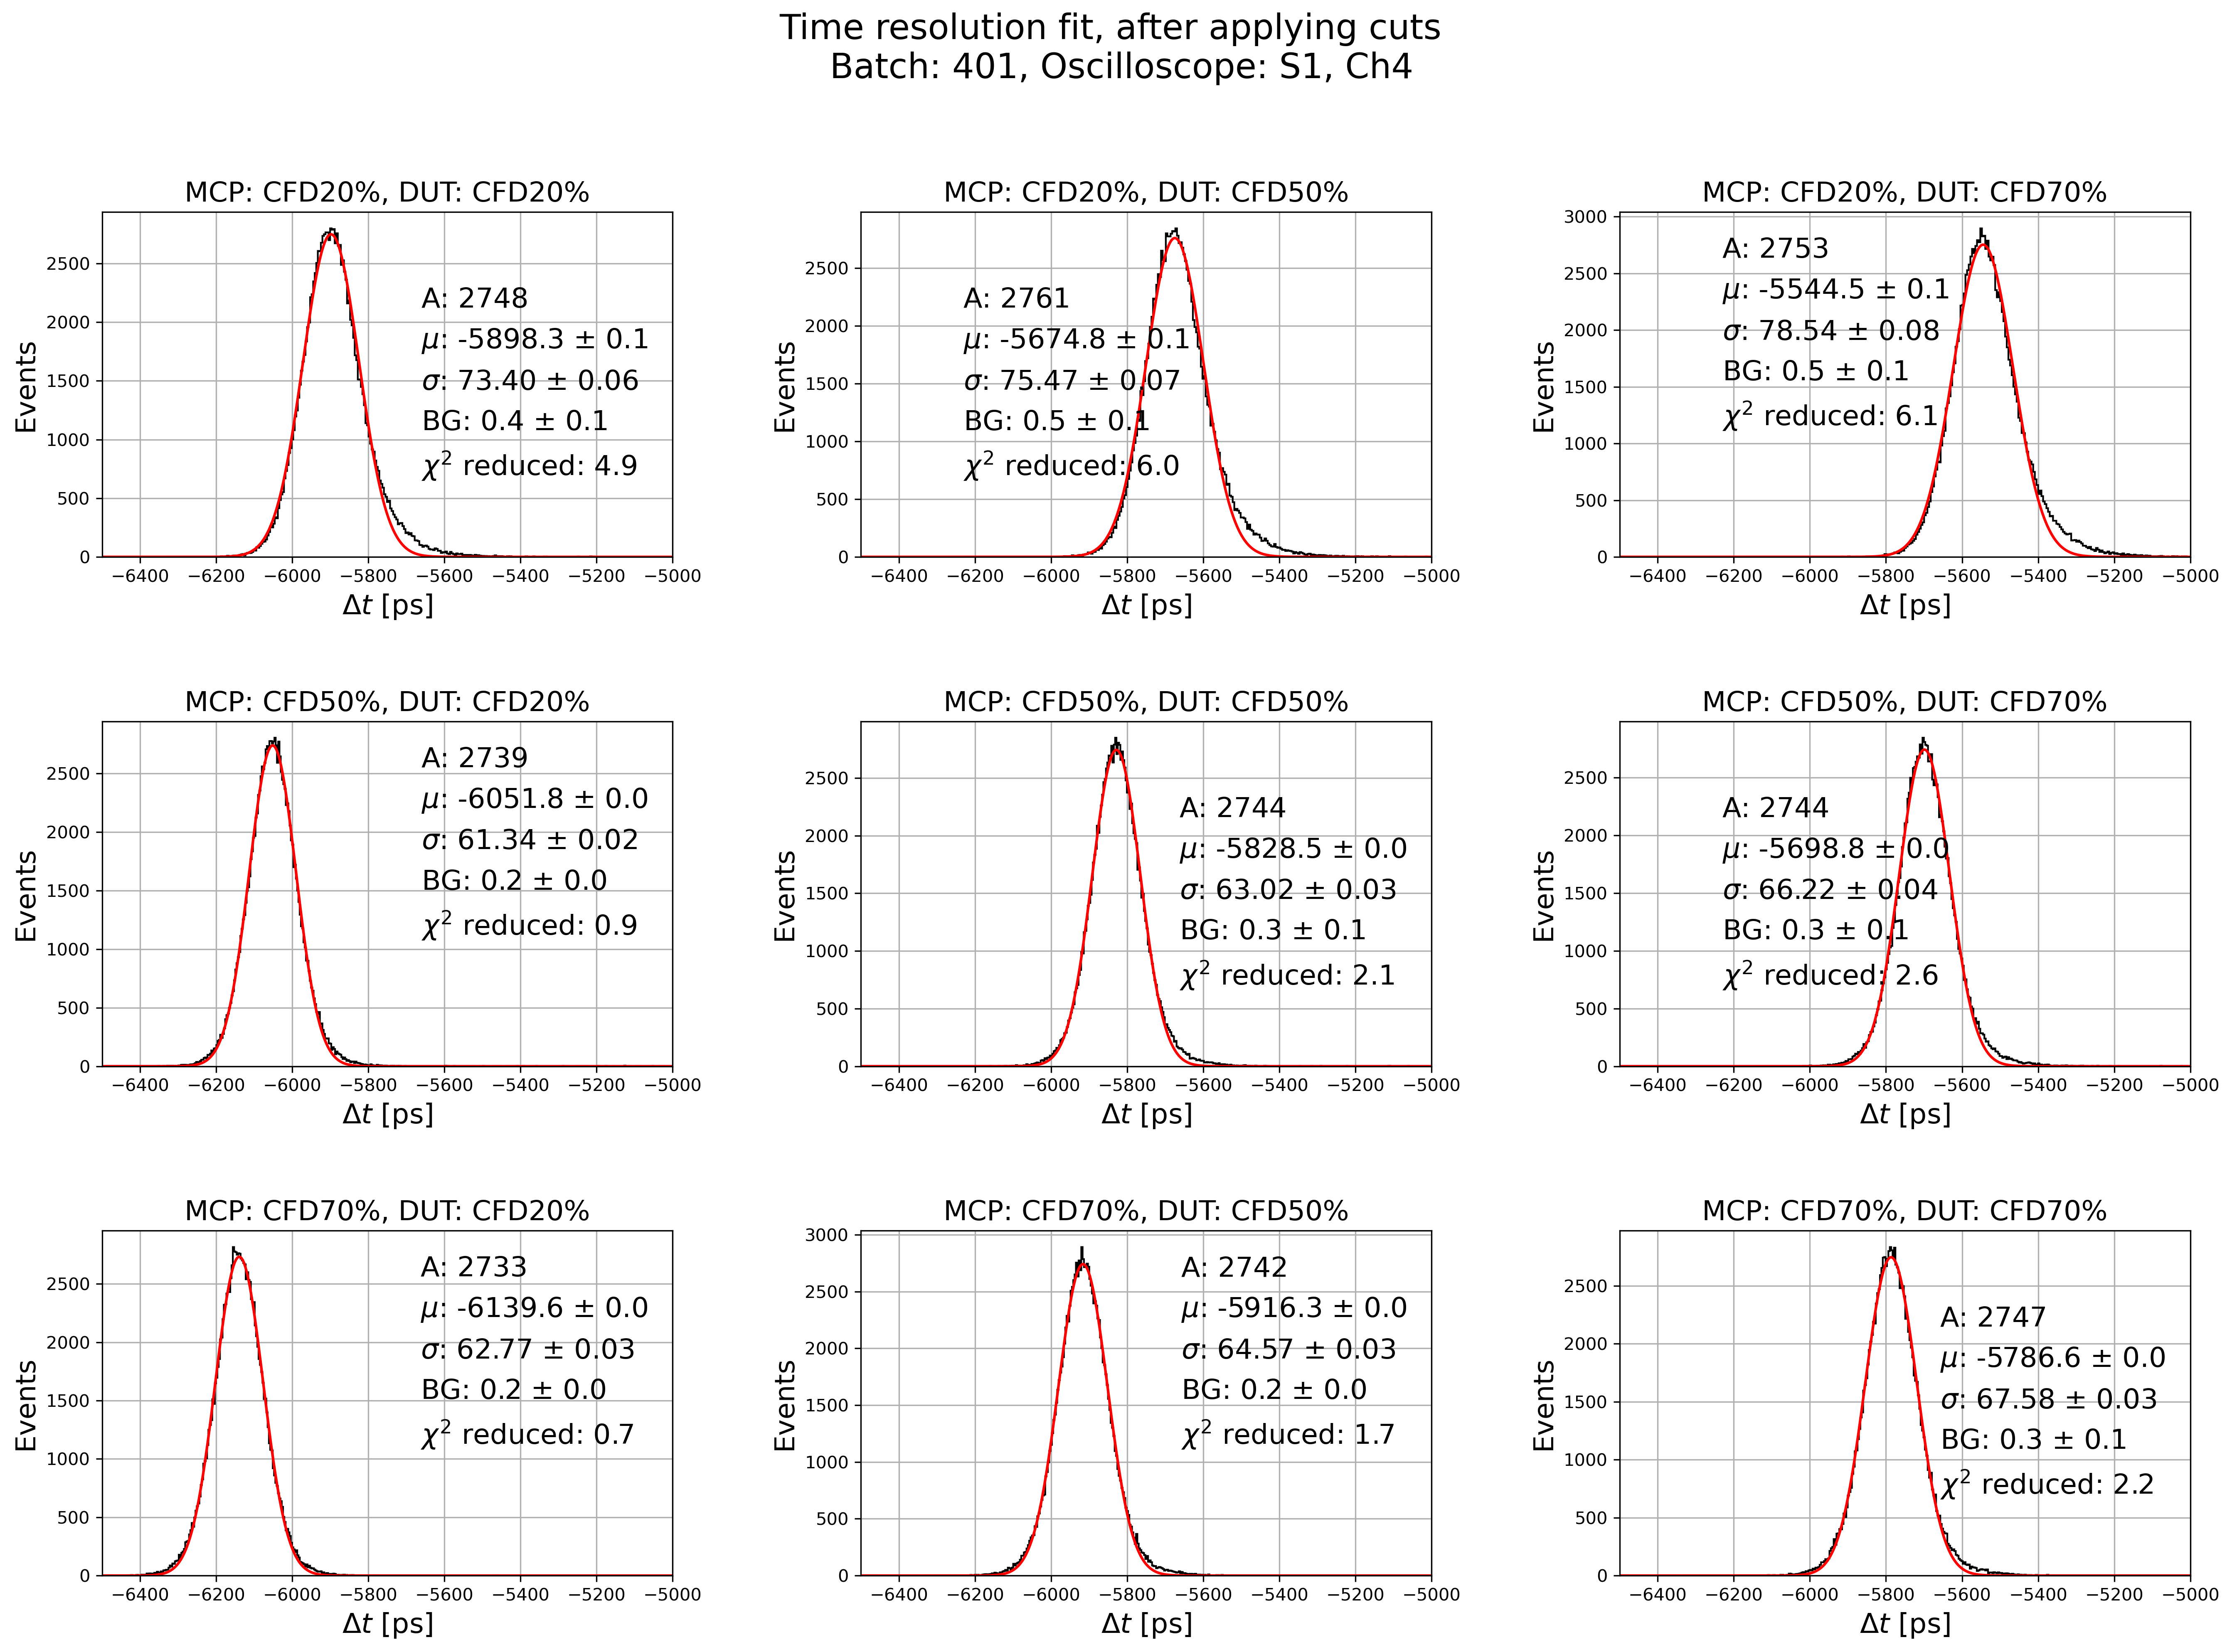

In [22]:
CFD_values = (20, 50,70)
axes_size = len(CFD_values)

MCP_resolution = 36.52

dut = 3
window_limit = 20e3

fig, axes = plt.subplots(figsize=(6*axes_size,4*axes_size), nrows=axes_size, ncols=axes_size, dpi=300)

time_resolution_table = []
chi2_table = []

for i, ax in enumerate(axes.flatten()):
    CFD_MCP = CFD_values[i//axes_size]
    CFD_DUT = CFD_values[i%axes_size]

    window_fit = np.logical_and((df[f"timeCFD{CFD_DUT}_{dut}"]-df[f"timeCFD{CFD_MCP}_0"])> -window_limit,
                               (df[f"timeCFD{CFD_DUT}_{dut}"]-df[f"timeCFD{CFD_MCP}_0"])< +window_limit)
    # dut_cut = np.logical_and(window_fit, all_cuts[dut-1])
    # dut_cut = np.logical_and(window_fit, np.logical_and(pulse_cuts[dut-1],geo_cuts[dut-1]))
    ### ONLY EVENTS WITH CHARGE OVER THE THRESHOLD CHARGE
    dut_cut = np.logical_and(df[f"charge_{dut}"]>threshold_charge,
                             np.logical_and(window_fit, np.logical_and(pulse_cuts[dut-1],geo_cuts[dut-1])))

    hist, my_bins,_,_,_ = plot_histogram((df[f"timeCFD{CFD_DUT}_{dut}"].loc[dut_cut]-df[f"timeCFD{CFD_MCP}_0"].loc[dut_cut]),
                                         bins='auto', color='k', linewidth=1, alpha=1,
                                         fig_ax=(fig,ax))

    bins_centers = (my_bins[:-1]+my_bins[1:])/2
    initial_param = (np.max(hist),bins_centers[np.argmax(hist)],100,np.average(hist))
    param, covar = curve_fit(my_gauss, bins_centers, hist, p0=initial_param)#, sigma=hist**0.5, absolute_sigma=True)
    #     print(f"Fit parameters: {param}"
    ax.plot(bins_centers, my_gauss(bins_centers,*param), color=colormap[dut])

    ### add units to the parameters
    ax.plot([],[],linewidth=0, label="A: %.0f" %param[0]) # only two decimals
    ax.plot([],[],linewidth=0, label="$\mu$: %.1f $\pm$ %.1f"%(param[1],covar[1,1]**0.5))
    ax.plot([],[],linewidth=0, label="$\sigma$: %.2f $\pm$ %.2f"%(param[2],covar[2,2]**0.5))
    ax.plot([],[],linewidth=0, label="BG: %.1f $\pm$ %.1f"%(param[3],covar[3,3]**0.5))
    chi2_reduced = sum((hist-my_gauss(bins_centers,*param))**2/my_gauss(bins_centers,*param))/(len(hist)-len(param))
    ax.plot([],[],linewidth=0, label="$\chi^2$ reduced: "+f"%.1f"%chi2_reduced)
    ### skewness doesn't work, idk why
#     skewness = skew((df[f"timeCFD{CFD_DUT}_{dut}"].loc[dut_cut]-df[f"timeCFD{CFD_MCP}_0"].loc[dut_cut]))
#     ax.plot([],[],linewidth=0, label="skewness: %.1f" %skewness[1])
    
#     ax.plot([],[],linewidth=0, label=f"(MCP: CFD{CFD_MCP}%, DUT: CFD{CFD_DUT}%)")
    ax.set_title(f"MCP: CFD{CFD_MCP}%, DUT: CFD{CFD_DUT}%", fontsize=16)
    ax.set_xlabel(f"$\Delta t$ [ps]", fontsize=16)
    ax.set_ylabel("Events", fontsize=16)
    time_resolution_table.append(np.sqrt(param[2]**2-MCP_resolution**2))
    chi2_table.append(chi2_reduced)

    xlim = (-6.5e3,-5e3)
    # xlim = (-10e3,0)
    ax.set_xlim(xlim)
    ax.legend(fontsize=16, framealpha=0, markerscale=0)
    
    
fig.tight_layout(w_pad=4, h_pad=4)
fig.suptitle(f"Time resolution fit, after applying cuts \
\n Batch: {this_batch}, Oscilloscope: {S}, Ch{dut+1}",y=1.1 , fontsize=20)

if SAVE:
    fig.savefig(os.path.join(pres_path, f"time_resolution_{this_batch}_{S} comparing CFD.png"), bbox_inches="tight")
    

In [29]:
time_resolution_table = np.array(time_resolution_table).reshape(axes_size,axes_size)
chi2_table = np.array(chi2_table).reshape(axes_size,axes_size)

print(time_resolution_table)
print(chi2_table)

## Plotting two channels togethere
I should plot Ch4 of S1 and Ch4 of S2

In [6]:
S = 'S1'
df = load_batch(this_batch,S)

In [7]:
# transimpedance = [dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').transimpedance for dut in [1,2,3]]
# mins = [find_min_btw_peaks(df[f"pulseHeight_{dut}"], bins='rice', plot=False) for dut in [1,2,3]]

geo_cuts = [geometry_mask(df, DUT_number=dut, bins=bins1, bins_find_min='rice')[0] for dut in [1,2,3]]
extended_geo_cuts = [geometry_mask(df, DUT_number=dut, bins=bins1, bins_find_min='rice', only_select='extended', fraction=0.5)[0] for dut in [1,2,3]]
time_cuts = [time_mask(df, DUT_number=dut, sigmas=3)[0] for dut in [1,2,3]]
# pulse_cuts = [df[f'pulseHeight_{dut}']>mins[dut-1] for dut in [1,2,3]]

# all_cuts = [np.logical_and(np.logical_and(geo_cuts[dut-1], time_cuts[dut-1]), pulse_cuts[dut-1]) for dut in [1,2,3]]

# fit_cuts = [np.logical_and(df[f"charge_{dut}"]>0, all_cuts[dut-1]) for dut in [1,2,3]]

/home/marcello/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/marcello/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/marcello/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/marcello/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/marcello/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/marcello/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/marcello/.local/lib/py

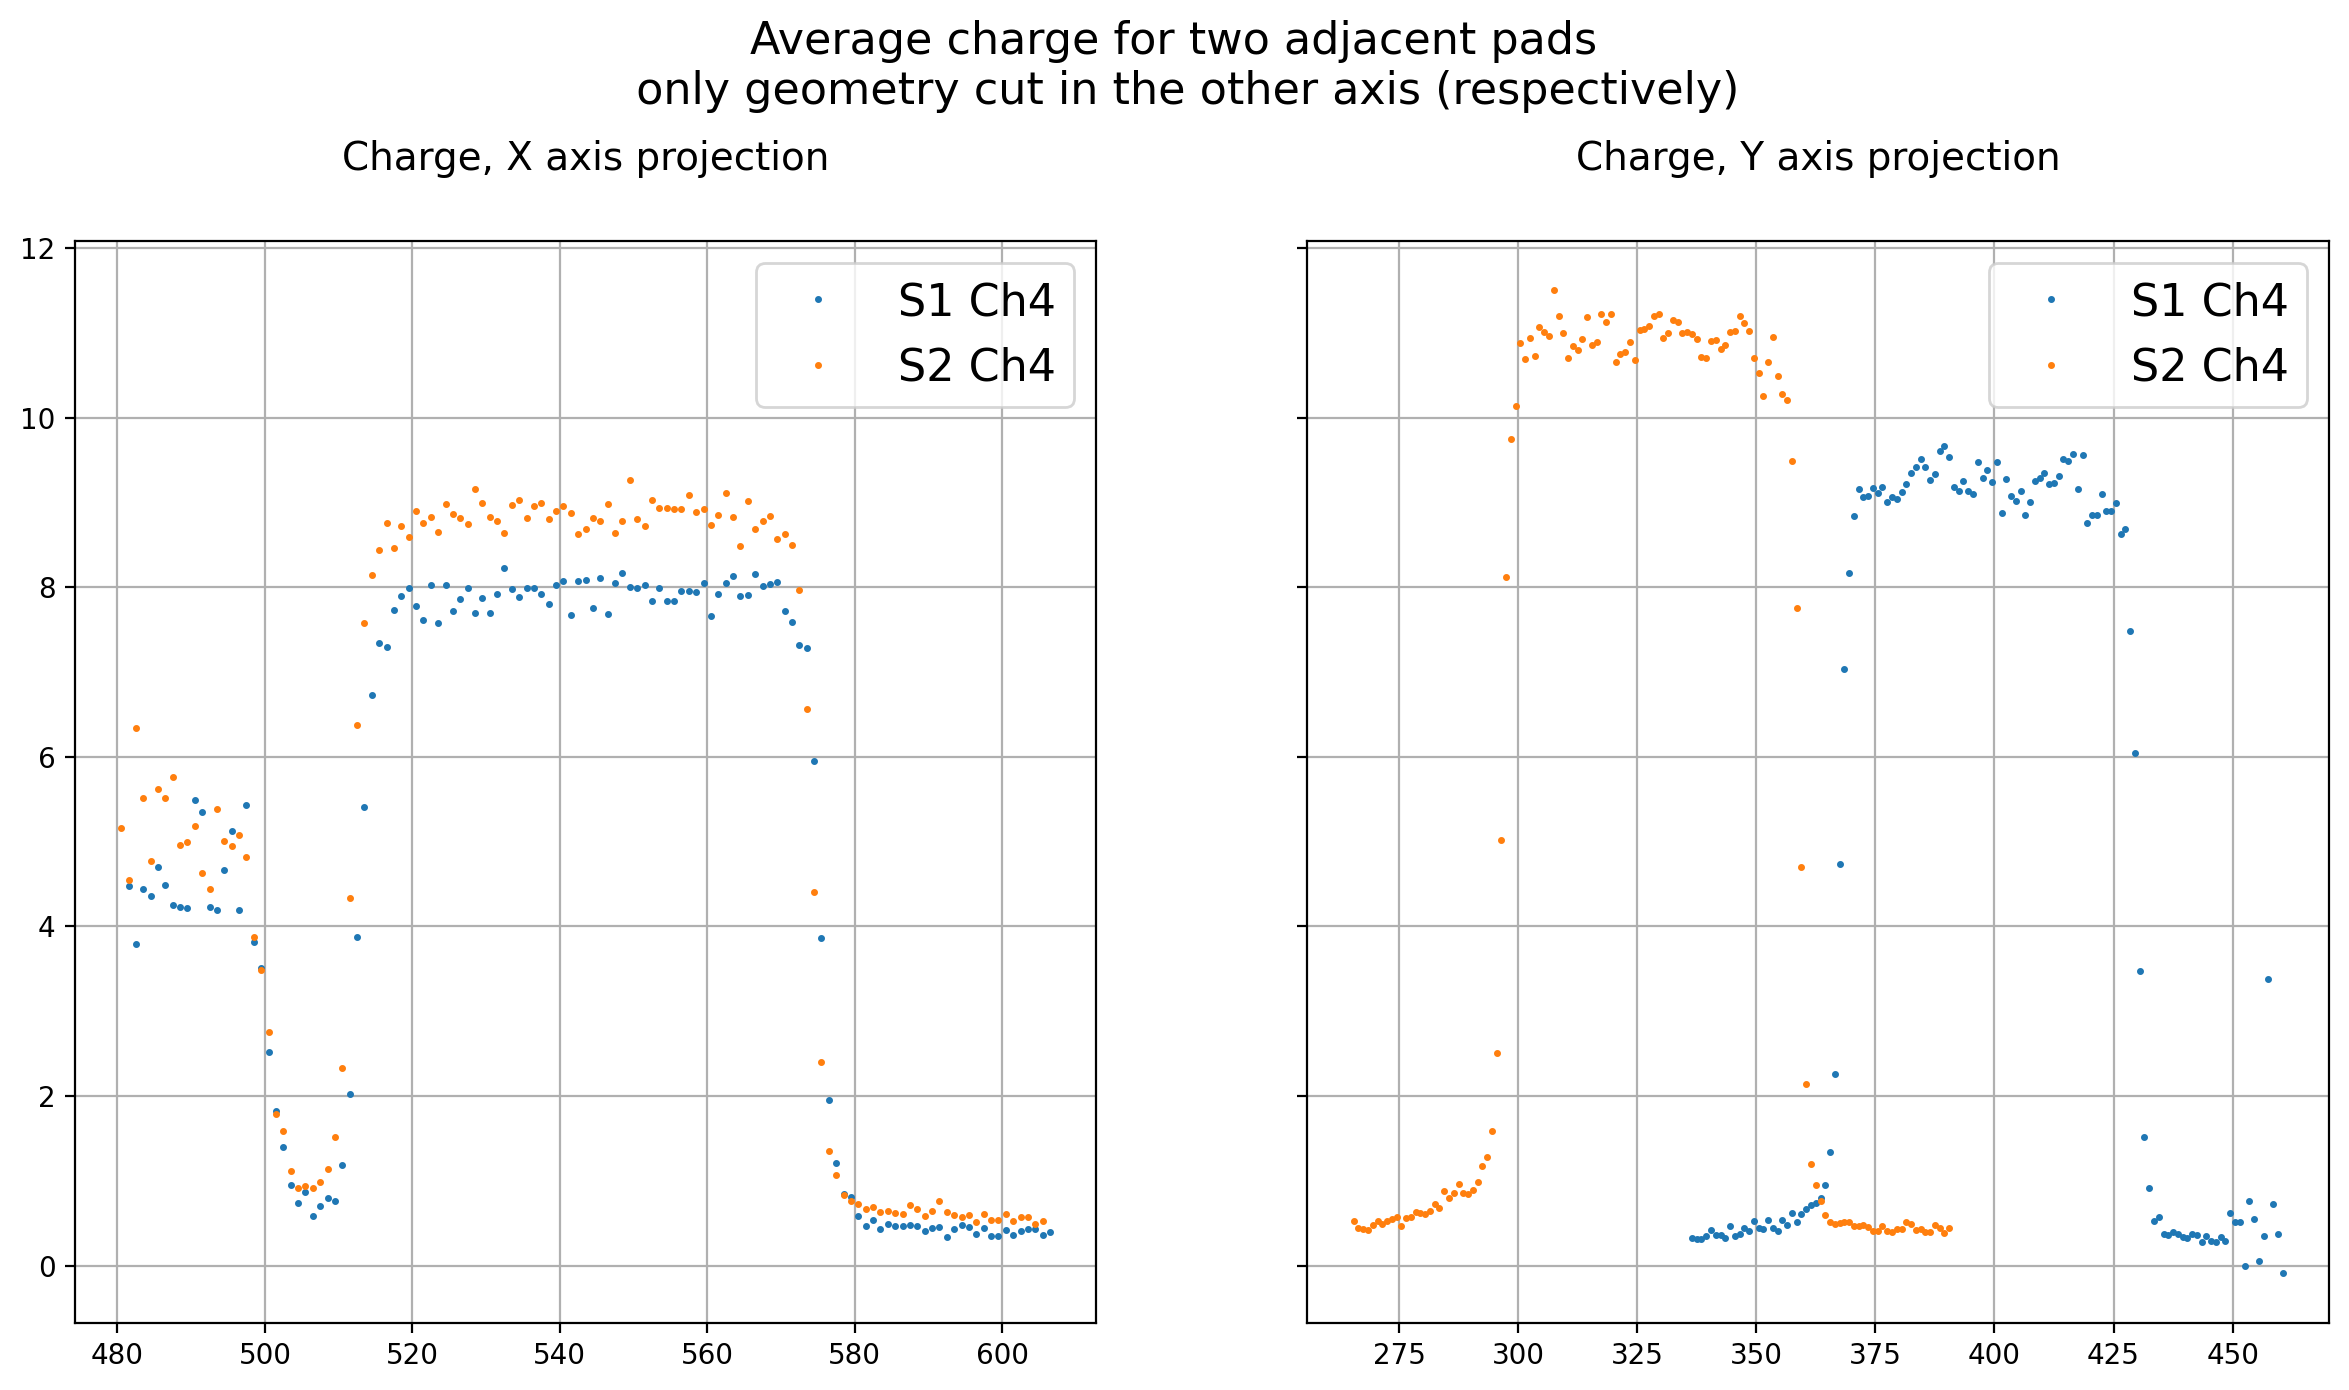

In [20]:
### 1D projection of charge

n_DUT = [3]

fig, axes = plt.subplots(nrows=len(n_DUT), ncols=2, figsize=(12, 6*len(n_DUT)), sharex=False, sharey=True, dpi=200)
# if len(n_DUT)==1: axes = axes[...,np.newaxis]  ### add an empty axis so I can call axes[i,j] in any case           
fig.tight_layout(w_pad=6, h_pad=10)
bins_find_min = 'rice'



S = 'S1'
df = load_batch(this_batch,S)
dut = 3

geo_cut = geometry_mask(df, DUT_number=dut, bins=bins1, bins_find_min='rice')[0]
extended_geo_cut = geometry_mask(df, DUT_number=dut, bins=bins1, bins_find_min='rice', only_select='extended', fraction=0.5)[0]
time_cut = time_mask(df, DUT_number=dut, sigmas=3)[0]


for coord_idx, XY in enumerate(('X','Y')):  # coord = ['X','Y']
    geo_mask, edges = geometry_mask(df, DUT_number=dut, bins=bins1, bins_find_min=bins_find_min, only_select=XY, use='pulseheight')
    bool_mask = extended_geo_cut
#     bool_mask = time_cut
#     bool_mask = np.ones_like(geo_cut)  ### no cuts

    transimpedance = 4700

#         events_above_threshold = df[f"charge_{dut}"].loc[bool_mask]/transimpedance > threshold_charge
#         above_threshold = np.logical_and(bool_mask, events_above_threshold)
    total_events_in_bin, bins_edges = np.histogram(df[f"{XY}tr_{dut-1}"].loc[bool_mask], bins=bins1[coord_idx])
#         events_above_threshold_in_bin, _  = np.histogram(df[f"{XY}tr_{dut-1}"].loc[above_threshold], bins=bins[coord_idx])

    bins_centers = (bins_edges[:-1]+bins_edges[1:])/2
#         eff, err = efficiency_k_n(events_above_threshold_in_bin, total_events_in_bin)
    charge = []
    for i,one_bin in enumerate(bins_edges[:-1]):
        one_bin_cut = np.logical_and(df[f"{XY}tr_{dut-1}"]>=bins_edges[i], 
                                     df[f"{XY}tr_{dut-1}"]<bins_edges[i+1])
        tot_cut = np.logical_and(one_bin_cut, bool_mask)
        charge.append(np.average(df[f"charge_{dut}"].loc[tot_cut]/transimpedance))
        
    
    charge = np.array(charge)
    axes[coord_idx].plot(bins_centers, charge, '.', label=f"{S} Ch{dut+1}", markersize=3)#, drawstyle='steps-mid')
    axes[coord_idx].grid('--')
    
    
    
    
S = 'S2'
df = load_batch(this_batch,S)
dut = 3

geo_cut = geometry_mask(df, DUT_number=dut, bins=bins1, bins_find_min='rice')[0]
extended_geo_cut = geometry_mask(df, DUT_number=dut, bins=bins1, bins_find_min='rice', only_select='extended', fraction=0.5)[0]
time_cut = time_mask(df, DUT_number=dut, sigmas=3)[0]
 
    
for coord_idx, XY in enumerate(('X','Y')):  # coord = ['X','Y']
    geo_mask, edges = geometry_mask(df, DUT_number=dut, bins=bins1, bins_find_min=bins_find_min, only_select=XY, use='pulseheight')
    bool_mask = extended_geo_cut
#     bool_mask = time_cut
#     bool_mask = np.ones_like(geo_cut)  ### no cuts

    transimpedance = 4700

#         events_above_threshold = df[f"charge_{dut}"].loc[bool_mask]/transimpedance > threshold_charge
#         above_threshold = np.logical_and(bool_mask, events_above_threshold)
    total_events_in_bin, bins_edges = np.histogram(df[f"{XY}tr_{dut-1}"].loc[bool_mask], bins=bins1[coord_idx])
#         events_above_threshold_in_bin, _  = np.histogram(df[f"{XY}tr_{dut-1}"].loc[above_threshold], bins=bins[coord_idx])

    bins_centers = (bins_edges[:-1]+bins_edges[1:])/2
#         eff, err = efficiency_k_n(events_above_threshold_in_bin, total_events_in_bin)
    charge = []
    for i,one_bin in enumerate(bins_edges[:-1]):
        one_bin_cut = np.logical_and(df[f"{XY}tr_{dut-1}"]>=bins_edges[i], 
                                     df[f"{XY}tr_{dut-1}"]<bins_edges[i+1])
        tot_cut = np.logical_and(one_bin_cut, bool_mask)
        charge.append(np.average(df[f"charge_{dut}"].loc[tot_cut]/transimpedance))
        
    
    charge = np.array(charge)
    axes[coord_idx].plot(bins_centers, charge, '.', label=f"{S} Ch{dut+1}", markersize=3)#, drawstyle='steps-mid')
    plot_title = f"Charge, {XY} axis projection"
    axes[coord_idx].set_title(plot_title, fontsize=14, y=1.05)
    
    axes[coord_idx].legend(fontsize=16)
    
    
fig.suptitle("Average charge for two adjacent pads \n only geometry cut in the other axis (respectively)", y=1.15, fontsize=16)

fig.savefig(os.path.join(pres_path,f"Charge collected for two adjacent channels_S1_S2_{this_batch}.png"), bbox_inches="tight")

In [ ]:
### 2D plot of charge

n_DUT = [3]

fig, axes = plt.subplots(nrows=2, ncols=len(n_DUT), figsize=(6*len(n_DUT),12), sharex=False, sharey=True, dpi=200)
if len(n_DUT)==1: axes = axes[...,np.newaxis]  ### add an empty axis so I can call axes[i,j] in any case           

fig.tight_layout(w_pad=6, h_pad=10)
ylim = (0.4, 1)

for i,dut in enumerate(n_DUT):
    if geometry_cut in ('center', 'normal', 'extended'):
        geo_mask, edges = geometry_mask(df, DUT_number=dut, bins=bins, bins_find_min=bins_find_min, only_select=geometry_cut, use=use)
    for coord_idx, XY in enumerate(('X','Y')):  # coord = ['X','Y']
        if geometry_cut=='XY':
            geo_mask, edges = geometry_mask(df, DUT_number=dut, bins=bins, bins_find_min=bins_find_min, only_select=XY, use=use)
        if geometry_cut and mask: bool_mask = np.logical_and(mask[dut-1],geo_mask)
        elif geometry_cut:  bool_mask = geo_mask  ### this is a boolean mask of the selected positions                
        elif mask:          bool_mask = mask[dut-1]
        else:       bool_mask = pd.Series(True,index=df.index)
        if transimpedance is None:
            transimpedance = batch_object.S[this_scope].get_sensor(f'Ch{dut+1}').transimpedance
        events_above_threshold = df[f"charge_{dut}"].loc[bool_mask]/transimpedance > threshold_charge
        above_threshold = np.logical_and(bool_mask, events_above_threshold)

        total_events_in_bin, bins_edges = np.histogram(df[f"{XY}tr_{dut-1}"].loc[bool_mask], bins=bins[coord_idx])
        events_above_threshold_in_bin,m_  = np.histogram(df[f"{XY}tr_{dut-1}"].loc[above_threshold], bins=bins[coord_idx])

        bins_centers = (bins_edges[:-1]+bins_edges[1:])/2
        eff, err = efficiency_k_n(events_above_threshold_in_bin, total_events_in_bin)
        axes[coord_idx,i].plot(bins_centers, eff, label=f"Ch{dut+1}", drawstyle='steps-mid')
        sigma_coeff = 1
        axes[coord_idx,i].errorbar(bins_centers, eff, yerr=sigma_coeff*err, elinewidth=1, markersize=0, linewidth=0, capsize=1.5,
                    label=f"error: {sigma_coeff}$\sigma$")
        plot_title = f"{XY} axis projection, Ch{dut+1}\n{batch_object.S[this_scope].get_sensor(f'Ch{dut+1}').name}"
        axes[coord_idx,i].set_title(plot_title, fontsize=20, y=1.05)
        axes[coord_idx,i].set_xlabel(f"{XY} position (pixels)", fontsize=20)
        axes[coord_idx,i].set_ylabel("Efficiency", fontsize=20)
        axes[coord_idx,i].set_ylim(ylim)
        if zoom_to_sensor and geometry_cut:
            try:
                if XY=='X':     axes[coord_idx,i].set_xlim(edges['left_edge'],edges['right_edge'])
                elif XY=='Y':   axes[coord_idx,i].set_xlim(edges['bottom_edge'],edges['top_edge'])
            except:
                logging.error("in plot(), could not set limits to geometry_cut")
        ### calculate average only between limits of the plot
        between_edges = np.logical_and(bins_centers>axes[coord_idx,i].get_xlim()[0], bins_centers<axes[coord_idx,i].get_xlim()[1])
        efficiency_bar = np.average(eff[between_edges]) ### horizontal line at this efficiency %
        axes[coord_idx,i].axhline(efficiency_bar, label=f"Average efficiency: %.2f"%(efficiency_bar*100)+'%', color='r', alpha=0.4, linewidth=2)
        axes[coord_idx,i].grid('--')
        axes[coord_idx,i].legend(fontsize=14)
title_position = 1.1

In [60]:
sum(expected_data)

59

# Investigating the horizontal lines, e.g. batch 401, S2, dut 2

In [ ]:
geometry_cut, info = geometry_mask(df, DUT_number=2, bins=bins1, bins_find_min='rice', only_select='normal', use='pulseheight')

In [ ]:
### define the area to analize the line and compare it with a small area just above it
bottom_line, top_line = 255, 256
bottom_above, top_above = 262,263

line_cut = np.logical_and(df['Ytr_1']>=bottom_line, df['Ytr_1']<=top_line)
above_line_cut = np.logical_and(df['Ytr_1']>=bottom_above, df['Ytr_1']<=top_above)

tot_cut = np.logical_and(geometry_cut,line_cut),
tot_cut2 = np.logical_and(geometry_cut,above_line_cut)

info.update({'bottom_edge':bottom_line, 'top_edge':top_line})
info_above = info.copy()
info_above.update({'bottom_edge':bottom_above, 'top_edge':top_above})

In [ ]:
SAVE = True
fig, axes = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=bins1, n_DUT=[2],# mask=tot_cut,
                    savefig=SAVE, savefig_path=pres_path, savefig_details=f" position of the line",fmt='png')
fig.suptitle("Investigating horizontal 'lines'", fontsize=24, y=1.05, ha='center')
axes[0].add_patch(rectangle_from_geometry_cut(**info, lw=0.5))
axes[0].add_patch(rectangle_from_geometry_cut(**info_above, lw=0.5, ec='b'))

fig.savefig(os.path.join(pres_path, "2D Tracks, Horizontal lines.png"), bbox_inches="tight")


 ### Plotting the *time vs pulseheight* density

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16,9), subplot_kw={'projection':'scatter_density'})

plot(df.loc[tot_cut], "Time_pulseHeight", dict_of_batches[this_batch], S, bins=10000,
     n_DUT=[2], savefig=SAVE, savefig_details=f' {S} investigating line', savefig_path=pres_path, fmt='png', extra_info=True,
    fig_ax=(fig,axes[0]))

plot(df.loc[tot_cut2], "Time_pulseHeight", dict_of_batches[this_batch], S, bins=10000,
     n_DUT=[2], savefig=SAVE, savefig_details=f' {S} investigating line', savefig_path=pres_path, fmt='png', extra_info=True,
    fig_ax=(fig,axes[1]))

axes[0].set_title("On the line", fontsize=20)
axes[1].set_title("Above the line", fontsize=20)


# axes[0].legend(fontsize=16, loc='best', framealpha=0)
# axes[1].legend(fontsize=16, loc='best', framealpha=0)

fig.savefig(os.path.join(pres_path, "Time_vs_pulseheight density, horizontal lines.png"), bbox_inches="tight")


 ### Plotting the *pulseHeight* 

In [ ]:
DUTs = [2]
dut = 2
fig, ax = plt.subplots(figsize=(16,9), ncols=1, dpi=300)

transimpedance = dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').transimpedance 

hist,my_bins,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[tot_cut]/transimpedance, bins=500,
                                      color='r', label=f"charge on the line",
                                      fig_ax=(fig,ax))

hist,my_bins,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[tot_cut2]/transimpedance, bins=my_bins,
                                      color='b', label=f"charge above the line",
                                      fig_ax=(fig,ax))
ax.semilogy()
ax.set_xlim(-10, 100)
ax.legend(fontsize=20)
fig.suptitle("Charge distribution, comparing on the line and above", fontsize=24)

fig.savefig(os.path.join(pres_path, "Charge, Horizontal lines.png"), bbox_inches="tight")


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6), dpi=200)

hist, my_bins,_,_,_ = plot_histogram(df[f'pulseHeight_{dut}'].loc[tot_cut], bins=200,
                                     color='r', label='On the line', fig_ax=(fig,ax))
hist, _,_,_,_ = plot_histogram(df[f'pulseHeight_{dut}'].loc[tot_cut2], bins=my_bins,
                               color='b', label='Above the line', fig_ax=(fig,ax))
ax.legend(fontsize=20)
# plot(df.loc[tot_cut], "pulseHeight", dict_of_batches[this_batch], S, bins=200,
#      n_DUT=[2], savefig=SAVE, savefig_details=f' {S} investigating line', savefig_path=pres_path, fmt='png', extra_info=True,
#     fig_ax=(fig,ax))
fig.suptitle("PulseHeight distribution, comparing on the line and above", fontsize=24)

fig.savefig(os.path.join(pres_path, "PulseHeight, Horizontal lines.png"), bbox_inches="tight")


## LeCroy Oscilloscope .trc parser

In [3]:
import lecroyparser


trc_file_path = "/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/Data_TestBeam/2023_May/Oscilloscope_raw_1/C1WF00000.trc"

data = lecroyparser.ScopeData(trc_file_path)

data.__dict__.keys()

dict_keys(['path', 'data', 'endianness', 'posWAVEDESC', 'commOrder', 'templateName', 'commType', 'waveDescriptor', 'userText', 'trigTimeArray', 'waveArray1', 'instrumentName', 'instrumentNumber', 'traceLabel', 'waveArrayCount', 'verticalGain', 'verticalOffset', 'nominalBits', 'horizInterval', 'horizOffset', 'vertUnit', 'horUnit', 'triggerTime', 'recordType', 'processingDone', 'timeBase', 'verticalCoupling', 'bandwidthLimit', 'waveSource', 'x', 'y'])

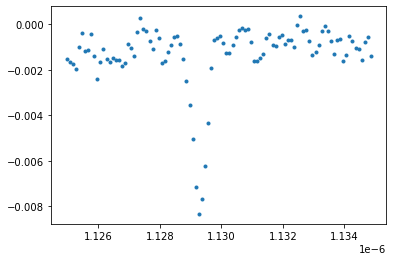

In [8]:
one_point = 12000
left_edge = 800
right_edge = 900
plt.plot(data.x[one_point+left_edge:one_point+right_edge], data.y[one_point+left_edge:one_point+right_edge],
        '.')

In [51]:
data.waveArray1

4979840